### Import Libraries

In [2]:
%pip install pandas==2.1.1
%pip install scorecardpy==0.1.9.7

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# For scorecard construction
import warnings
import scorecardpy as sc
import pprint

# Step 1: Data Exploration

### Application Data 

In [4]:
# View structures
appData = pd.read_csv("IS453 Group Assignment - Application Data.csv")
appData.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
appData.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 120 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(63), int64(41), object(16)
memory usage: 281.5+ MB


## Bureau Data 

In [6]:
bureauData = pd.read_csv("IS453 Group Assignment - Bureau Data.csv")
bureauData.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [7]:
bureauData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


## Variable selection and filtering

In [8]:
print("="*80)
print("VARIABLE SELECTION AND FILTERING")
print("="*80)

# Step 1: Remove categorical variables with only 1 unique value
print("\n1. DROPPING CATEGORICAL VARIABLES WITH NO VARIATION (1 unique value):")
print("-" * 80)

appData_filtered = appData.copy()
cols_before = len(appData_filtered.columns)

# Get categorical columns with only 1 unique value
single_value_cols = []
for col in appData_filtered.select_dtypes(include=['object']).columns:
    if appData_filtered[col].nunique() == 1:
        single_value_cols.append(col)
        print(f"  Dropping: {col} (only 1 unique value: {appData_filtered[col].unique()[0]})")

appData_filtered = appData_filtered.drop(columns=single_value_cols)
print(f"  Columns dropped: {len(single_value_cols)}")
print(f"  Remaining columns: {len(appData_filtered.columns)}")

# Step 2: Drop variables with more than 55% missing data
print("\n2. DROPPING VARIABLES WITH >55% MISSING DATA:")
print("-" * 80)

total_rows = len(appData_filtered)
missing_threshold = 0.55

high_missing_cols = []
for col in appData_filtered.columns:
    missing_count = appData_filtered[col].isnull().sum()
    missing_pct = missing_count / total_rows
    
    if missing_pct > missing_threshold:
        high_missing_cols.append(col)
        print(f"  Dropping: {col} ({missing_pct*100:.2f}% missing - {missing_count:,} out of {total_rows:,})")

appData_filtered = appData_filtered.drop(columns=high_missing_cols)
print(f"  Columns dropped: {len(high_missing_cols)}")
print(f"  Remaining columns: {len(appData_filtered.columns)}")

# Step 3: Drop variables with no variation between Goods and Bads
print("\n3. DROPPING VARIABLES WITH NO VARIATION BETWEEN GOODS AND BADS:")
print("-" * 80)

no_variation_cols = []
for col in appData_filtered.columns:
    if col == 'TARGET' or col == 'SK_ID_CURR':
        continue
    
    # Check if distribution is identical for goods and bads
    goods_dist = appData_filtered[appData_filtered['TARGET'] == 0][col].value_counts(normalize=True)
    bads_dist = appData_filtered[appData_filtered['TARGET'] == 1][col].value_counts(normalize=True)
    
    # If distributions are identical, flag for dropping
    if goods_dist.equals(bads_dist):
        no_variation_cols.append(col)
        print(f"  Dropping: {col} (identical distribution for goods and bads)")

appData_filtered = appData_filtered.drop(columns=no_variation_cols)
print(f"  Columns dropped: {len(no_variation_cols)}")
print(f"  Remaining columns: {len(appData_filtered.columns)}")

# Step 4: Drop gender for fairness
print("\n4. DROPPING GENDER FOR FAIRNESS:")
print("-" * 80)

gender_cols = [col for col in appData_filtered.columns if 'GENDER' in col.upper()]
if gender_cols:
    for col in gender_cols:
        print(f"  Dropping: {col}")
    appData_filtered = appData_filtered.drop(columns=gender_cols)
else:
    print("  No gender columns found")

print(f"  Remaining columns: {len(appData_filtered.columns)}")

# Final Summary
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"\nOriginal columns: {cols_before}")
print(f"Final columns: {len(appData_filtered.columns)}")
print(f"Columns dropped: {cols_before - len(appData_filtered.columns)}")

print(f"\nDropdown breakdown:")
print(f"  - Single value categorical: {len(single_value_cols)}")
print(f"  - More than 55% missing data: {len(high_missing_cols)}")
print(f"  - No variation (goods vs bads): {len(no_variation_cols)}")
print(f"  - Gender (fairness): {len(gender_cols)}")

print(f"\nVariable name: appData_filtered")
print(f"Shape: {appData_filtered.shape}")

VARIABLE SELECTION AND FILTERING

1. DROPPING CATEGORICAL VARIABLES WITH NO VARIATION (1 unique value):
--------------------------------------------------------------------------------
  Columns dropped: 0
  Remaining columns: 120

2. DROPPING VARIABLES WITH >55% MISSING DATA:
--------------------------------------------------------------------------------
  Dropping: OWN_CAR_AGE (65.99% missing - 202,929 out of 307,511)
  Dropping: EXT_SOURCE_1 (56.38% missing - 173,378 out of 307,511)
  Dropping: BASEMENTAREA_AVG (58.52% missing - 179,943 out of 307,511)
  Dropping: YEARS_BUILD_AVG (66.50% missing - 204,488 out of 307,511)
  Dropping: COMMONAREA_AVG (69.87% missing - 214,865 out of 307,511)
  Dropping: FLOORSMIN_AVG (67.85% missing - 208,642 out of 307,511)
  Dropping: LANDAREA_AVG (59.38% missing - 182,590 out of 307,511)
  Dropping: LIVINGAPARTMENTS_AVG (68.35% missing - 210,199 out of 307,511)
  Dropping: NONLIVINGAPARTMENTS_AVG (69.43% missing - 213,514 out of 307,511)
  Dropping

In [9]:
print("="*80)
print("VARIABLE SELECTION AND FILTERING FOR BUREAU DATA")
print("="*80)

# First, merge bureauData with appData to get TARGET variable
print("\nMerging Bureau Data with Target variable from Application Data...")
bureauData_with_target = bureauData.merge(appData_filtered[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')

bureauData_filtered = bureauData_with_target.copy()
cols_before = len([col for col in bureauData_filtered.columns if col not in ['SK_ID_CURR', 'SK_ID_BUREAU', 'TARGET']])

# Step 1: Remove categorical variables with only 1 unique value
print("\n1. DROPPING CATEGORICAL VARIABLES WITH NO VARIATION (1 unique value):")
print("-" * 80)

single_value_cols = []
for col in bureauData_filtered.select_dtypes(include=['object']).columns:
    if col in ['SK_ID_CURR', 'SK_ID_BUREAU', 'TARGET']:
        continue
    if bureauData_filtered[col].nunique() == 1:
        single_value_cols.append(col)
        print(f"  Dropping: {col} (only 1 unique value: {bureauData_filtered[col].unique()[0]})")

bureauData_filtered = bureauData_filtered.drop(columns=single_value_cols)
print(f"  Columns dropped: {len(single_value_cols)}")
remaining_cols = len([col for col in bureauData_filtered.columns if col not in ['SK_ID_CURR', 'SK_ID_BUREAU', 'TARGET']])
print(f"  Remaining columns: {remaining_cols}")

# Step 2: Drop variables with more than 55% missing data
print("\n2. DROPPING VARIABLES WITH >55% MISSING DATA:")
print("-" * 80)

total_rows = len(bureauData_filtered)
missing_threshold = 0.55

high_missing_cols = []
for col in bureauData_filtered.columns:
    if col in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU']:
        continue
    
    missing_count = bureauData_filtered[col].isnull().sum()
    missing_pct = missing_count / total_rows
    
    if missing_pct > missing_threshold:
        high_missing_cols.append(col)
        print(f"  Dropping: {col} ({missing_pct*100:.2f}% missing - {missing_count:,} out of {total_rows:,})")

bureauData_filtered = bureauData_filtered.drop(columns=high_missing_cols)
print(f"  Columns dropped: {len(high_missing_cols)}")
remaining_cols = len([col for col in bureauData_filtered.columns if col not in ['SK_ID_CURR', 'SK_ID_BUREAU', 'TARGET']])
print(f"  Remaining columns: {remaining_cols}")

# Step 3: Drop variables with no variation between Goods and Bads
print("\n3. DROPPING VARIABLES WITH NO VARIATION BETWEEN GOODS AND BADS:")
print("-" * 80)

no_variation_cols = []
for col in bureauData_filtered.columns:
    if col in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU']:
        continue
    
    # Skip if column only has NaN values
    if bureauData_filtered[col].isnull().all():
        continue
    
    try:
        # Check if distribution is identical for goods and bads
        goods_dist = bureauData_filtered[bureauData_filtered['TARGET'] == 0][col].value_counts(normalize=True)
        bads_dist = bureauData_filtered[bureauData_filtered['TARGET'] == 1][col].value_counts(normalize=True)
        
        # If distributions are identical, flag for dropping
        if goods_dist.equals(bads_dist):
            no_variation_cols.append(col)
            print(f"  Dropping: {col} (identical distribution for goods and bads)")
    except:
        pass

bureauData_filtered = bureauData_filtered.drop(columns=no_variation_cols)
print(f"  Columns dropped: {len(no_variation_cols)}")
remaining_cols = len([col for col in bureauData_filtered.columns if col not in ['SK_ID_CURR', 'SK_ID_BUREAU', 'TARGET']])
print(f"  Remaining columns: {remaining_cols}")

# Step 4: Drop gender for fairness
print("\n4. DROPPING GENDER FOR FAIRNESS:")
print("-" * 80)

gender_cols = [col for col in bureauData_filtered.columns if 'GENDER' in col.upper()]
if gender_cols:
    for col in gender_cols:
        print(f"  Dropping: {col}")
    bureauData_filtered = bureauData_filtered.drop(columns=gender_cols)
else:
    print("  No gender columns found")

remaining_cols = len([col for col in bureauData_filtered.columns if col not in ['SK_ID_CURR', 'SK_ID_BUREAU', 'TARGET']])
print(f"  Remaining columns: {remaining_cols}")

# Final Summary
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"\nOriginal feature columns: {cols_before}")
final_cols = len([col for col in bureauData_filtered.columns if col not in ['SK_ID_CURR', 'SK_ID_BUREAU', 'TARGET']])
print(f"Final feature columns: {final_cols}")
print(f"Columns dropped: {cols_before - final_cols}")

print(f"\nDropdown breakdown:")
print(f"  - Single value categorical: {len(single_value_cols)}")
print(f"  - More than 55% missing data: {len(high_missing_cols)}")
print(f"  - No variation (goods vs bads): {len(no_variation_cols)}")
print(f"  - Gender (fairness): {len(gender_cols)}")

# Remove TARGET column before final output (it was just for variation analysis)
bureauData_filtered = bureauData_filtered.drop(columns=['TARGET'])

print(f"\nVariable name: bureauData_filtered")
print(f"Shape: {bureauData_filtered.shape}")


VARIABLE SELECTION AND FILTERING FOR BUREAU DATA

Merging Bureau Data with Target variable from Application Data...

1. DROPPING CATEGORICAL VARIABLES WITH NO VARIATION (1 unique value):
--------------------------------------------------------------------------------
  Columns dropped: 0
  Remaining columns: 15

2. DROPPING VARIABLES WITH >55% MISSING DATA:
--------------------------------------------------------------------------------
  Dropping: AMT_CREDIT_MAX_OVERDUE (65.51% missing - 1,124,488 out of 1,716,428)
  Dropping: AMT_ANNUITY (71.47% missing - 1,226,791 out of 1,716,428)
  Columns dropped: 2
  Remaining columns: 13

3. DROPPING VARIABLES WITH NO VARIATION BETWEEN GOODS AND BADS:
--------------------------------------------------------------------------------
  Columns dropped: 0
  Remaining columns: 13

4. DROPPING GENDER FOR FAIRNESS:
--------------------------------------------------------------------------------
  No gender columns found
  Remaining columns: 13

FINAL 

## Check for Outliers

In [10]:
print("="*80)
print("DROPPING OUTLIERS FOR DAYS_EMPLOYED AND DAYS_BIRTH")
print("="*80)

# Store original row count
rows_before = len(appData_filtered)

# Define the 90-year threshold in days
days_per_year = 365.25
threshold_days = 90 * days_per_year  # ~32,872.5 days

print(f"\nThreshold: 90 years = {threshold_days:,.0f} days")

# Step 1: Drop outliers for DAYS_EMPLOYED
print("\n1. DROPPING OUTLIERS FOR DAYS_EMPLOYED (>90 years):")
print("-" * 80)

if 'DAYS_EMPLOYED' in appData_filtered.columns:
    # Convert to absolute value to get years of employment
    employment_years = abs(appData_filtered['DAYS_EMPLOYED']) / days_per_year
    
    # Find outliers
    employment_outliers = appData_filtered[employment_years > 90]
    print(f"  Records with employment > 90 years: {len(employment_outliers):,}")
    
    # Show some statistics before dropping
    if len(employment_outliers) > 0:
        print(f"  Employment years range (outliers): {employment_years[employment_years > 90].min():.2f} to {employment_years[employment_years > 90].max():.2f} years")
        print(f"  DAYS_EMPLOYED range (outliers): {appData_filtered.loc[employment_years > 90, 'DAYS_EMPLOYED'].min():,} to {appData_filtered.loc[employment_years > 90, 'DAYS_EMPLOYED'].max():,} days")
    
    # Drop outliers
    appData_filtered = appData_filtered[employment_years <= 90]
    print(f"  ✓ Dropped {len(employment_outliers):,} records")
else:
    print("  DAYS_EMPLOYED column not found")

# Step 2: Drop outliers for DAYS_BIRTH
print("\n2. DROPPING OUTLIERS FOR DAYS_BIRTH (age >90 years):")
print("-" * 80)

if 'DAYS_BIRTH' in appData_filtered.columns:
    # Convert to age (absolute value / days_per_year)
    age = abs(appData_filtered['DAYS_BIRTH']) / days_per_year
    
    # Find outliers
    age_outliers = appData_filtered[age > 90]
    print(f"  Records with age > 90 years: {len(age_outliers):,}")
    
    # Show some statistics before dropping
    if len(age_outliers) > 0:
        print(f"  Age range (outliers): {age[age > 90].min():.2f} to {age[age > 90].max():.2f} years")
        print(f"  DAYS_BIRTH range (outliers): {appData_filtered.loc[age > 90, 'DAYS_BIRTH'].min():,} to {appData_filtered.loc[age > 90, 'DAYS_BIRTH'].max():,} days")
    
    # Drop outliers
    appData_filtered = appData_filtered[age <= 90]
    print(f"  ✓ Dropped {len(age_outliers):,} records")
else:
    print("  DAYS_BIRTH column not found")

# Final Summary
rows_after = len(appData_filtered)
rows_dropped = rows_before - rows_after

print("\n" + "="*80)
print("OUTLIER REMOVAL SUMMARY")
print("="*80)
print(f"\nRecords before: {rows_before:,}")
print(f"Records after: {rows_after:,}")
print(f"Records dropped: {rows_dropped:,} ({rows_dropped/rows_before*100:.2f}%)")

print(f"\nVariable name: appData_filtered")
print(f"Shape: {appData_filtered.shape}")

# Show remaining age and employment distribution
if 'DAYS_BIRTH' in appData_filtered.columns:
    age_final = abs(appData_filtered['DAYS_BIRTH']) / days_per_year
    print(f"\nAge distribution (remaining data):")
    print(f"  Min: {age_final.min():.2f} years")
    print(f"  Max: {age_final.max():.2f} years")
    print(f"  Mean: {age_final.mean():.2f} years")
    print(f"  Median: {age_final.median():.2f} years")

if 'DAYS_EMPLOYED' in appData_filtered.columns:
    employment_final = abs(appData_filtered['DAYS_EMPLOYED']) / days_per_year
    print(f"\nEmployment duration distribution (remaining data):")
    print(f"  Min: {employment_final.min():.2f} years")
    print(f"  Max: {employment_final.max():.2f} years")
    print(f"  Mean: {employment_final.mean():.2f} years")
    print(f"  Median: {employment_final.median():.2f} years")


DROPPING OUTLIERS FOR DAYS_EMPLOYED AND DAYS_BIRTH

Threshold: 90 years = 32,872 days

1. DROPPING OUTLIERS FOR DAYS_EMPLOYED (>90 years):
--------------------------------------------------------------------------------
  Records with employment > 90 years: 55,374
  Employment years range (outliers): 999.98 to 999.98 years
  DAYS_EMPLOYED range (outliers): 365,243 to 365,243 days
  ✓ Dropped 55,374 records

2. DROPPING OUTLIERS FOR DAYS_BIRTH (age >90 years):
--------------------------------------------------------------------------------
  Records with age > 90 years: 0
  ✓ Dropped 0 records

OUTLIER REMOVAL SUMMARY

Records before: 307,511
Records after: 252,137
Records dropped: 55,374 (18.01%)

Variable name: appData_filtered
Shape: (252137, 92)

Age distribution (remaining data):
  Min: 20.50 years
  Max: 68.99 years
  Mean: 40.44 years
  Median: 39.90 years

Employment duration distribution (remaining data):
  Min: 0.00 years
  Max: 49.04 years
  Mean: 6.53 years
  Median: 4.51 ye

In [11]:
print("="*80)
print("DROPPING IMPOSSIBLE VALUES FROM BUREAU DATA")
print("="*80)

# Store original row count
rows_before = len(bureauData_filtered)

# Define 40 years threshold in days
days_per_year = 365.25
threshold_40_years = 40 * days_per_year  # ~14,610 days

# Step 1: Drop records where DAYS_CREDIT_ENDDATE > 40 years
print("\n1. DROPPING RECORDS WITH DAYS_CREDIT_ENDDATE > 40 YEARS:")
print("-" * 80)

if 'DAYS_CREDIT_ENDDATE' in bureauData_filtered.columns:
    enddate_years = abs(bureauData_filtered['DAYS_CREDIT_ENDDATE']) / days_per_year
    enddate_outliers = (enddate_years > 40).sum()
    if enddate_outliers > 0:
        print(f"  Dropping {enddate_outliers:,} records with DAYS_CREDIT_ENDDATE > 40 years")
        bureauData_filtered = bureauData_filtered[enddate_years <= 40]
    else:
        print(f"  No DAYS_CREDIT_ENDDATE > 40 years found ✓")

# Step 2: Drop records where AMT_CREDIT_SUM_DEBT < 0
print("\n2. DROPPING RECORDS WITH NEGATIVE AMT_CREDIT_SUM_DEBT:")
print("-" * 80)

if 'AMT_CREDIT_SUM_DEBT' in bureauData_filtered.columns:
    negative_debt = (bureauData_filtered['AMT_CREDIT_SUM_DEBT'] < 0).sum()
    if negative_debt > 0:
        print(f"  Dropping {negative_debt:,} records with negative AMT_CREDIT_SUM_DEBT")
        bureauData_filtered = bureauData_filtered[bureauData_filtered['AMT_CREDIT_SUM_DEBT'] >= 0]
    else:
        print(f"  No negative AMT_CREDIT_SUM_DEBT values found ✓")

# Step 3: Drop records where AMT_CREDIT_SUM_LIMIT < 0
print("\n3. DROPPING RECORDS WITH NEGATIVE AMT_CREDIT_SUM_LIMIT:")
print("-" * 80)

if 'AMT_CREDIT_SUM_LIMIT' in bureauData_filtered.columns:
    negative_limit = (bureauData_filtered['AMT_CREDIT_SUM_LIMIT'] < 0).sum()
    if negative_limit > 0:
        print(f"  Dropping {negative_limit:,} records with negative AMT_CREDIT_SUM_LIMIT")
        bureauData_filtered = bureauData_filtered[bureauData_filtered['AMT_CREDIT_SUM_LIMIT'] >= 0]
    else:
        print(f"  No negative AMT_CREDIT_SUM_LIMIT values found ✓")

# Step 4: Drop records where AMT_CREDIT_SUM_DEBT > AMT_CREDIT_SUM
print("\n4. DROPPING RECORDS WHERE DEBT > CREDIT SUM:")
print("-" * 80)

if 'AMT_CREDIT_SUM_DEBT' in bureauData_filtered.columns and 'AMT_CREDIT_SUM' in bureauData_filtered.columns:
    debt_exceeds_sum = (
        (bureauData_filtered['AMT_CREDIT_SUM_DEBT'] > bureauData_filtered['AMT_CREDIT_SUM']) & 
        (bureauData_filtered['AMT_CREDIT_SUM'] > 0)
    ).sum()
    if debt_exceeds_sum > 0:
        print(f"  Dropping {debt_exceeds_sum:,} records where AMT_CREDIT_SUM_DEBT > AMT_CREDIT_SUM")
        bureauData_filtered = bureauData_filtered[
            ~((bureauData_filtered['AMT_CREDIT_SUM_DEBT'] > bureauData_filtered['AMT_CREDIT_SUM']) & 
              (bureauData_filtered['AMT_CREDIT_SUM'] > 0))
        ]
    else:
        print(f"  No records with Debt > Credit Sum ✓")

# Step 5: Drop records where AMT_CREDIT_SUM_OVERDUE > AMT_CREDIT_SUM_DEBT
print("\n5. DROPPING RECORDS WHERE OVERDUE > DEBT:")
print("-" * 80)

if 'AMT_CREDIT_SUM_OVERDUE' in bureauData_filtered.columns and 'AMT_CREDIT_SUM_DEBT' in bureauData_filtered.columns:
    overdue_exceeds_debt = (
        (bureauData_filtered['AMT_CREDIT_SUM_OVERDUE'] > bureauData_filtered['AMT_CREDIT_SUM_DEBT']) & 
        (bureauData_filtered['AMT_CREDIT_SUM_DEBT'] > 0)
    ).sum()
    if overdue_exceeds_debt > 0:
        print(f"  Dropping {overdue_exceeds_debt:,} records where AMT_CREDIT_SUM_OVERDUE > AMT_CREDIT_SUM_DEBT")
        bureauData_filtered = bureauData_filtered[
            ~((bureauData_filtered['AMT_CREDIT_SUM_OVERDUE'] > bureauData_filtered['AMT_CREDIT_SUM_DEBT']) & 
              (bureauData_filtered['AMT_CREDIT_SUM_DEBT'] > 0))
        ]
    else:
        print(f"  No records with Overdue > Debt ✓")

# Final Summary
rows_after = len(bureauData_filtered)
rows_dropped_impossible = rows_before - rows_after

print("\n" + "="*80)
print("IMPOSSIBLE VALUES REMOVAL SUMMARY")
print("="*80)
print(f"\nRecords before: {rows_before:,}")
print(f"Records after: {rows_after:,}")
print(f"Records dropped: {rows_dropped_impossible:,} ({rows_dropped_impossible/rows_before*100:.2f}%)")

print(f"\nVariable name: bureauData_filtered")
print(f"Shape: {bureauData_filtered.shape}")

print("\n✓ All impossible values have been removed!")

DROPPING IMPOSSIBLE VALUES FROM BUREAU DATA

1. DROPPING RECORDS WITH DAYS_CREDIT_ENDDATE > 40 YEARS:
--------------------------------------------------------------------------------
  Dropping 38,631 records with DAYS_CREDIT_ENDDATE > 40 years

2. DROPPING RECORDS WITH NEGATIVE AMT_CREDIT_SUM_DEBT:
--------------------------------------------------------------------------------
  Dropping 8,418 records with negative AMT_CREDIT_SUM_DEBT

3. DROPPING RECORDS WITH NEGATIVE AMT_CREDIT_SUM_LIMIT:
--------------------------------------------------------------------------------
  Dropping 351 records with negative AMT_CREDIT_SUM_LIMIT

4. DROPPING RECORDS WHERE DEBT > CREDIT SUM:
--------------------------------------------------------------------------------
  Dropping 17,235 records where AMT_CREDIT_SUM_DEBT > AMT_CREDIT_SUM

5. DROPPING RECORDS WHERE OVERDUE > DEBT:
--------------------------------------------------------------------------------
  Dropping 32 records where AMT_CREDIT_SUM_

In [12]:
bureauData.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


### Check the currency with the highest proportion in the dataset and drop others

In [13]:
bureauData["CREDIT_CURRENCY"].value_counts()

CREDIT_CURRENCY
currency 1    1715020
currency 2       1224
currency 3        174
currency 4         10
Name: count, dtype: int64

In [14]:
# only keep rows with currency 1
bureauData = bureauData.loc[bureauData["CREDIT_CURRENCY"] == "currency 1"]
bureauData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1715020 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 235.5+ MB


## Check for missing data

In [15]:
bureauData_filtered.isnull().sum()

SK_ID_CURR                     0
SK_ID_BUREAU                   0
CREDIT_ACTIVE                  0
CREDIT_CURRENCY                0
DAYS_CREDIT                    0
CREDIT_DAY_OVERDUE             0
DAYS_CREDIT_ENDDATE            0
DAYS_ENDDATE_FACT         369084
CNT_CREDIT_PROLONG             0
AMT_CREDIT_SUM                 0
AMT_CREDIT_SUM_DEBT            0
AMT_CREDIT_SUM_LIMIT           0
AMT_CREDIT_SUM_OVERDUE         0
CREDIT_TYPE                    0
DAYS_CREDIT_UPDATE             0
dtype: int64

In [16]:
appData_filtered.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
FLAG_OWN_CAR                      0
FLAG_OWN_REALTY                   0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     33856
AMT_REQ_CREDIT_BUREAU_WEEK    33856
AMT_REQ_CREDIT_BUREAU_MON     33856
AMT_REQ_CREDIT_BUREAU_QRT     33856
AMT_REQ_CREDIT_BUREAU_YEAR    33856
Length: 92, dtype: int64

## Aggregation of Bureau Data

In [17]:
print("="*80)
print("MERGING AND AGGREGATING BUREAU DATA WITH APPLICATION DATA")
print("="*80)

# Load datasets
df_app = appData_filtered.copy()
df_bureau = bureauData_filtered.copy()

# Check for common key
common_key = "SK_ID_CURR"
if common_key not in df_app.columns or common_key not in df_bureau.columns:
    raise ValueError("SK_ID_CURR missing in one of the files")

print(f"\nDatasets loaded:")
print(f"  Application Data: {df_app.shape}")
print(f"  Bureau Data: {df_bureau.shape}")

# Aggregate the numerical and categorical columns
print("\nAggregating Bureau Data by customer...")
agg_bureau = df_bureau.groupby("SK_ID_CURR").agg({
    "SK_ID_BUREAU": "count",  # Number of previous loans
    "CREDIT_ACTIVE": lambda x: x.mode()[0] if not x.mode().empty else "Missing",  # Most frequent credit status
    "CREDIT_DAY_OVERDUE": "sum",  # Total overdue days
    'DAYS_CREDIT': 'min',  # Earliest credit history
    'DAYS_CREDIT_ENDDATE': 'max',  # Longest remaining loan
    'DAYS_ENDDATE_FACT': 'min',  # Earliest closed credit
    'CNT_CREDIT_PROLONG': 'sum',  # Total prolongations
    'AMT_CREDIT_SUM': 'sum',  # Total active credit amount
    'AMT_CREDIT_SUM_DEBT': 'sum',  # Total outstanding debt
    'AMT_CREDIT_SUM_LIMIT': 'sum',  # Total credit limit
    'AMT_CREDIT_SUM_OVERDUE': 'sum',  # Total overdue amount
    'DAYS_CREDIT_UPDATE': 'max',  # Latest credit update

}).reset_index()

print(f"  Aggregated Bureau Data: {agg_bureau.shape}")

# For each SK_ID_CURR, find the CREDIT_TYPE with the highest AMT_CREDIT_SUM
df_bureau["AMT_CREDIT_SUM"] = df_bureau["AMT_CREDIT_SUM"].fillna(0)
max_credit_type = df_bureau.loc[df_bureau.groupby("SK_ID_CURR")["AMT_CREDIT_SUM"].idxmax(), ["SK_ID_CURR", "CREDIT_TYPE"]]

# Merge the CREDIT_TYPE back into the aggregated dataframe
agg_bureau = agg_bureau.merge(max_credit_type, on="SK_ID_CURR", how="left")

# Rename columns for clarity
agg_bureau.rename(columns={"SK_ID_BUREAU": "NUM_PREV_LOANS"}, inplace=True)



MERGING AND AGGREGATING BUREAU DATA WITH APPLICATION DATA

Datasets loaded:
  Application Data: (252137, 92)
  Bureau Data: (1015370, 15)

Aggregating Bureau Data by customer...
  Aggregated Bureau Data: (273774, 13)


## Merge application data with bureau data

In [18]:
print("\nMerging with Application Data...")
# Merge with Application Data
df_merged = df_app.merge(agg_bureau, on="SK_ID_CURR", how="left")

print(f"  Merged Data: {df_merged.shape}")

# Fill missing values in aggregated data (if no previous loans, set 0)
print("\nFilling missing values for customers with no bureau history...")
for col in ["NUM_PREV_LOANS", "CREDIT_DAY_OVERDUE", "AMT_CREDIT_SUM",
            "AMT_CREDIT_SUM_DEBT", "AMT_CREDIT_SUM_LIMIT", "AMT_CREDIT_SUM_OVERDUE"]:
    if col in df_merged.columns:
        missing_before = df_merged[col].isnull().sum()
        df_merged[col] = df_merged[col].fillna(0)
        if missing_before > 0:
            print(f"  {col}: {missing_before:,} missing values filled with 0")

# Filter out rows with missing essential values
print("\nFiltering out rows with missing essential values...")
rows_before_filter = len(df_merged)
df_merged = df_merged.dropna(subset=["SK_ID_CURR", "AMT_INCOME_TOTAL"])
rows_after_filter = len(df_merged)

print(f"  Rows before filtering: {rows_before_filter:,}")
print(f"  Rows after filtering: {rows_after_filter:,}")
print(f"  Rows dropped: {rows_before_filter - rows_after_filter:,}")

# Final Summary
print("\n" + "="*80)
print("MERGE SUMMARY")
print("="*80)
print(f"\nFinal merged dataset:")
print(f"  Shape: {df_merged.shape}")
print(f"  Customers with bureau history: {(df_merged['NUM_PREV_LOANS'] > 0).sum():,}")
print(f"  Customers with NO bureau history: {(df_merged['NUM_PREV_LOANS'] == 0).sum():,}")

print(f"\nVariable name: df_merged")
print(f"Ready for analysis and model building!")


Merging with Application Data...
  Merged Data: (252137, 105)

Filling missing values for customers with no bureau history...
  NUM_PREV_LOANS: 58,520 missing values filled with 0
  CREDIT_DAY_OVERDUE: 58,520 missing values filled with 0
  AMT_CREDIT_SUM: 58,520 missing values filled with 0
  AMT_CREDIT_SUM_DEBT: 58,520 missing values filled with 0
  AMT_CREDIT_SUM_LIMIT: 58,520 missing values filled with 0
  AMT_CREDIT_SUM_OVERDUE: 58,520 missing values filled with 0

Filtering out rows with missing essential values...
  Rows before filtering: 252,137
  Rows after filtering: 252,137
  Rows dropped: 0

MERGE SUMMARY

Final merged dataset:
  Shape: (252137, 105)
  Customers with bureau history: 193,617
  Customers with NO bureau history: 58,520

Variable name: df_merged
Ready for analysis and model building!


In [19]:
appData_filtered = appData_filtered.fillna('Missing')
appData_filtered.isnull().sum()

SK_ID_CURR                    0
TARGET                        0
NAME_CONTRACT_TYPE            0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
                             ..
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Length: 92, dtype: int64

In [20]:
bureauData_filtered = bureauData_filtered.fillna('Missing')
bureauData_filtered.isnull().sum()

SK_ID_CURR                0
SK_ID_BUREAU              0
CREDIT_ACTIVE             0
CREDIT_CURRENCY           0
DAYS_CREDIT               0
CREDIT_DAY_OVERDUE        0
DAYS_CREDIT_ENDDATE       0
DAYS_ENDDATE_FACT         0
CNT_CREDIT_PROLONG        0
AMT_CREDIT_SUM            0
AMT_CREDIT_SUM_DEBT       0
AMT_CREDIT_SUM_LIMIT      0
AMT_CREDIT_SUM_OVERDUE    0
CREDIT_TYPE               0
DAYS_CREDIT_UPDATE        0
dtype: int64

## Part 3: Data Analysis of Merged Dataset
Review data characteristics and summary statistics

In [21]:
# Reviewing columns and rows of BureauData
df_merged.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,CREDIT_TYPE
0,100002,1,Cash loans,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,-1437.0,780.0,-1185.0,0.0,705735.0,245781.0,0.0,0.0,-7.0,Consumer credit
1,100003,0,Cash loans,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,-2586.0,1216.0,-2131.0,0.0,1017400.5,0.0,810000.0,0.0,-43.0,Credit card
2,100004,0,Revolving loans,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,-1326.0,-382.0,-683.0,0.0,189037.8,0.0,0.0,0.0,-382.0,Consumer credit
3,100006,0,Cash loans,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN
4,100007,0,Cash loans,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,-1149.0,-783.0,-783.0,0.0,146250.0,0.0,0.0,0.0,-783.0,Consumer credit


In [22]:
# check missing data amongst the columns
missing_data_count = df_merged.isnull().sum()


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Filter columns with missing data
columns_with_missing_data = missing_data_count[missing_data_count > 0]

# Display the result
print("Columns with missing values and their counts:")
print(columns_with_missing_data)

Columns with missing values and their counts:
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    256
NAME_TYPE_SUITE                   1096
OCCUPATION_TYPE                  41019
CNT_FAM_MEMBERS                      2
APARTMENTS_AVG                  127336
YEARS_BEGINEXPLUATATION_AVG     122341
ELEVATORS_AVG                   133778
ENTRANCES_AVG                   126350
FLOORSMAX_AVG                   124857
LIVINGAREA_AVG                  125913
APARTMENTS_MODE                 127336
YEARS_BEGINEXPLUATATION_MODE    122341
ELEVATORS_MODE                  133778
ENTRANCES_MODE                  126350
FLOORSMAX_MODE                  124857
LIVINGAREA_MODE                 125913
APARTMENTS_MEDI                 127336
YEARS_BEGINEXPLUATATION_MEDI    122341
ELEVATORS_MEDI                  133778
ENTRANCES_MEDI                  126350
FLOORSMAX_MEDI                  124857
LIVINGAREA_MEDI                 125913
HOUSETYPE_MODE                  125852
TOTALAREA_MODE    

## Correlation of Numerical Variables in the Merged Dataseet

In [23]:
print("="*80)
print("REMOVING MULTICOLLINEARITY FROM NUMERIC VARIABLES")
print("="*80)

# Display original column names
print("\nOriginal column names:")
print(df_merged.columns.tolist())

# Display the number of columns before dropping correlated columns
print(f"\nNumber of columns before dropping correlated columns: {df_merged.shape[1]}")

# Select only numeric columns
numeric_cols = df_merged.select_dtypes(include=['number']).copy()

# Ensure TARGET is in numeric_cols
if 'TARGET' not in numeric_cols.columns:
    raise ValueError("TARGET column not found in numeric columns")

print(f"Numeric columns available: {numeric_cols.shape[1]}")
print(f"\nNumeric columns being analyzed:")
for col in numeric_cols.columns:
    print(f"  - {col}")

# Calculate the correlation matrix for numeric columns (excluding TARGET)
correlation_matrix = numeric_cols.drop(columns=['TARGET']).corr()

# Calculate correlation with TARGET (only for numeric columns)
correlation_with_target = numeric_cols.corrwith(numeric_cols['TARGET'])

# Identify highly correlated pairs (correlation > 0.8 and < 1)
high_corr_pairs = correlation_matrix.unstack().sort_values(kind="quicksort", ascending=False)
high_corr_pairs = high_corr_pairs[(high_corr_pairs > 0.8) & (high_corr_pairs < 1)]

# Create a set to store unique pairs
unique_pairs = set()
filtered_pairs = []

for col1, col2 in high_corr_pairs.index:
    # Sort the pair alphabetically to avoid duplicates
    sorted_pair = tuple(sorted((col1, col2)))
    if sorted_pair not in unique_pairs:
        unique_pairs.add(sorted_pair)
        filtered_pairs.append((col1, col2, high_corr_pairs[col1, col2]))

# Display unique pairs
print("\n" + "="*80)
print("HIGHLY CORRELATED PAIRS (correlation > 0.8)")
print("="*80)

if len(filtered_pairs) > 0:
    print(f"\nFound {len(filtered_pairs)} highly correlated pairs:")
    for pair in filtered_pairs:
        print(f"  {pair[0]} ↔ {pair[1]}: {pair[2]:.4f}")
else:
    print("\nNo highly correlated pairs found (all correlations ≤ 0.8)")

# Extract columns to drop based on correlation with TARGET
columns_to_drop = set()
already_dropped = set()

print("\n" + "="*80)
print("DROPPING COLUMNS BASED ON CORRELATION WITH TARGET")
print("="*80)
print("\nDecision logic: Keep column with HIGHER correlation to TARGET")
print()

if len(unique_pairs) > 0:
    for col1, col2 in unique_pairs:
        if col1 not in already_dropped and col2 not in already_dropped:
            # Drop the column with lower correlation to TARGET
            corr1 = abs(correlation_with_target[col1])
            corr2 = abs(correlation_with_target[col2])
            if corr1 < corr2:
                columns_to_drop.add(col1)
                already_dropped.add(col1)
                print(f"  Pair: {col1} ↔ {col2}")
                print(f"    {col1} (|corr|: {corr1:.4f}) vs {col2} (|corr|: {corr2:.4f})")
                print(f"    → Dropping {col1} (weaker correlation with TARGET)\n")
            else:
                columns_to_drop.add(col2)
                already_dropped.add(col2)
                print(f"  Pair: {col1} ↔ {col2}")
                print(f"    {col1} (|corr|: {corr1:.4f}) vs {col2} (|corr|: {corr2:.4f})")
                print(f"    → Dropping {col2} (weaker correlation with TARGET)\n")
else:
    print("  No highly correlated pairs to process")

print("="*80)
print("MULTICOLLINEARITY REMOVAL SUMMARY")
print("="*80)

if len(columns_to_drop) > 0:
    print(f"\nColumns to drop due to high correlation:")
    for col in sorted(columns_to_drop):
        print(f"  - {col}")
    print(f"\nTotal columns to drop: {len(columns_to_drop)}")
else:
    print("\nNo columns to drop - no high correlations detected")

# Drop the identified columns from df_merged
df_merged_cleaned = df_merged.drop(columns=columns_to_drop)

# Display the number of columns after dropping correlated columns
print(f"\nNumber of columns before: {df_merged.shape[1]}")
print(f"Number of columns after: {df_merged_cleaned.shape[1]}")
print(f"Columns dropped: {len(columns_to_drop)}")

# Display cleaned column names
print("\n" + "="*80)
print("CLEANED DATASET - REMAINING COLUMNS")
print("="*80)

numeric_remaining = df_merged_cleaned.select_dtypes(include=['number']).columns.tolist()
categorical_remaining = df_merged_cleaned.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumeric columns ({len(numeric_remaining)}):")
for i, col in enumerate(numeric_remaining, 1):
    if col in correlation_with_target.index:
        corr = correlation_with_target[col]
        print(f"  {i:2d}. {col:<50} (corr with TARGET: {corr:+.4f})")
    else:
        print(f"  {i:2d}. {col:<50}")

print(f"\nCategorical columns ({len(categorical_remaining)}):")
for i, col in enumerate(categorical_remaining, 1):
    print(f"  {i:2d}. {col:<50}")

# Summary statistics
print("\n" + "="*80)
print("DATASET STATISTICS")
print("="*80)
print(f"\nOriginal shape: {df_merged.shape}")
print(f"Cleaned shape: {df_merged_cleaned.shape}")
print(f"Rows: {df_merged_cleaned.shape[0]:,}")
print(f"Columns: {df_merged_cleaned.shape[1]} ({len(numeric_remaining)} numeric, {len(categorical_remaining)} categorical)")

print("\n" + "="*80)
print("READY FOR USE")
print("="*80)
print(f"\nVariable name: df_merged_cleaned")
print(f"Shape: {df_merged_cleaned.shape}")
print(f"✓ Multicollinearity removed - all numeric pairs now have correlation ≤ 0.8")

REMOVING MULTICOLLINEARITY FROM NUMERIC VARIABLES

Original column names:
['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'APARTMENTS_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'LIVINGAREA_AV

## Data visualisation

In [ ]:
print("="*80)
print("CATEGORICAL VARIABLES DISTRIBUTION - INDIVIDUAL CHARTS")
print("="*80)

# List of categorical columns
categorical_columns = ['SK_ID_CURR', 'TARGET',
    'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR',
    'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START',
    'ORGANIZATION_TYPE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE',
    'EMERGENCYSTATE_MODE', 'CREDIT_ACTIVE','CREDIT_TYPE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
    'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
    'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
    'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
    'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
    'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
    'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
    'REG_CITY_NOT_WORK_CITY']

# Filter to only columns that exist in the dataframe
categorical_columns = [col for col in categorical_columns if col in df_merged_cleaned.columns]

print(f"Total categorical columns to visualize: {len(categorical_columns)}\n")

# Create a new DataFrame with only the categorical columns
categorical_df_filtered = df_merged_cleaned[categorical_columns].copy()

# Visualize each categorical variable individually
for col in categorical_columns:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    value_counts = categorical_df_filtered[col].value_counts()
    
    # Create bar plot
    value_counts.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black', linewidth=1.2)
    
    # Customize plot
    ax.set_title(f'Distribution of {col}', fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Category', fontsize=11)
    ax.set_ylabel('Count', fontsize=11)
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on top of bars
    for i, v in enumerate(value_counts):
        ax.text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Add percentage labels
    total = value_counts.sum()
    for i, v in enumerate(value_counts):
        pct = (v / total) * 100
        ax.text(i, v/2, f'{pct:.1f}%', ha='center', va='center', fontsize=8, 
                color='white', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Print summary
print("\n" + "="*80)
print("CATEGORICAL VARIABLES SUMMARY")
print("="*80)

for col in categorical_columns:
    print(f"\n{col}:")
    print(f"  Unique values: {categorical_df_filtered[col].nunique()}")
    print(f"  Missing: {categorical_df_filtered[col].isnull().sum()}")
    print(f"  Value counts:")
    value_counts = categorical_df_filtered[col].value_counts()
    for value, count in value_counts.items():
        pct = (count / len(categorical_df_filtered)) * 100
        print(f"    {value}: {count:,} ({pct:.2f}%)")

print("\n✓ All visualizations complete!")

CATEGORICAL VARIABLES DISTRIBUTION - INDIVIDUAL CHARTS
Total categorical columns to visualize: 47



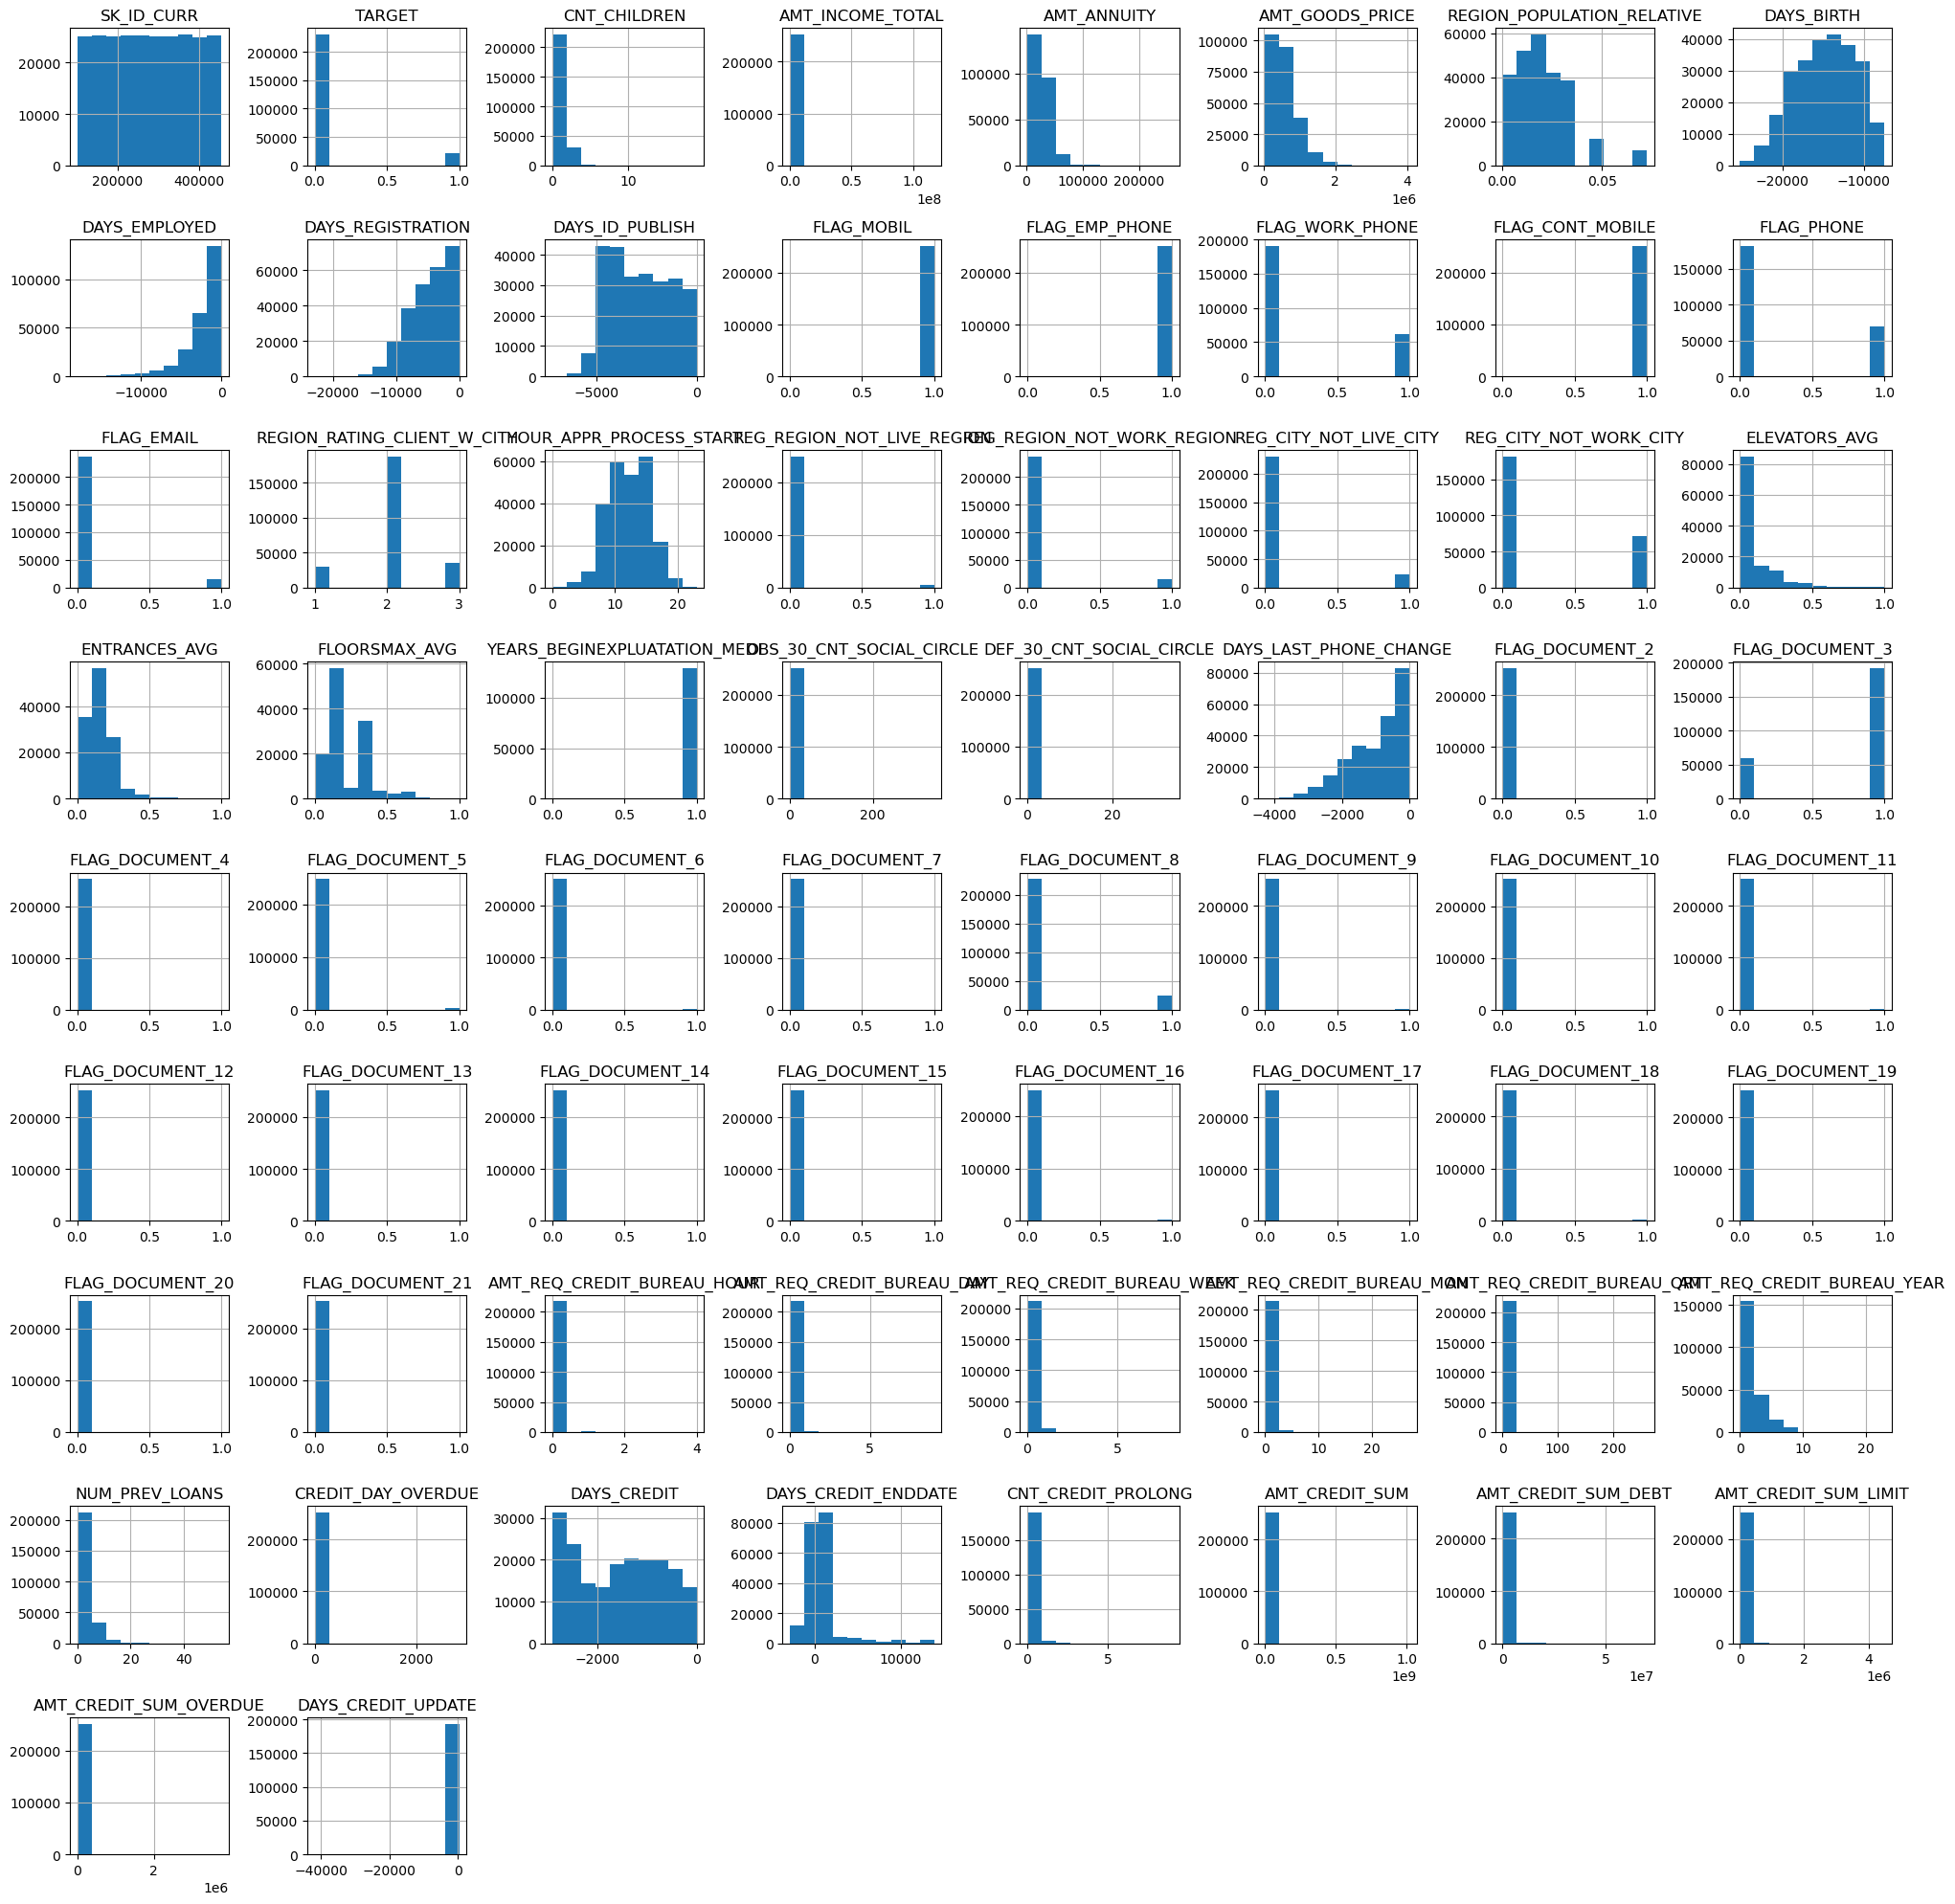

In [ ]:
print("="*80)
print("NUMERIC VARIABLES DISTRIBUTION - INDIVIDUAL CHARTS")
print("="*80)

# Get all numeric columns
numeric_var_merged = df_merged_cleaned.select_dtypes(include=['number']).columns.tolist()

# Remove columns that are already in categorical_columns
numeric_var_filtered = [col for col in numeric_var_merged if col not in categorical_columns]

print(f"Total numeric columns to visualize: {len(numeric_var_filtered)}\n")

# Visualize each numeric variable individually
for idx, col in enumerate(numeric_var_filtered, 1):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create histogram
    df_merged_cleaned[col].hist(ax=ax, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    
    # Customize plot
    ax.set_title(f'[{idx}/{len(numeric_var_filtered)}] Distribution of {col}', 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Value', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add statistics
    mean = df_merged_cleaned[col].mean()
    median = df_merged_cleaned[col].median()
    std = df_merged_cleaned[col].std()
    
    ax.axvline(mean, color='red', linestyle='--', linewidth=2.5, label=f'Mean: {mean:.4f}')
    ax.axvline(median, color='green', linestyle='--', linewidth=2.5, label=f'Median: {median:.4f}')
    
    # Add stats box
    stats_text = (f"Count: {df_merged_cleaned[col].count():,.0f}\n"
                 f"Min: {df_merged_cleaned[col].min():.4f}\n"
                 f"Max: {df_merged_cleaned[col].max():.4f}\n"
                 f"Std Dev: {std:.4f}\n"
                 f"Missing: {df_merged_cleaned[col].isnull().sum():,.0f}")
    
    ax.text(0.98, 0.97, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    ax.legend(loc='upper left', fontsize=10)
    
    plt.tight_layout()
    plt.show()

print(f"\n✓ All {len(numeric_var_filtered)} visualizations complete!")

BOXPLOT DISTRIBUTION OF NUMERIC VARIABLES (INDIVIDUAL FIGURES)

Creating individual boxplots for 64 variables...



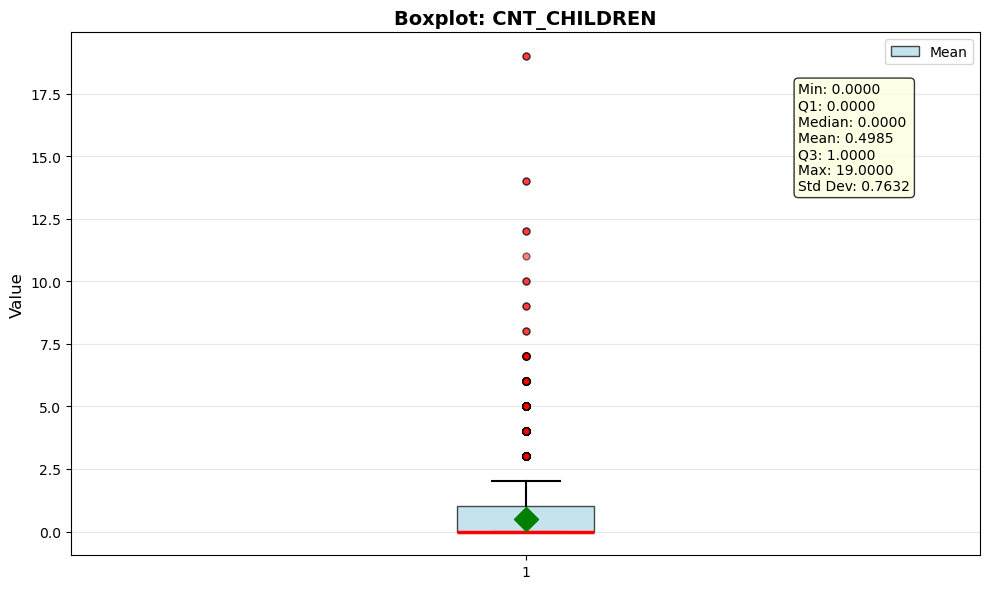

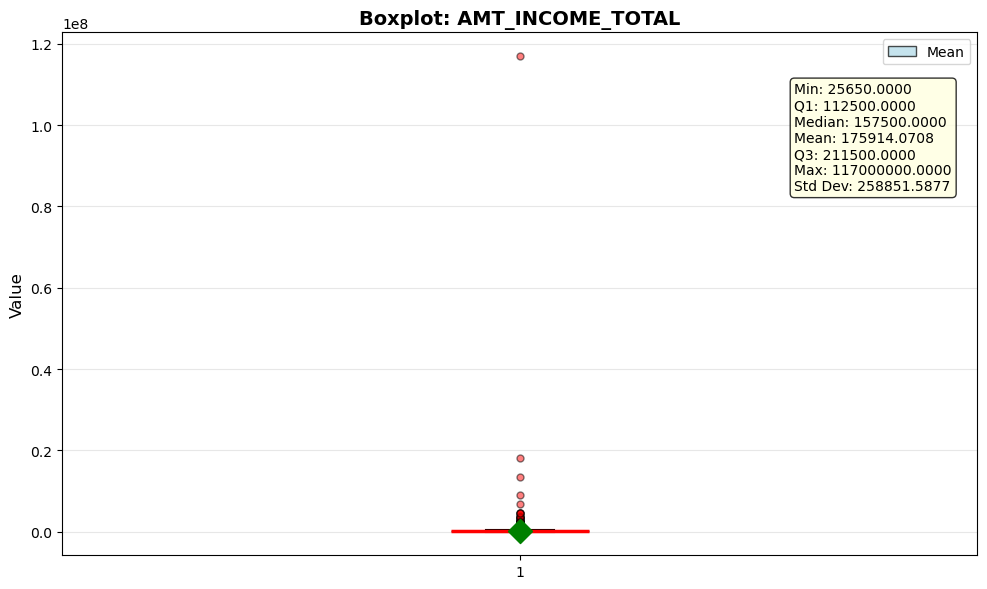

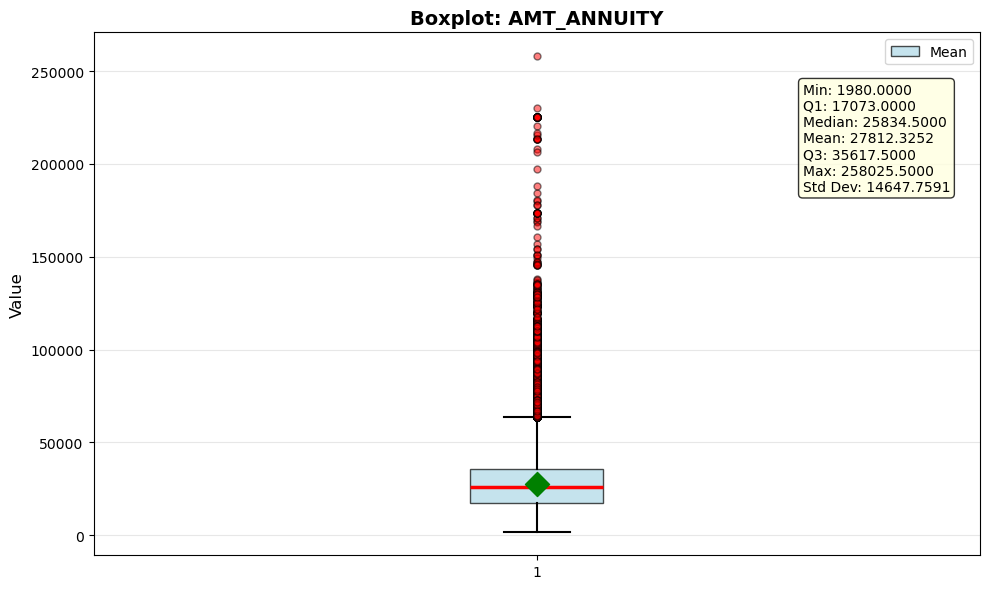

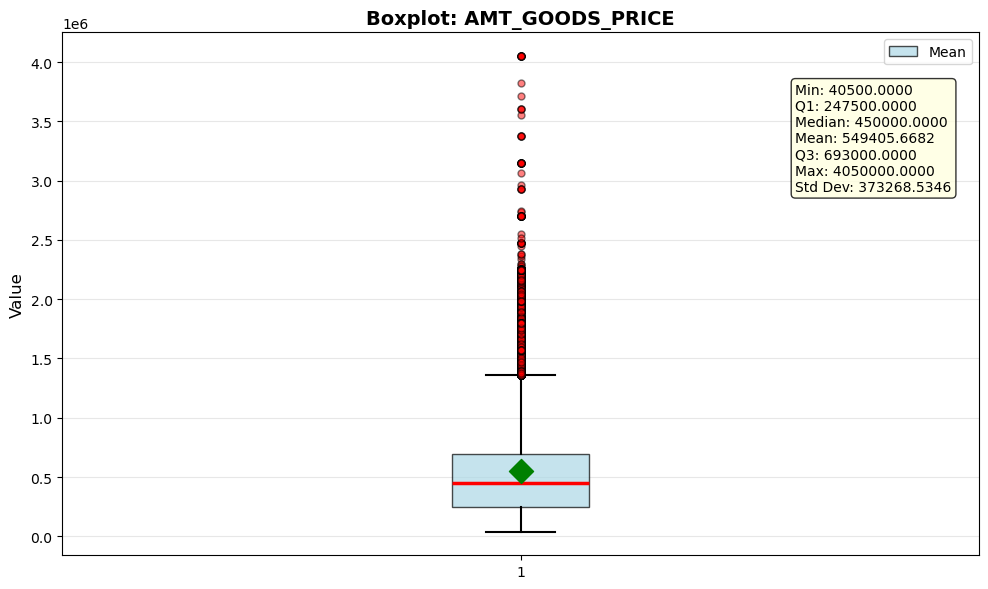

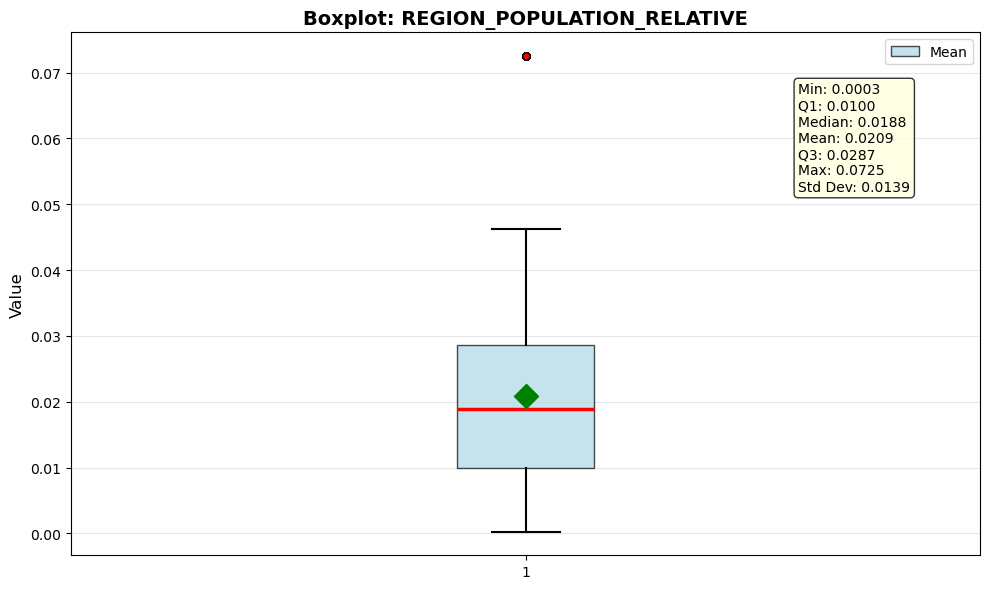

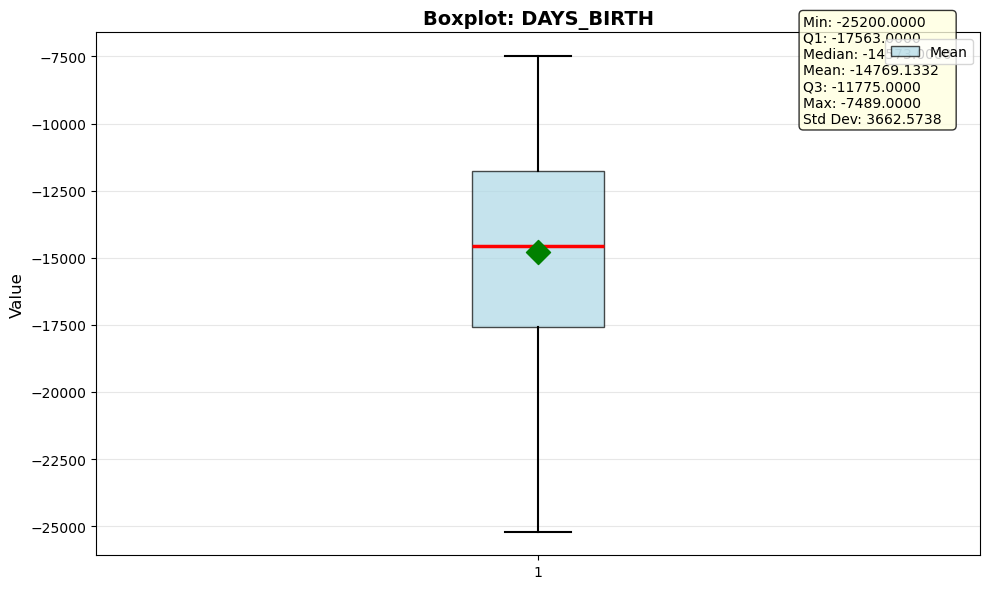

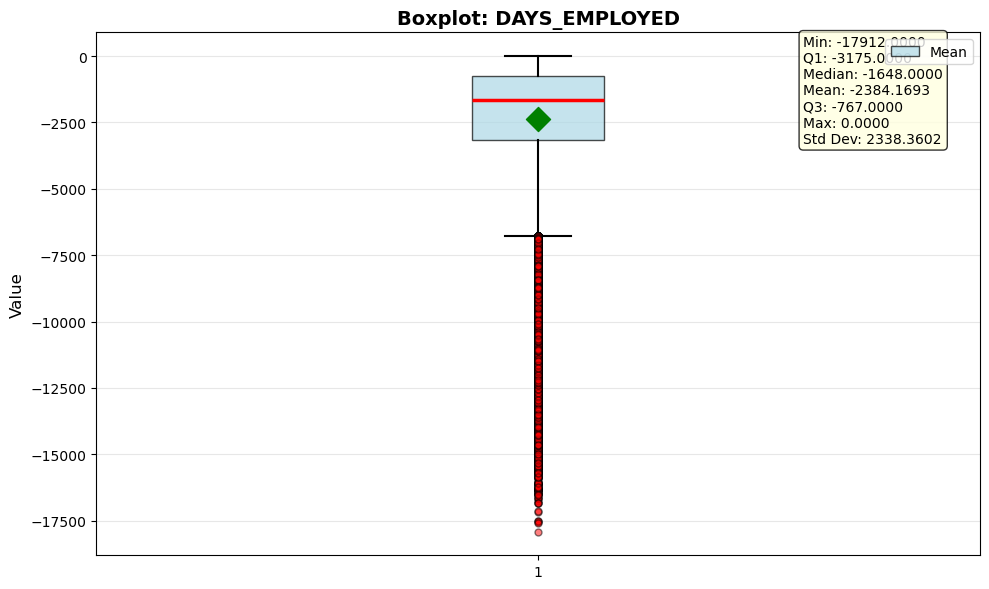

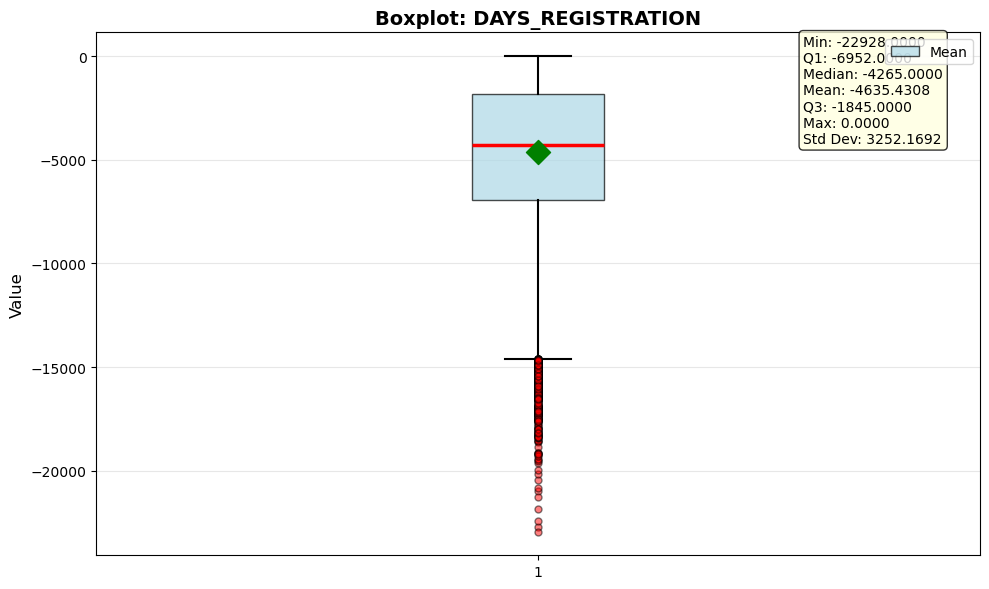

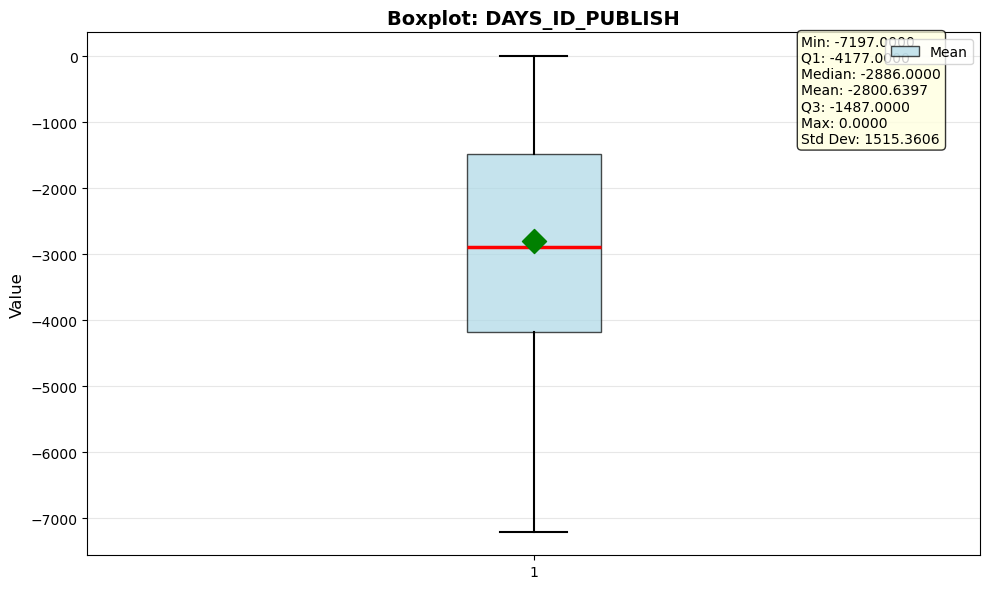

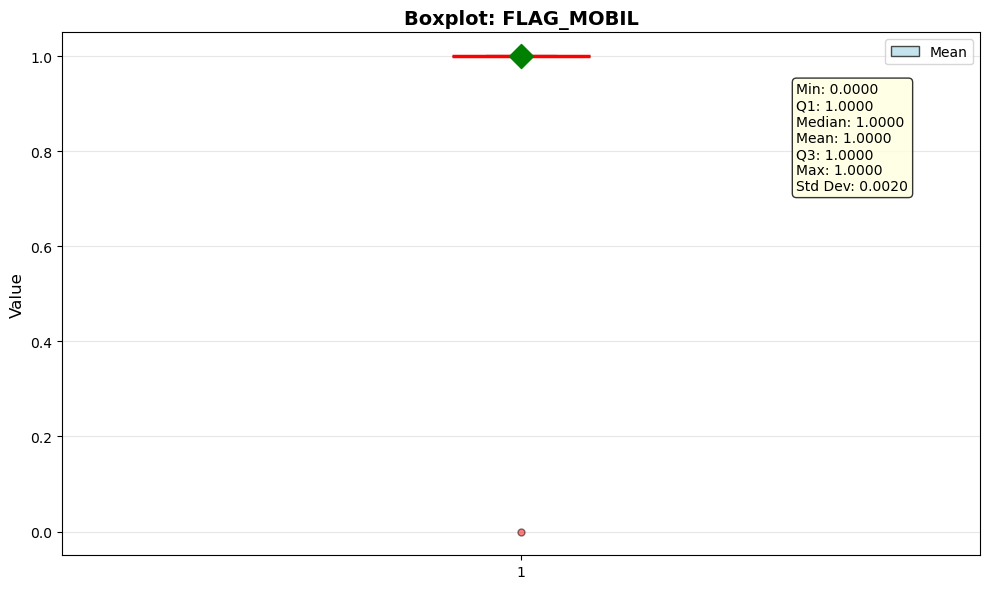

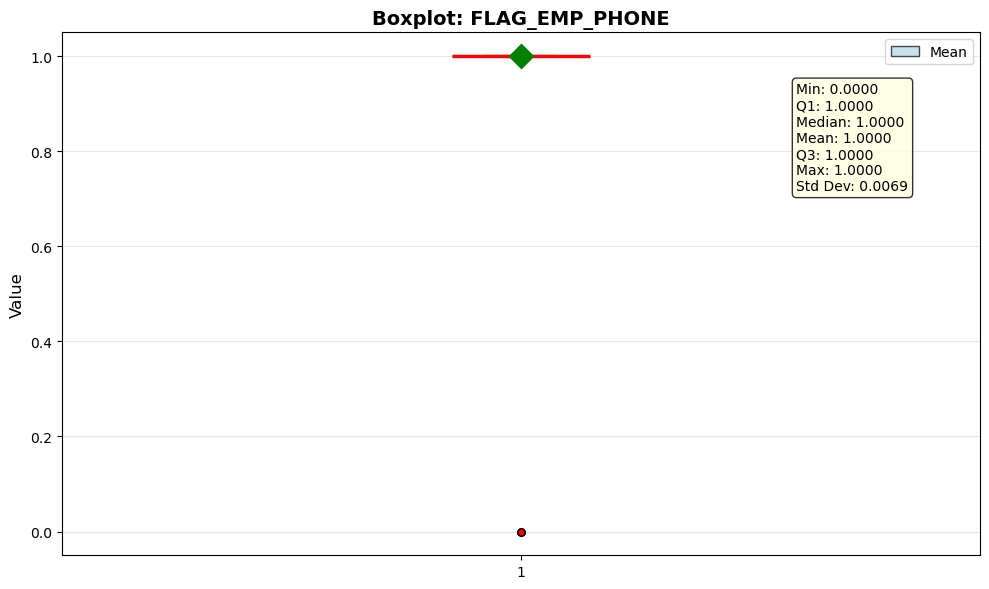

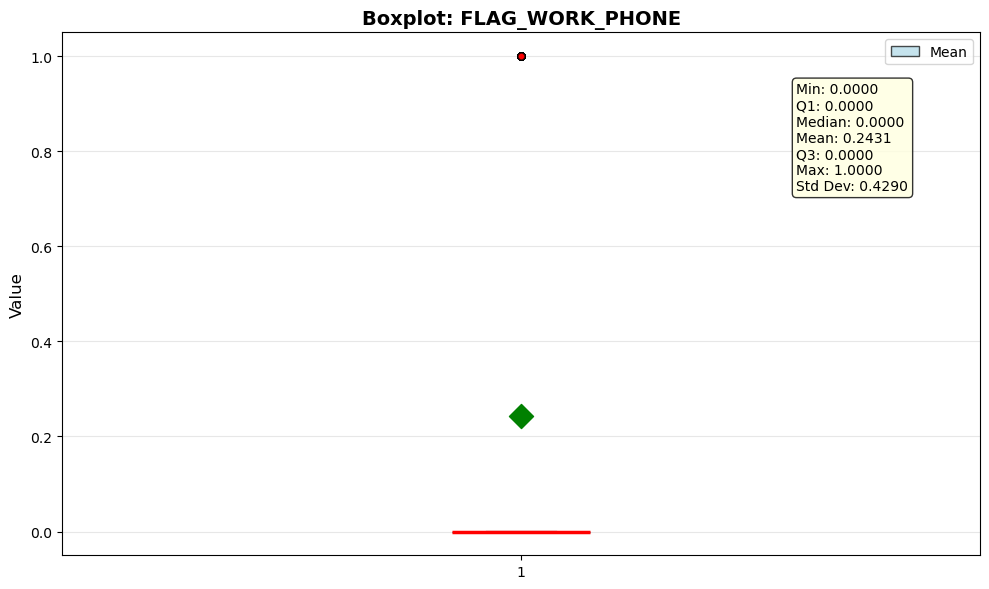

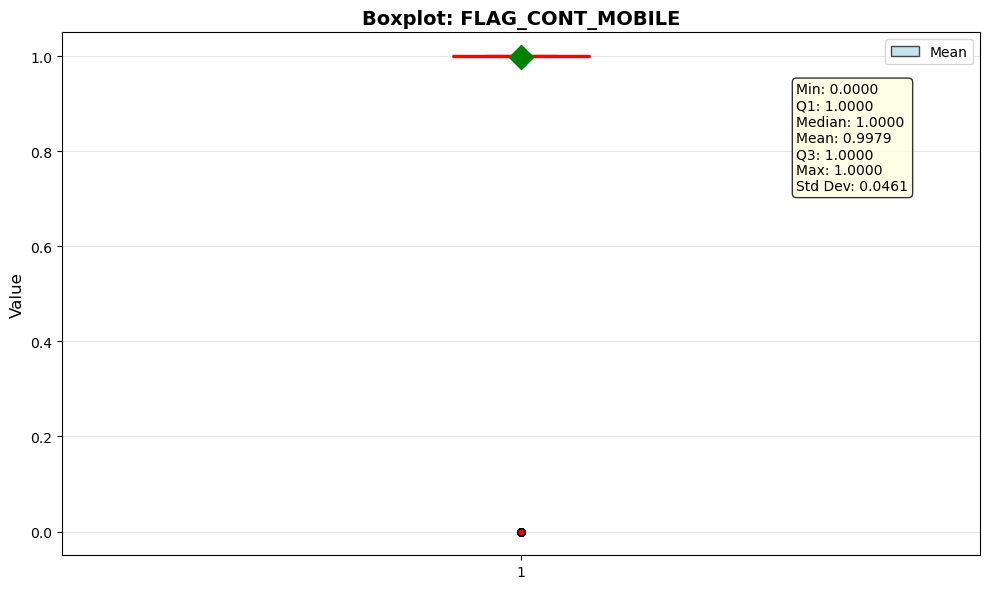

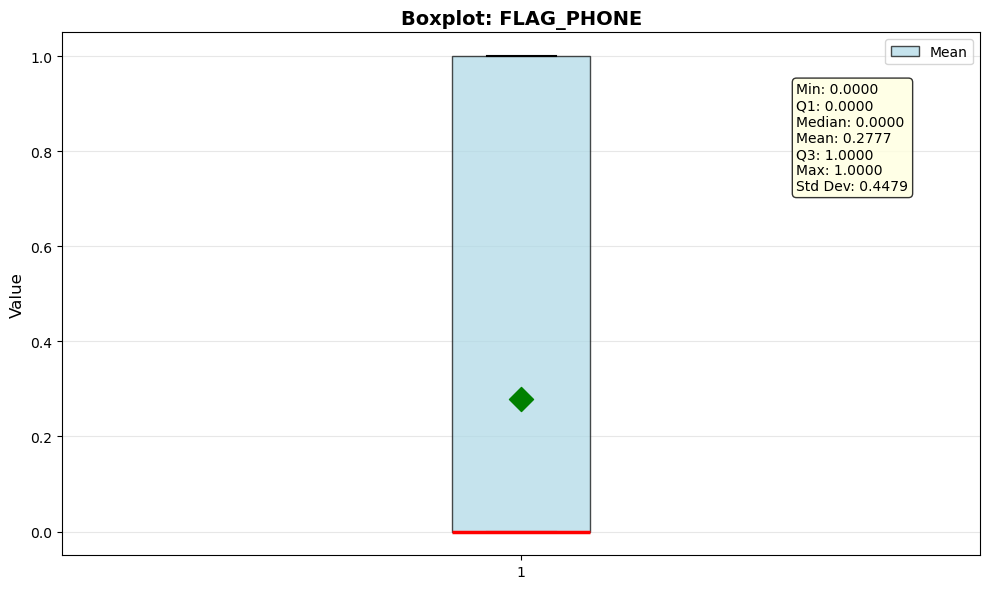

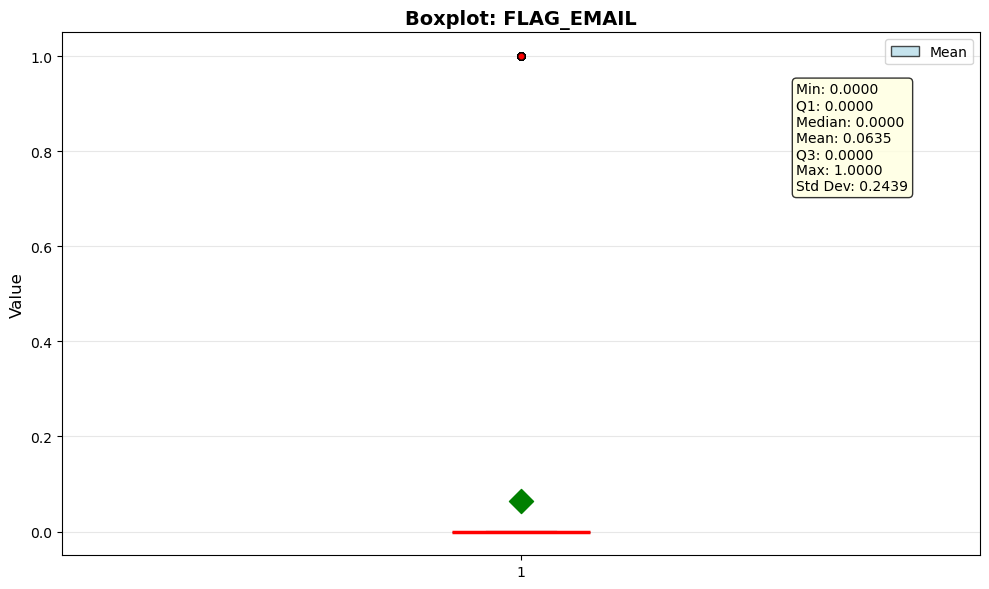

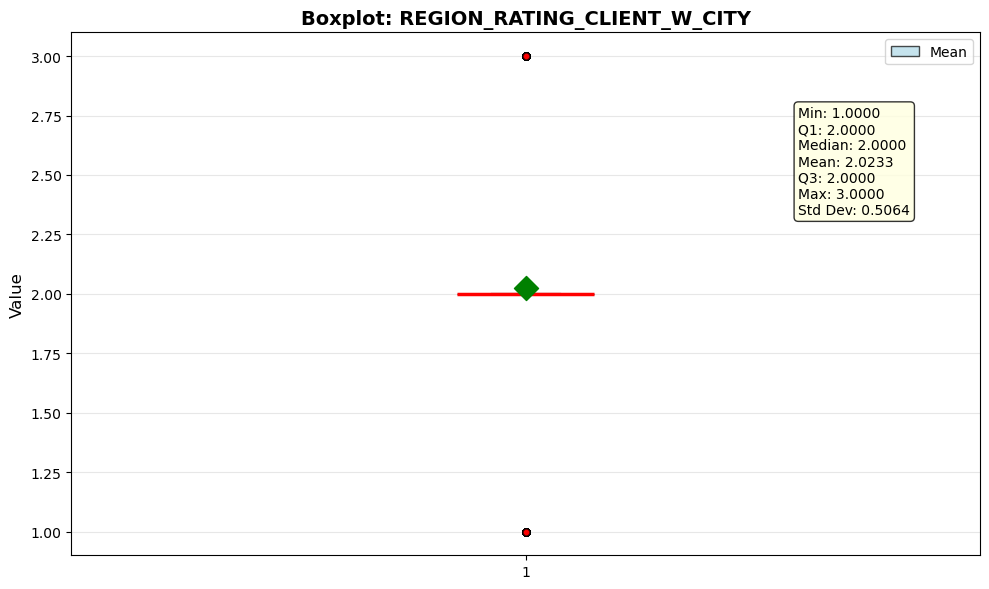

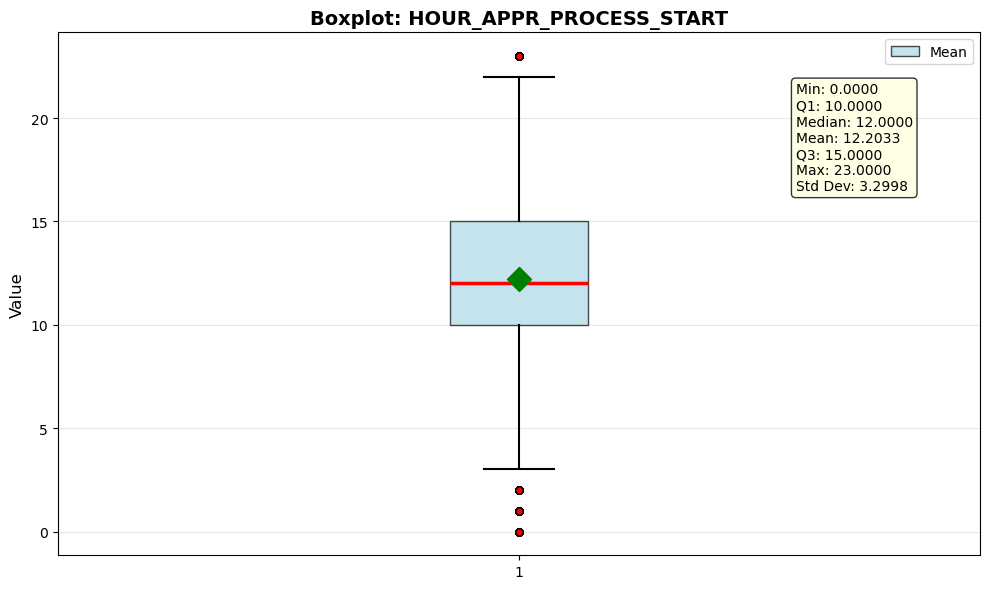

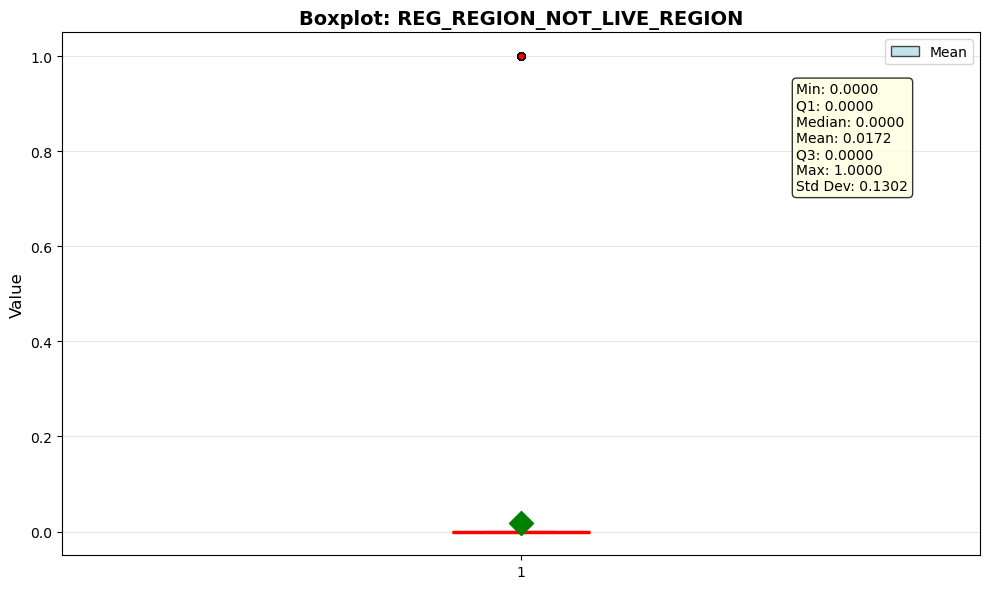

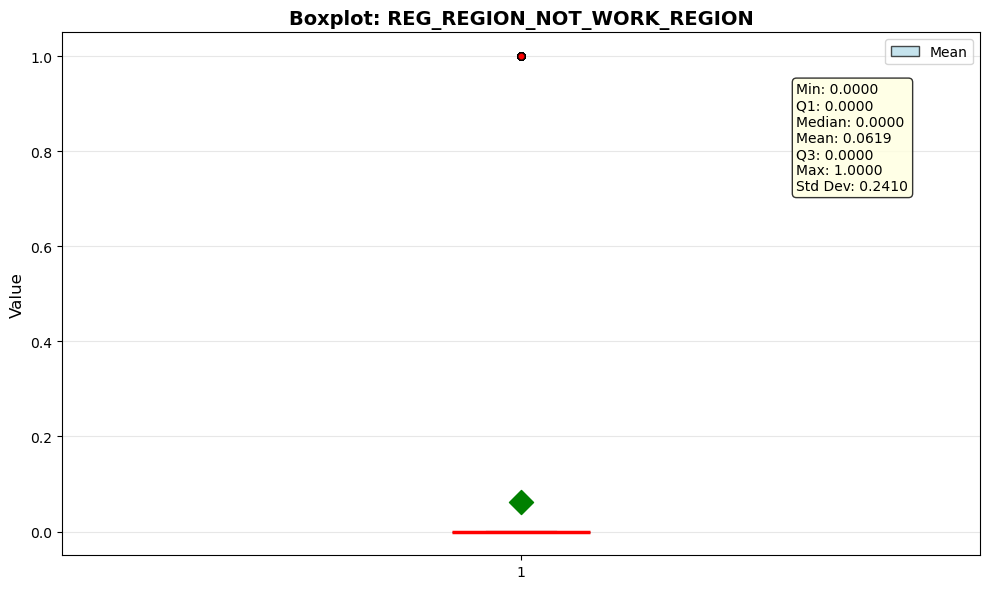

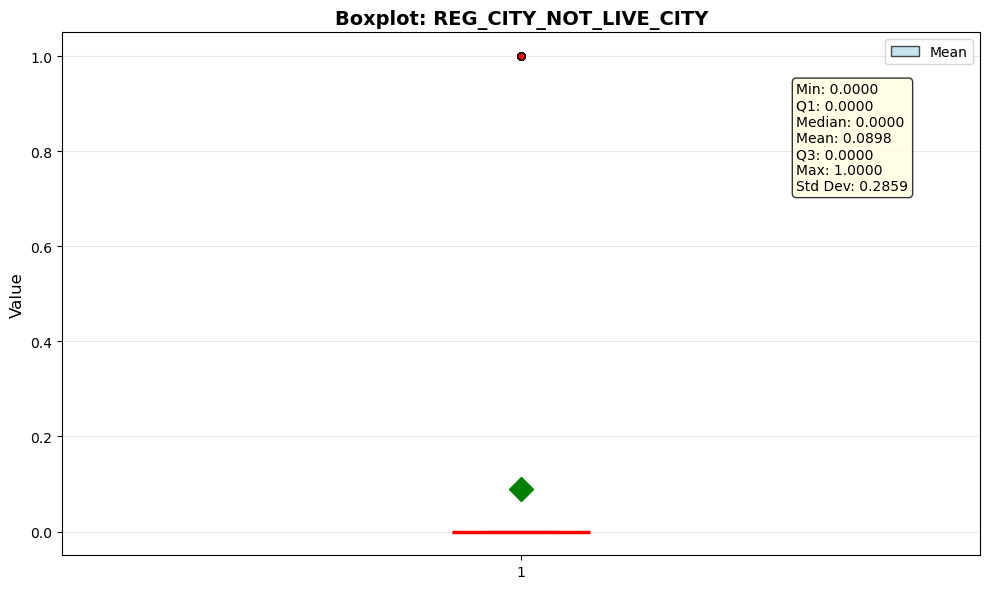

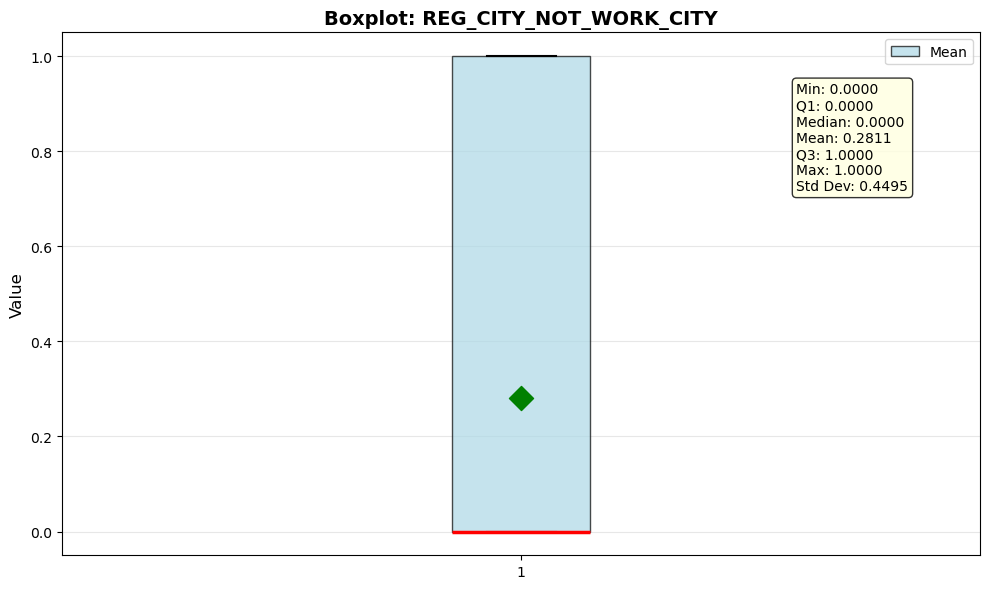

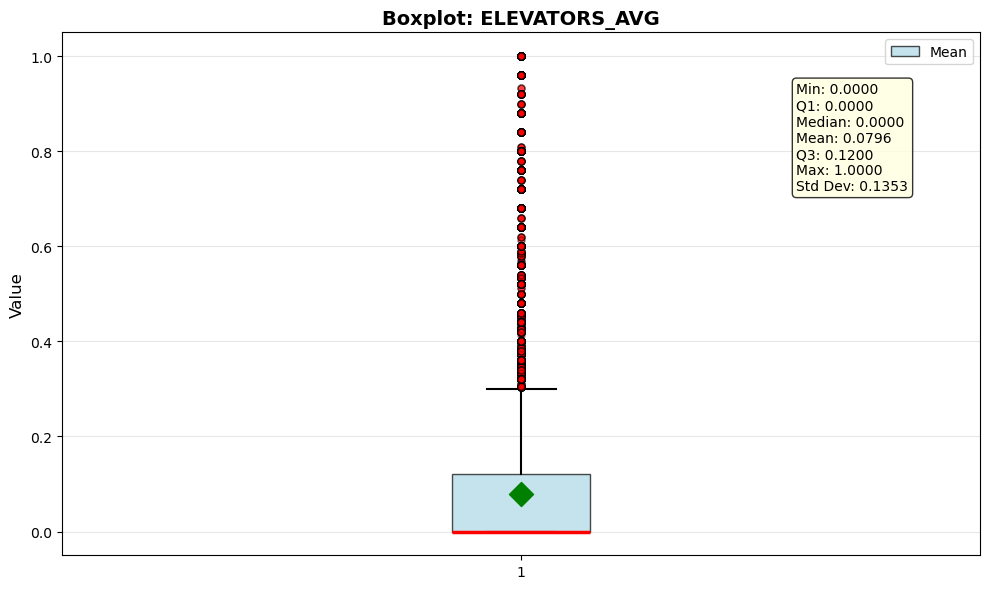

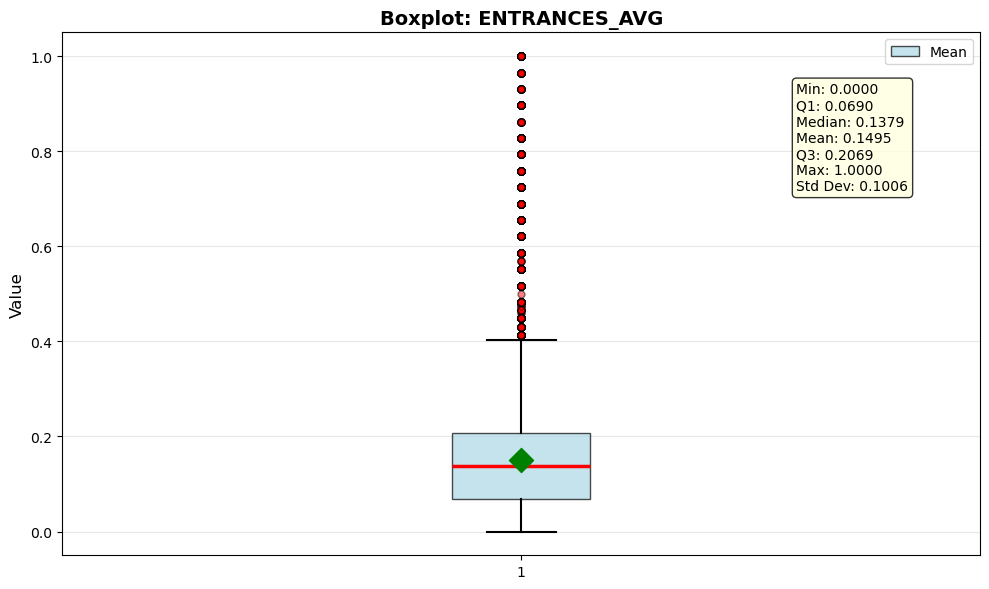

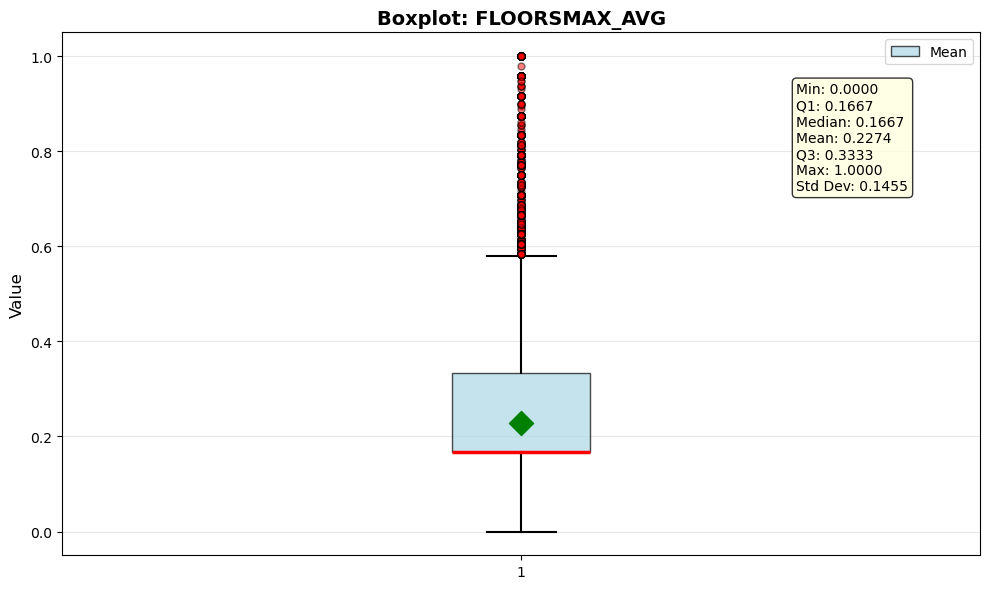

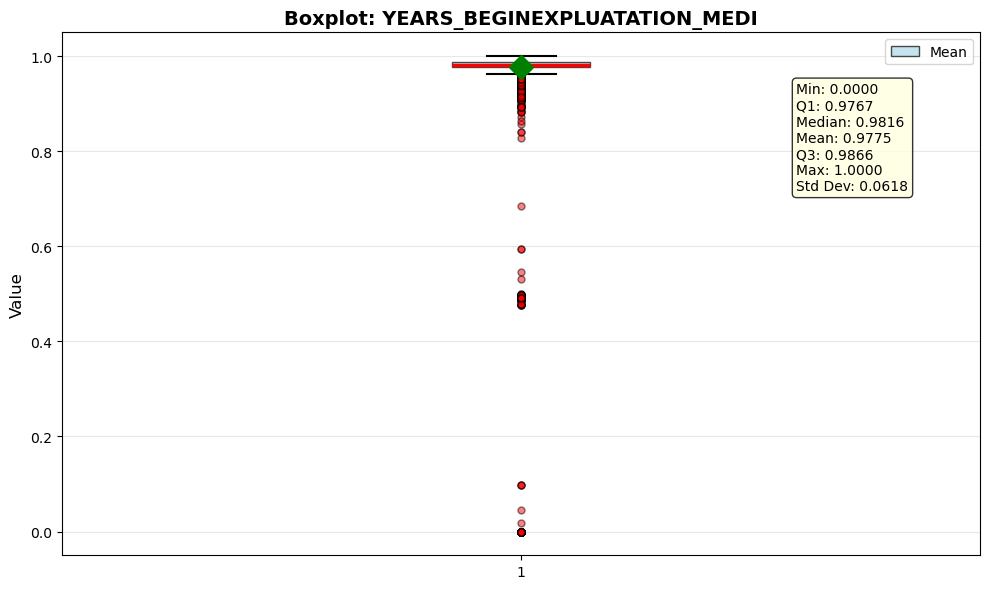

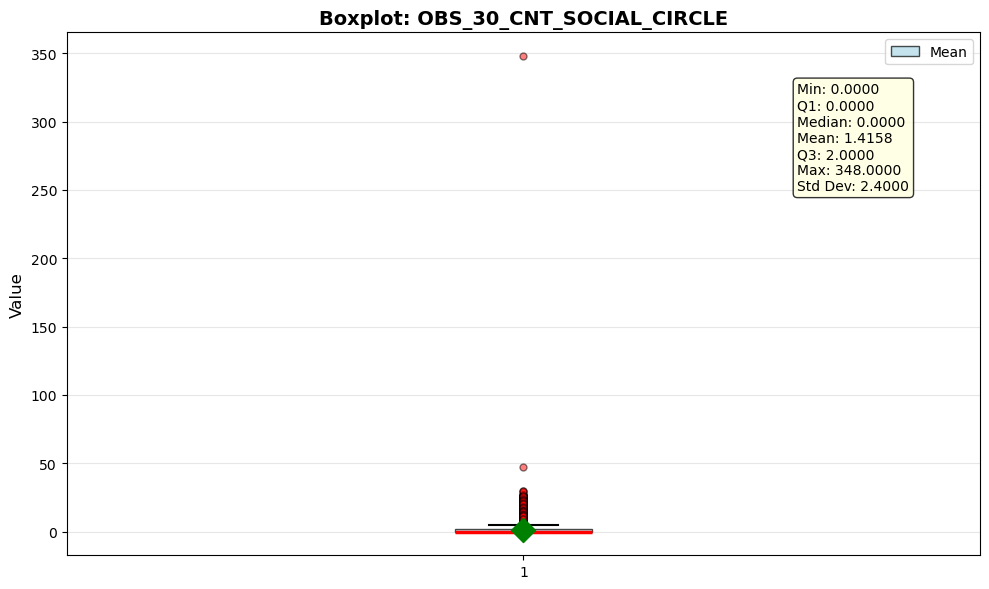

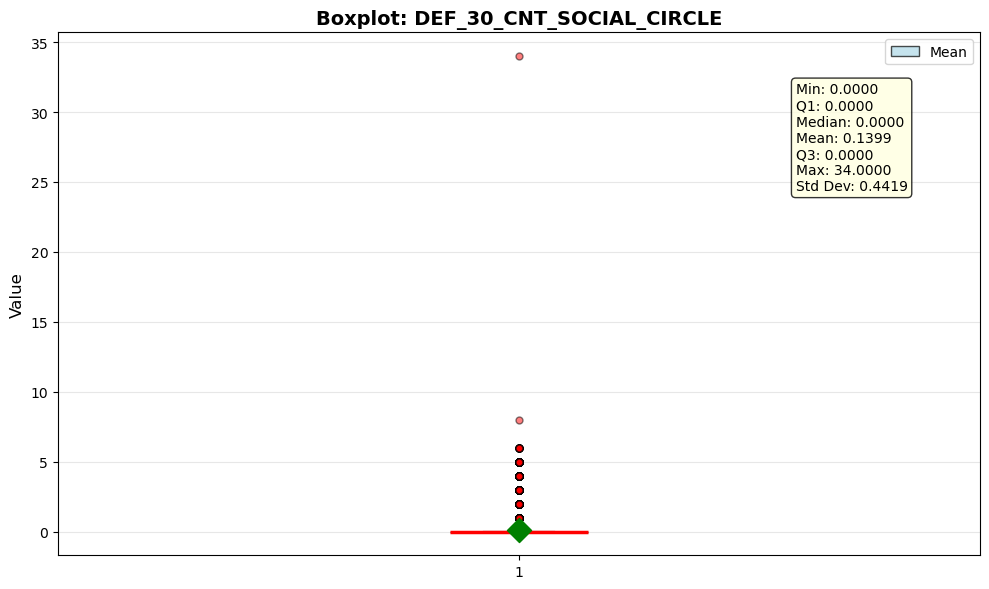

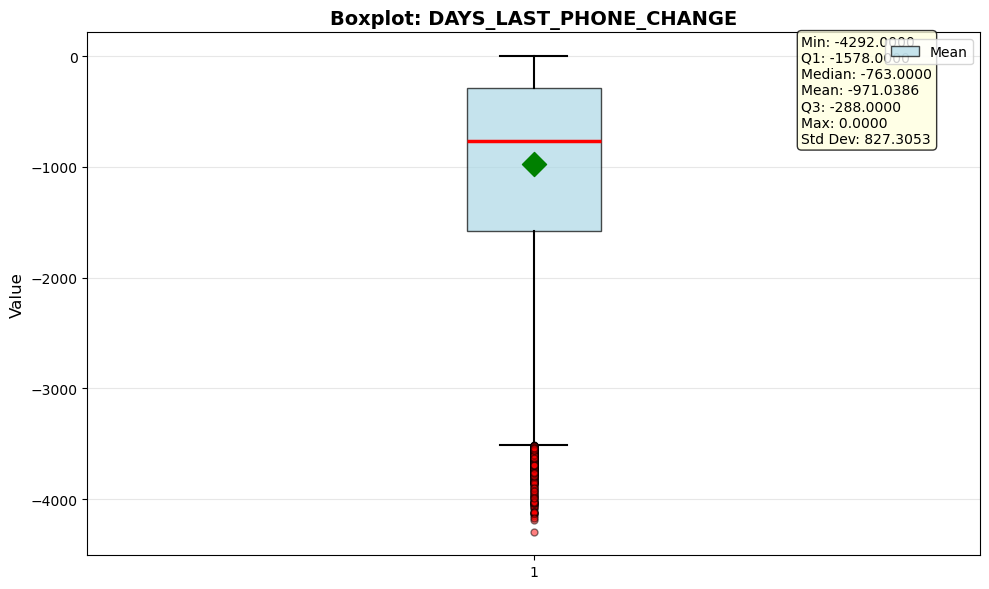

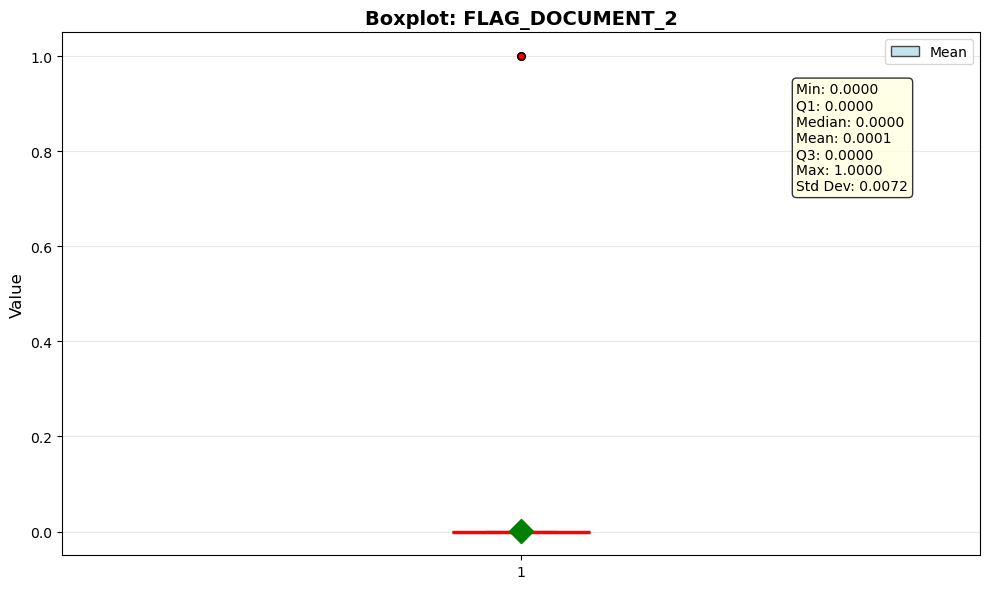

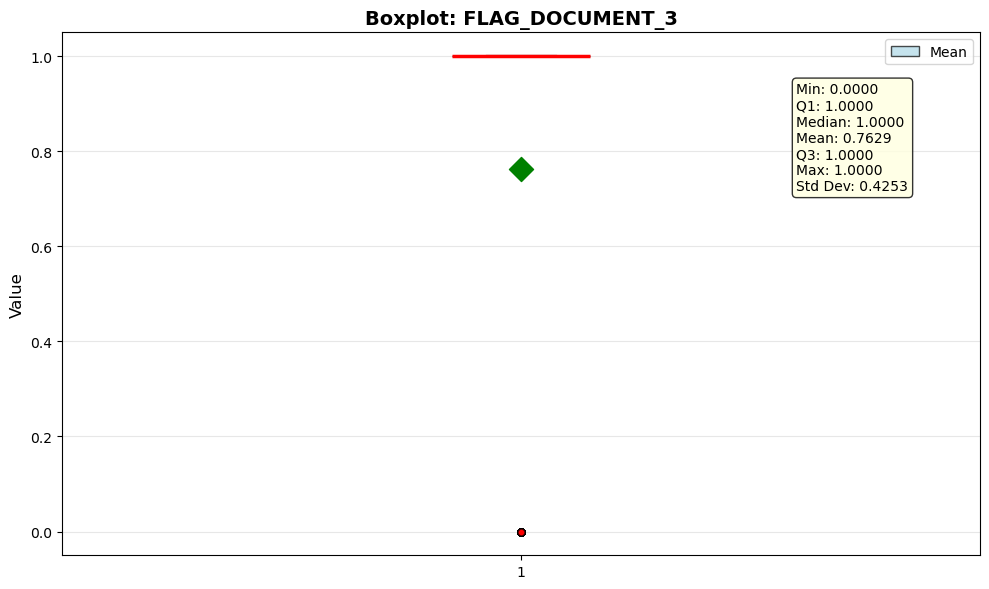

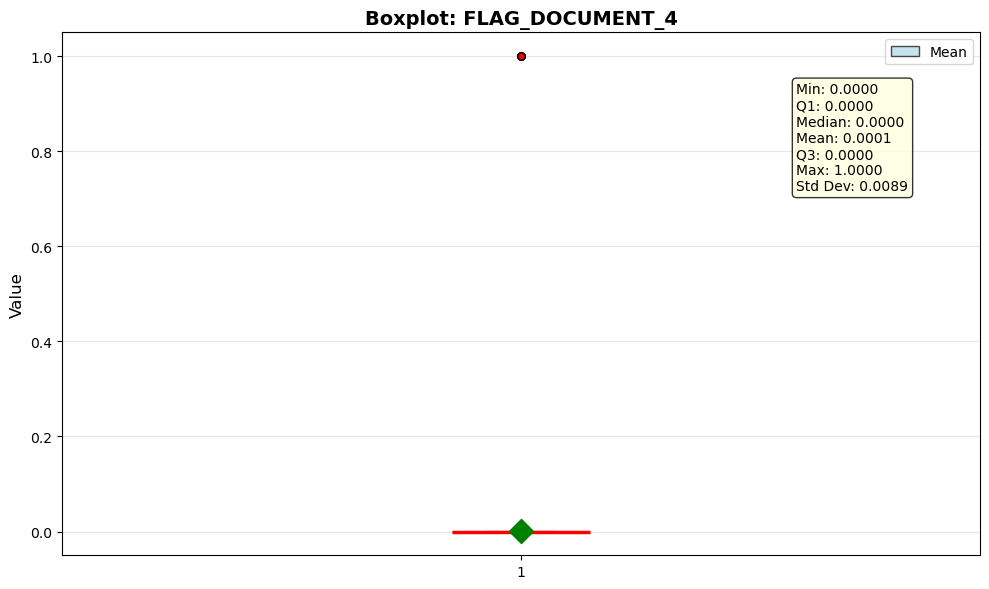

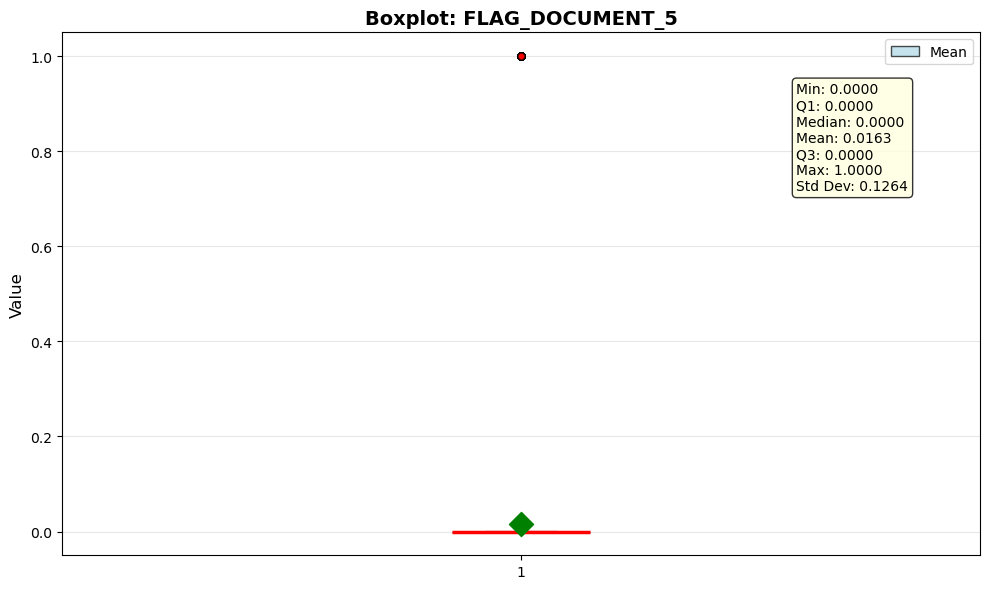

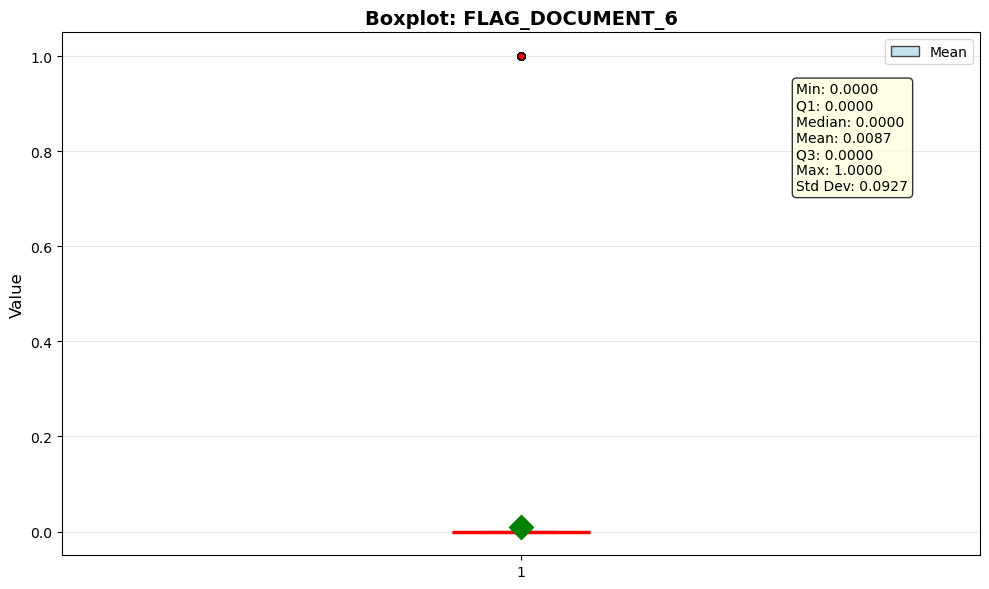

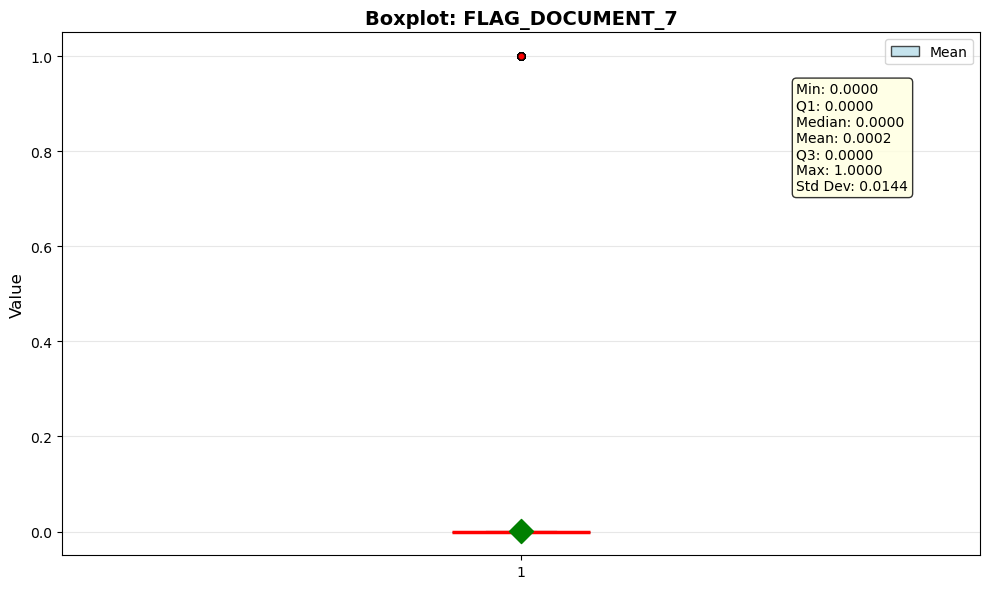

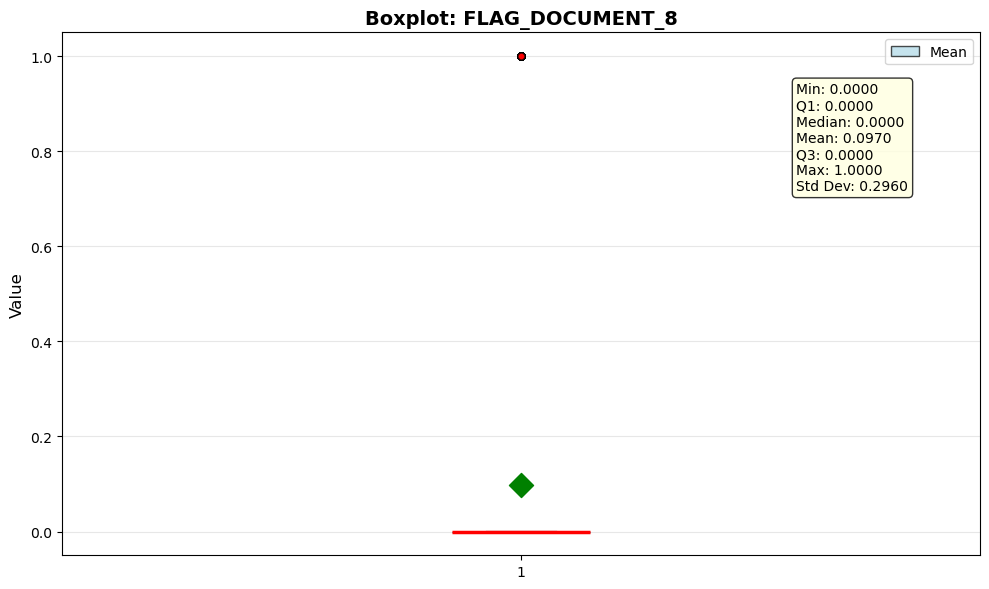

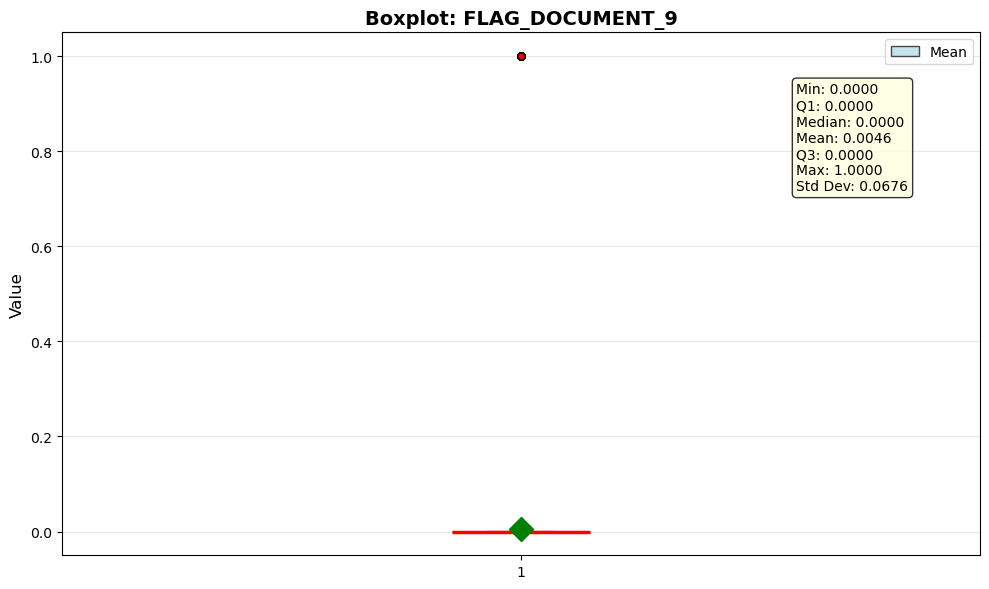

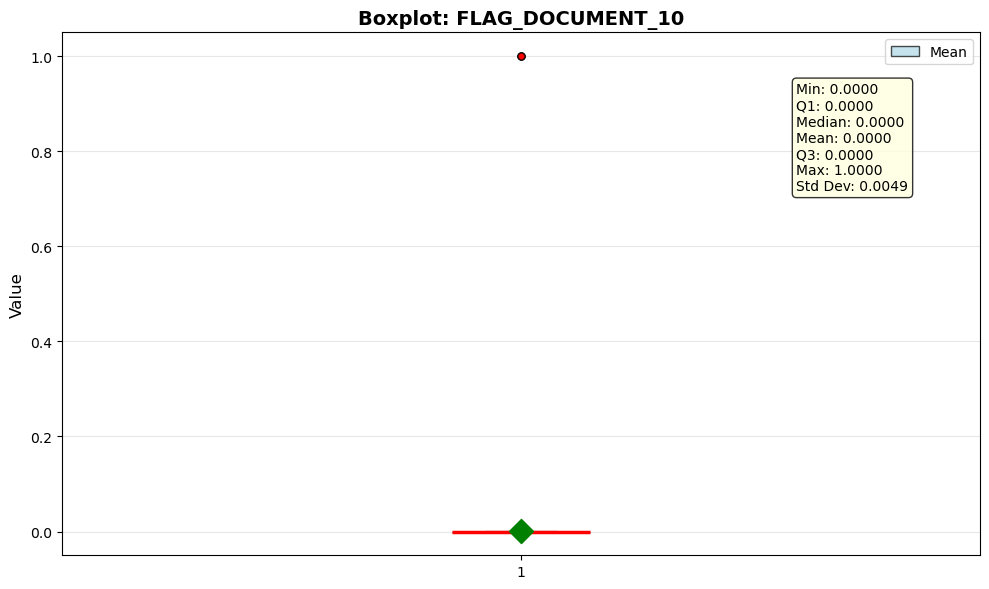

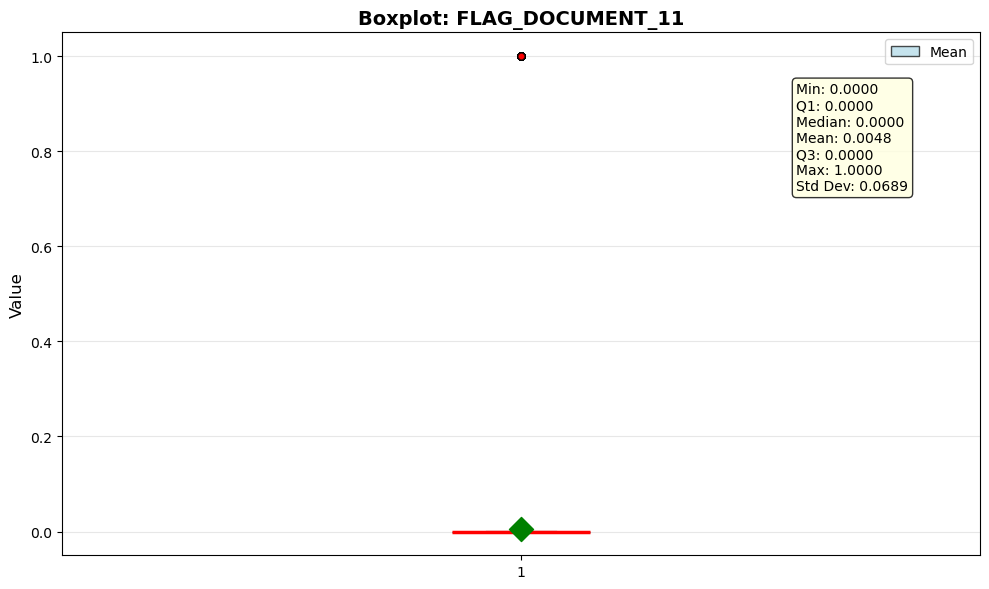

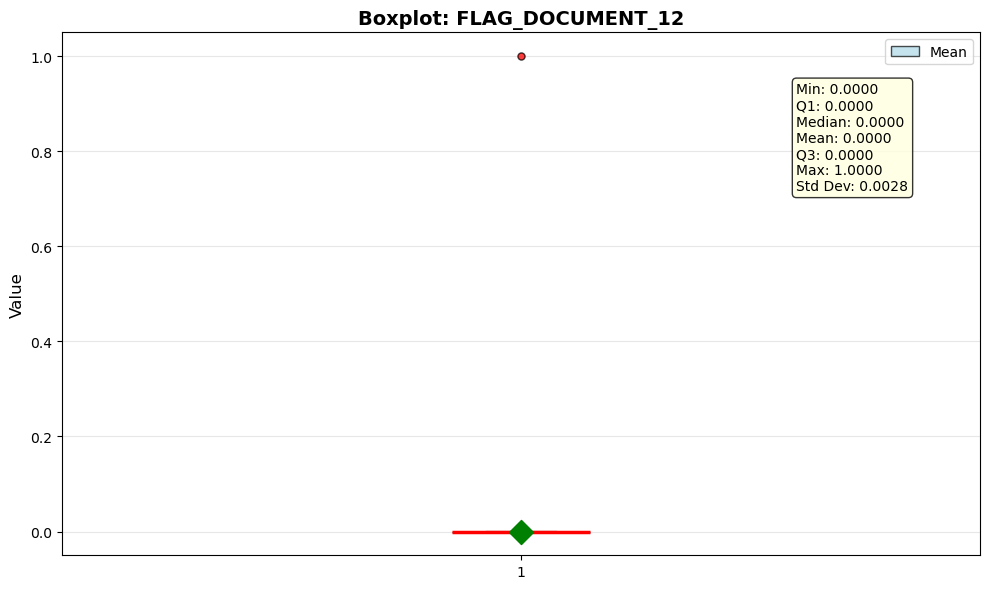

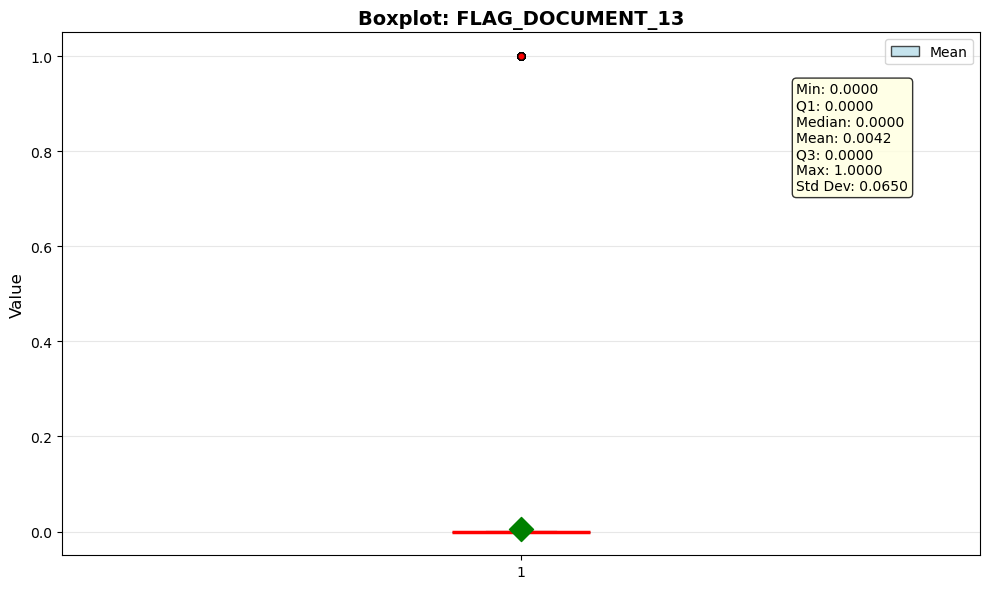

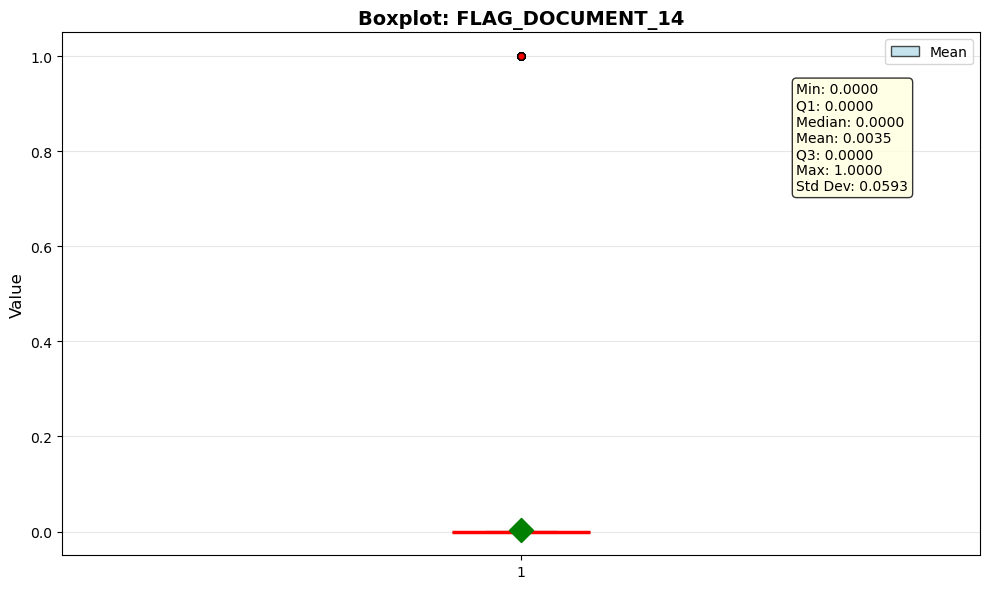

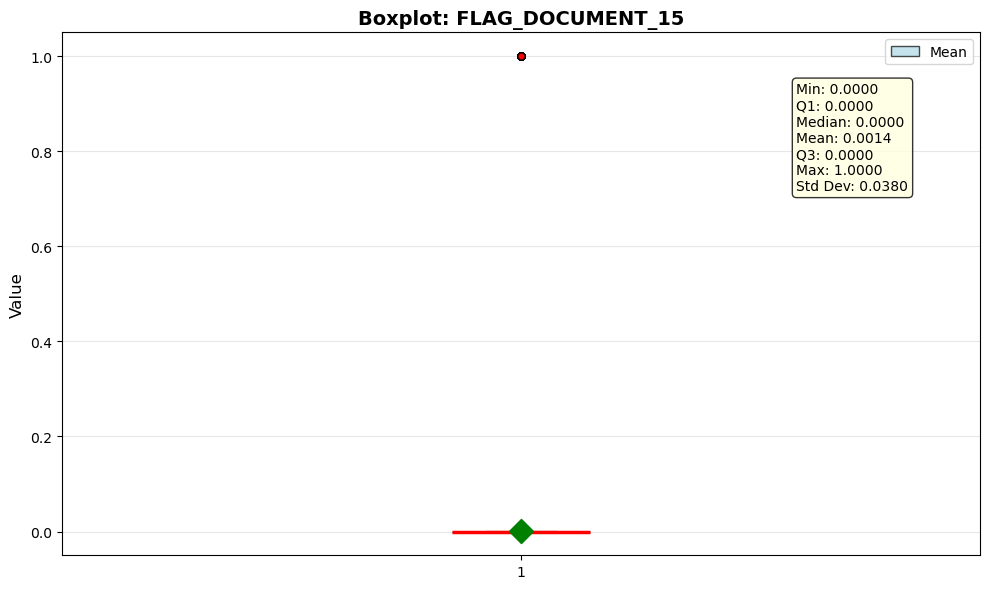

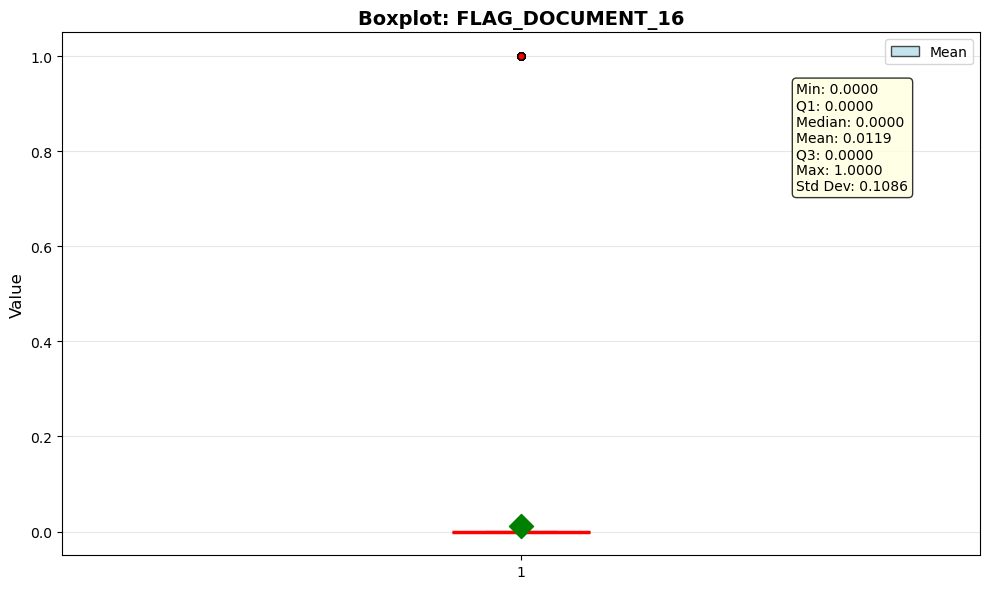

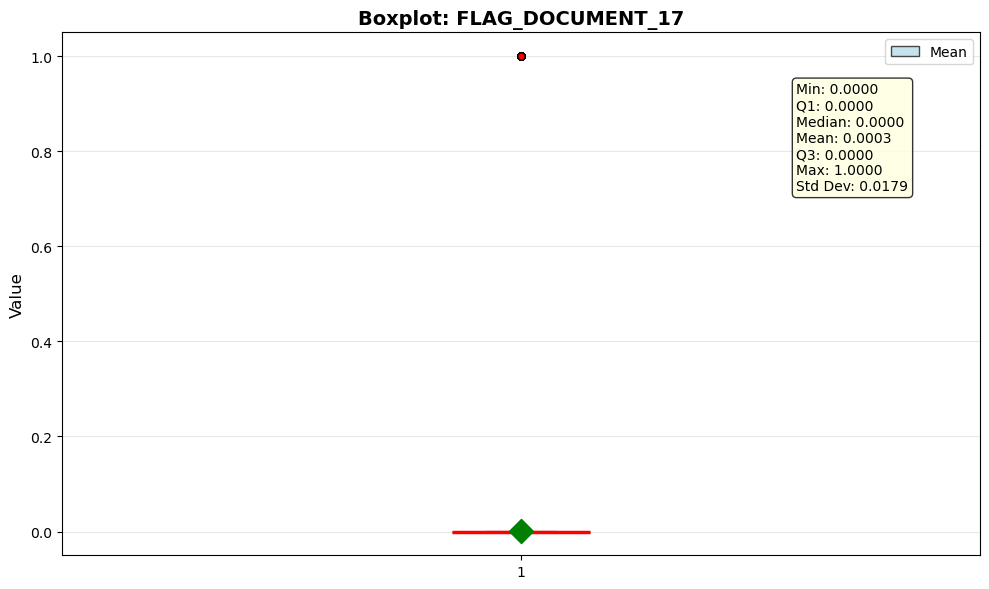

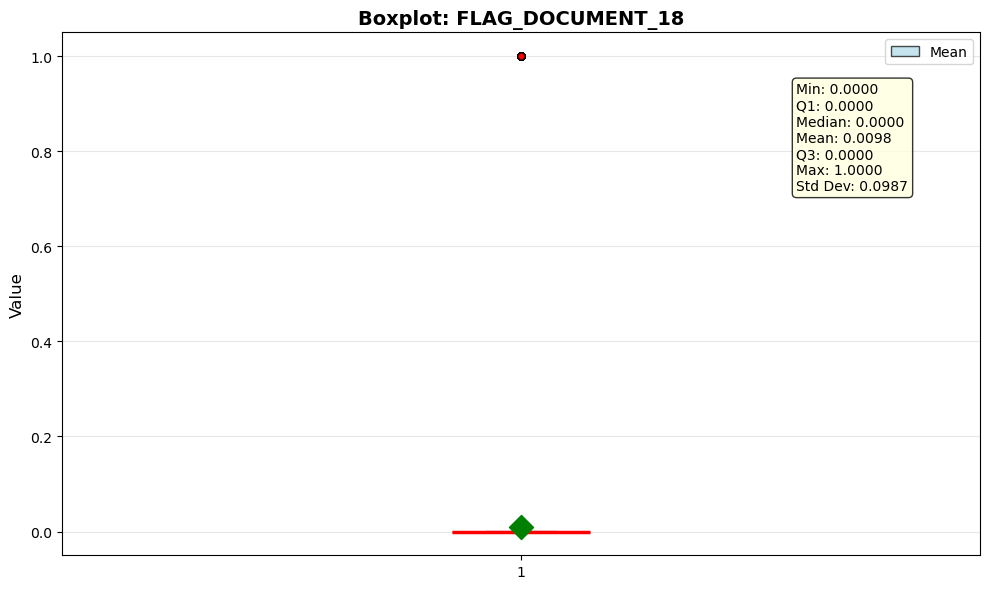

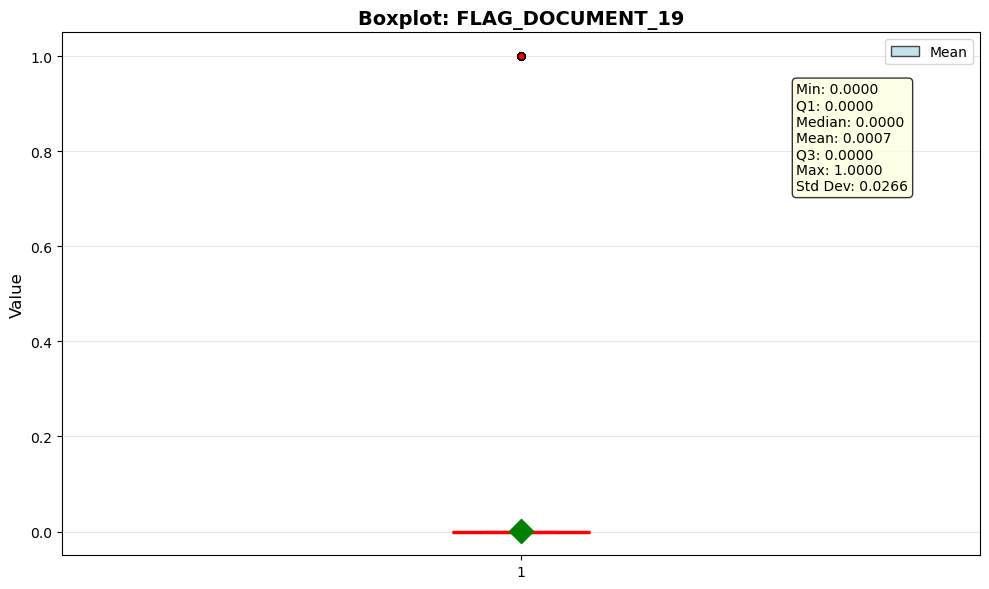

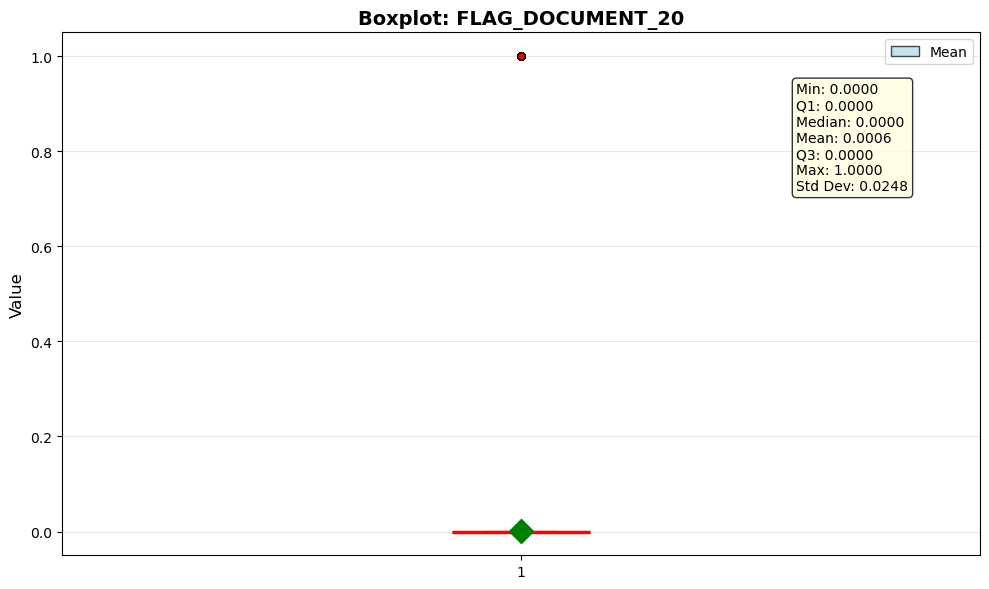

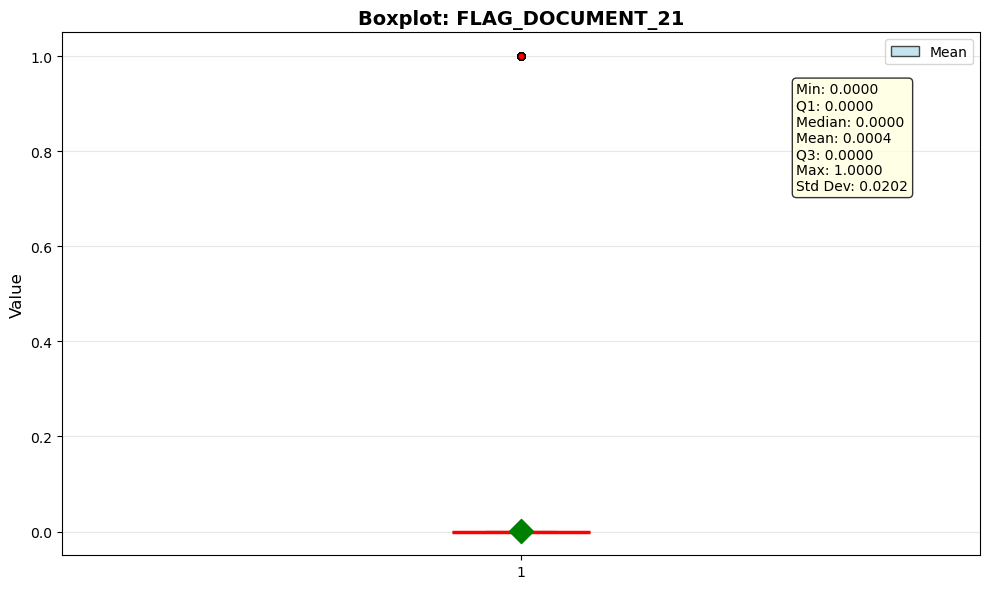

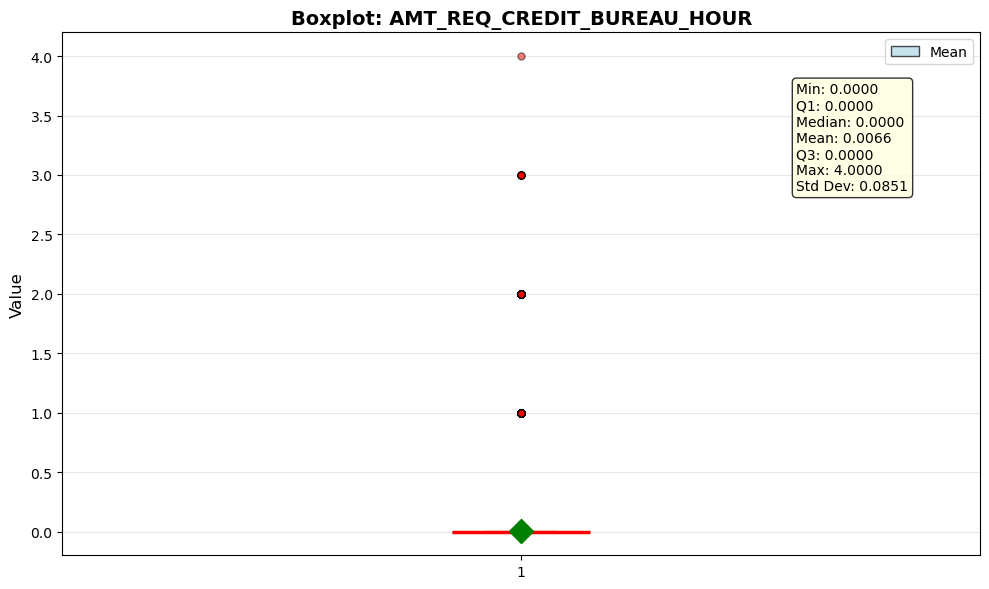

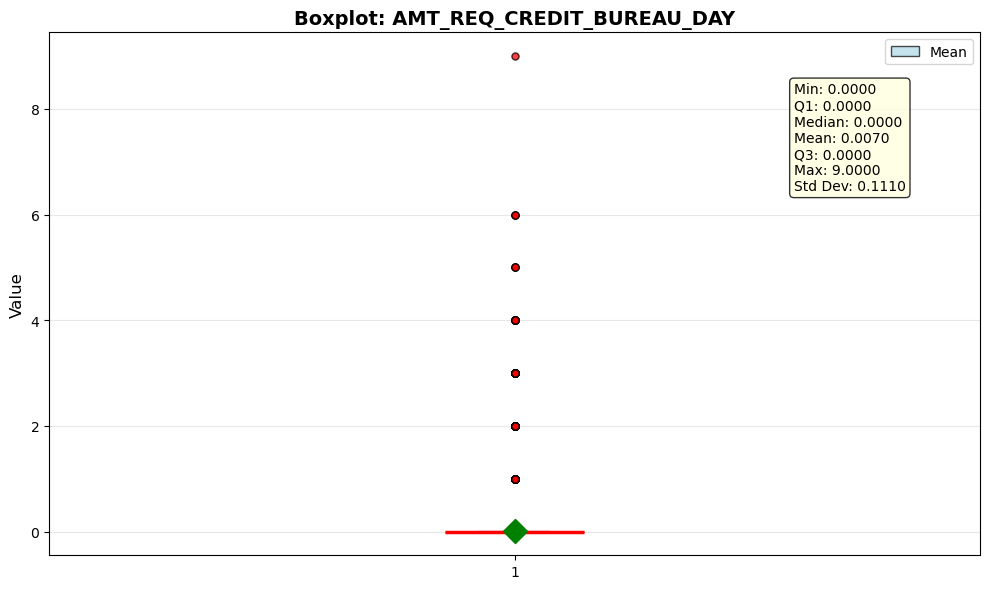

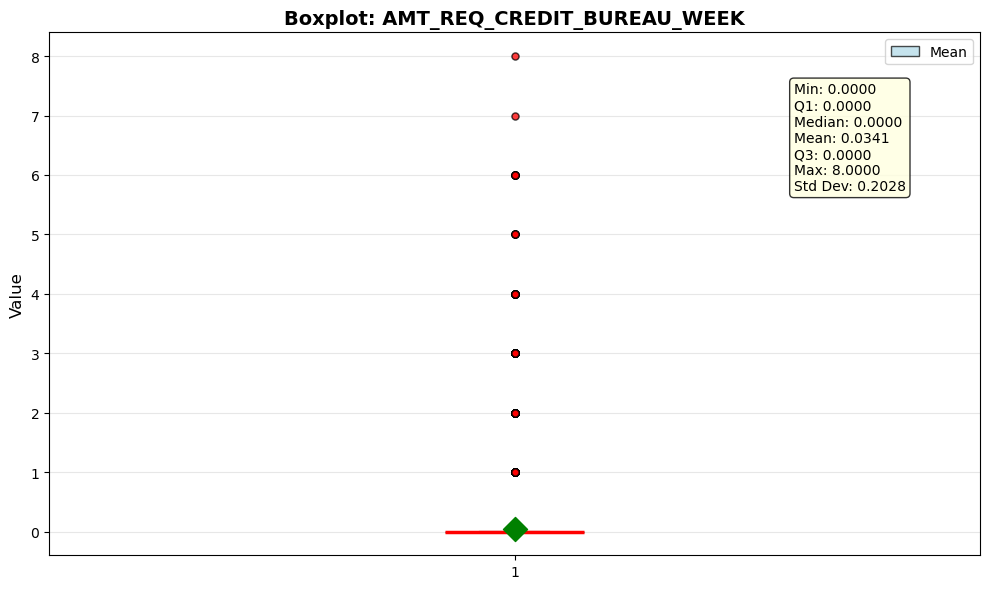

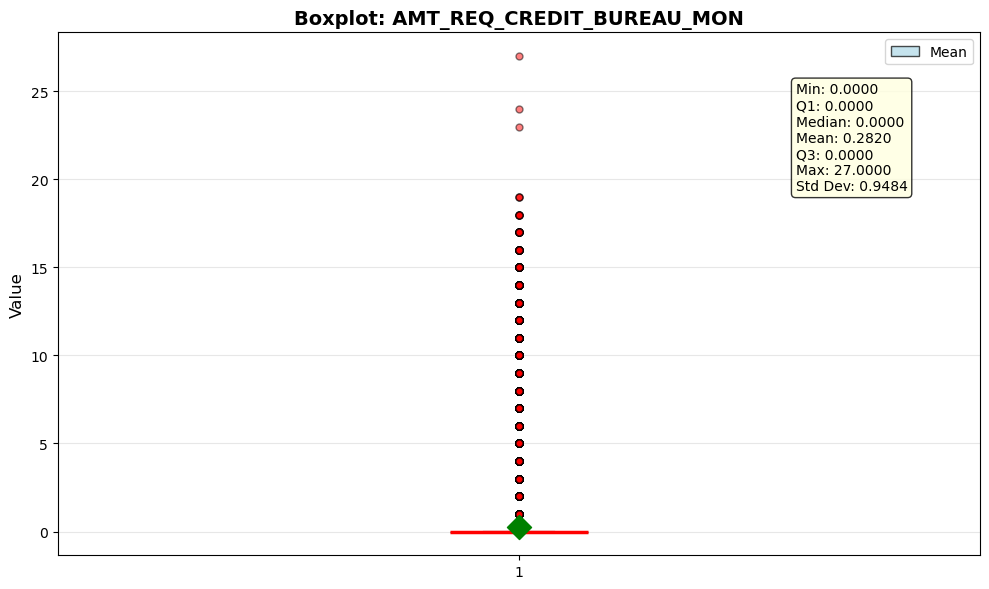

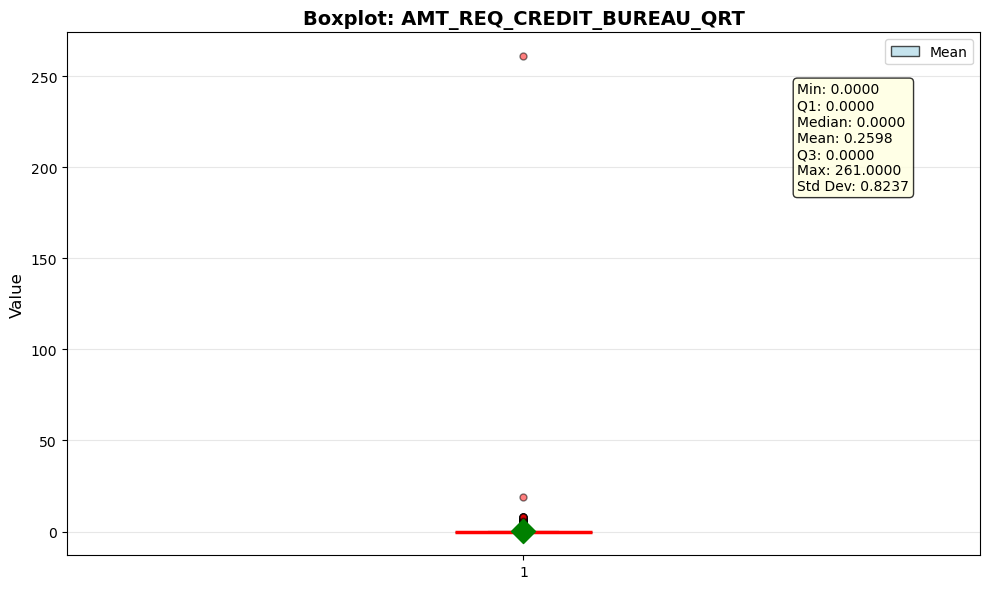

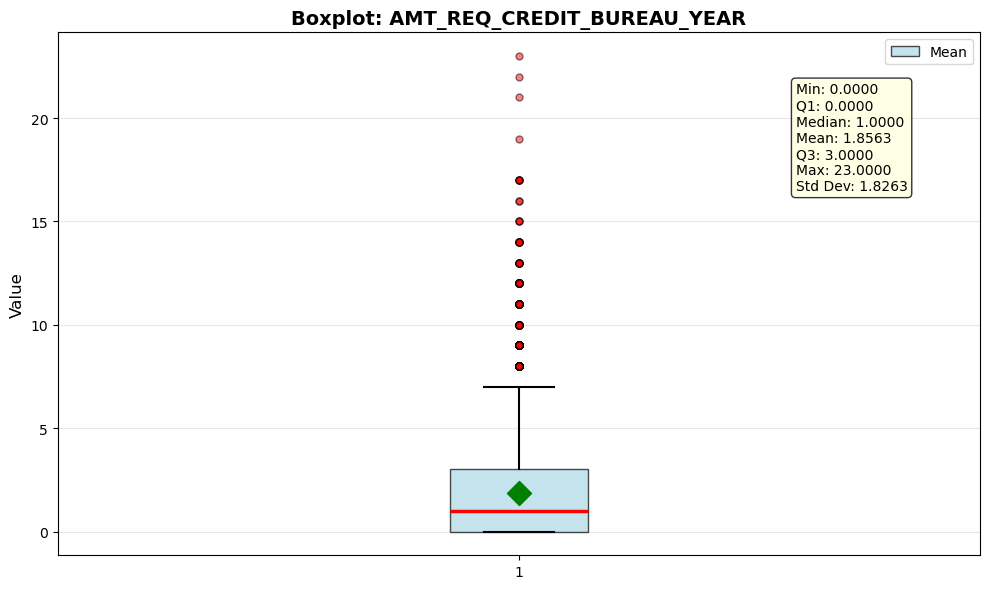

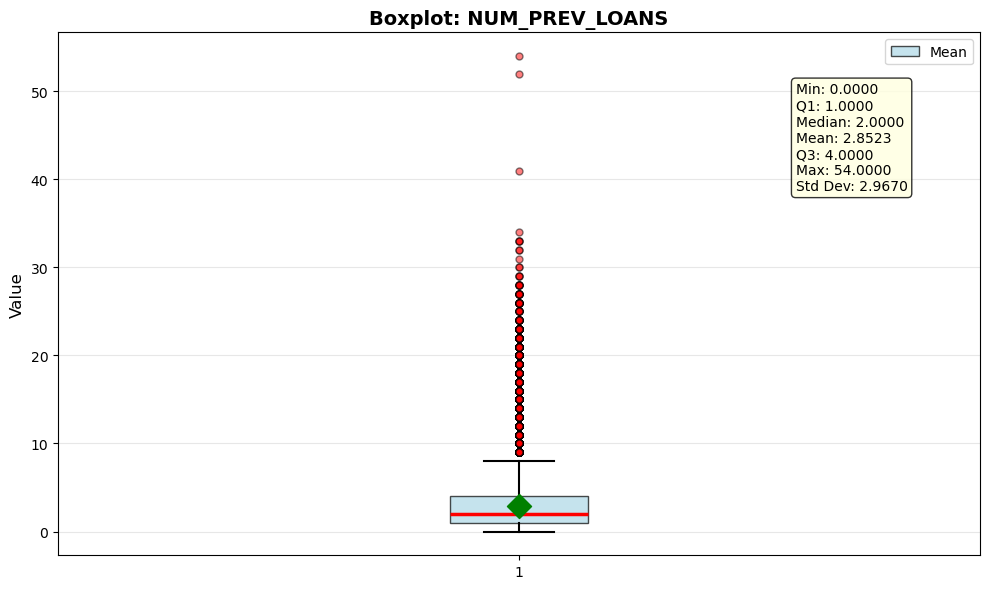

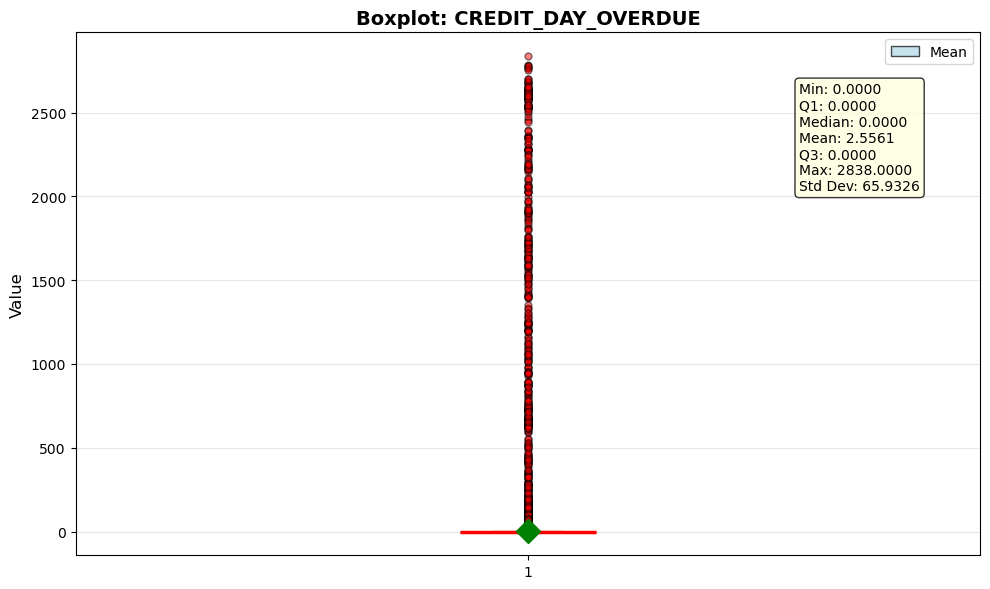

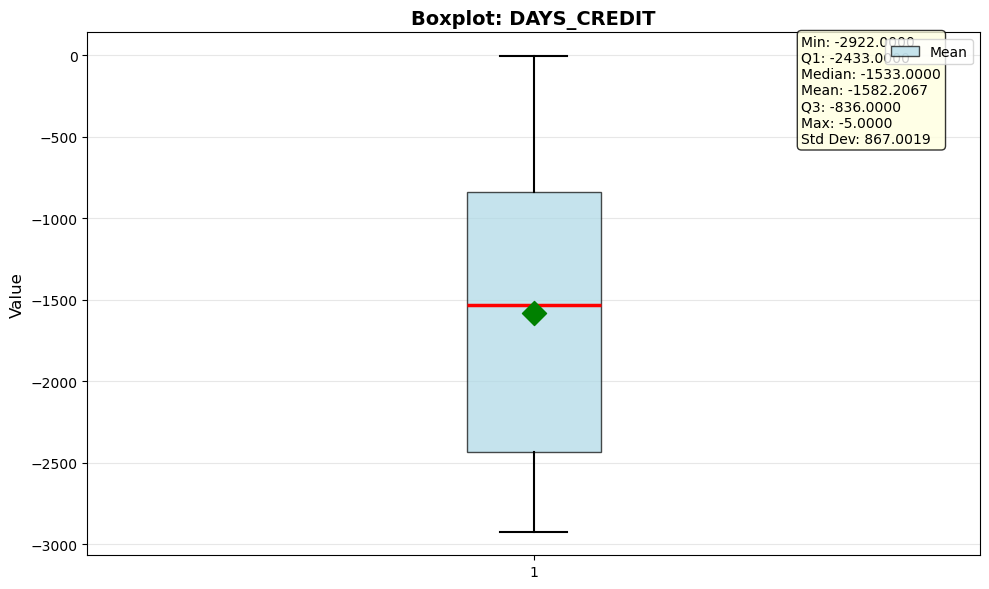

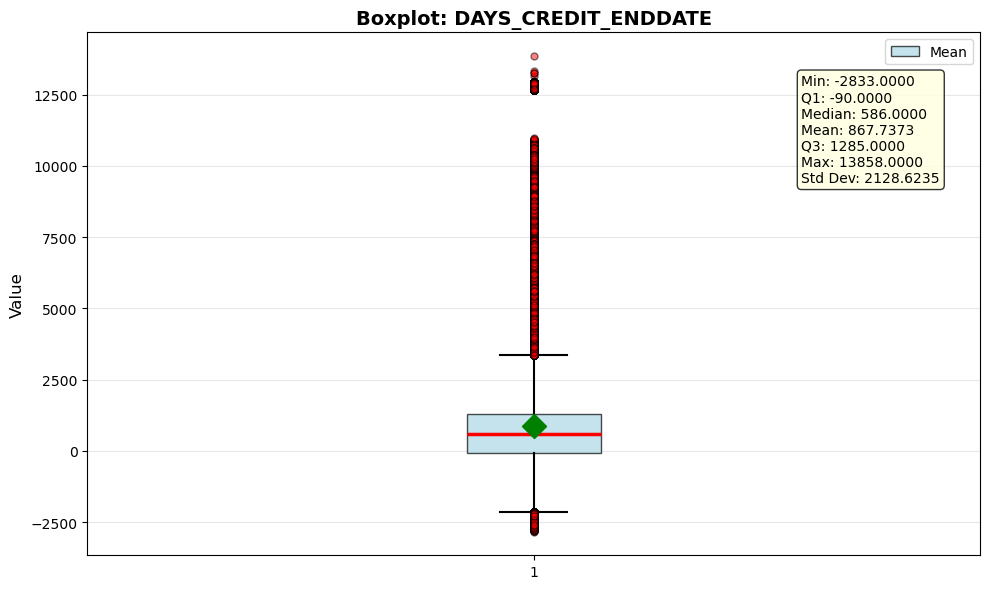

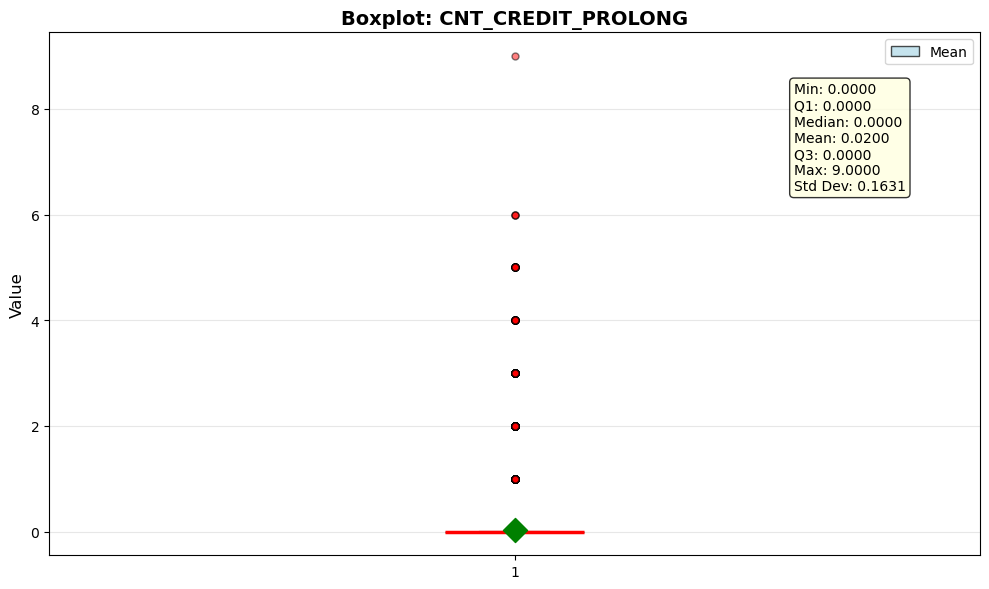

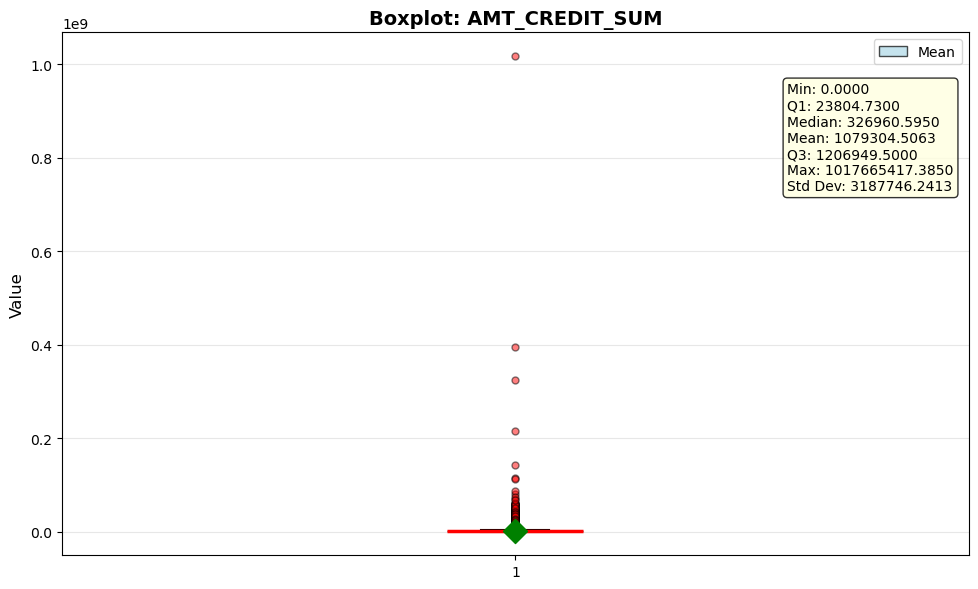

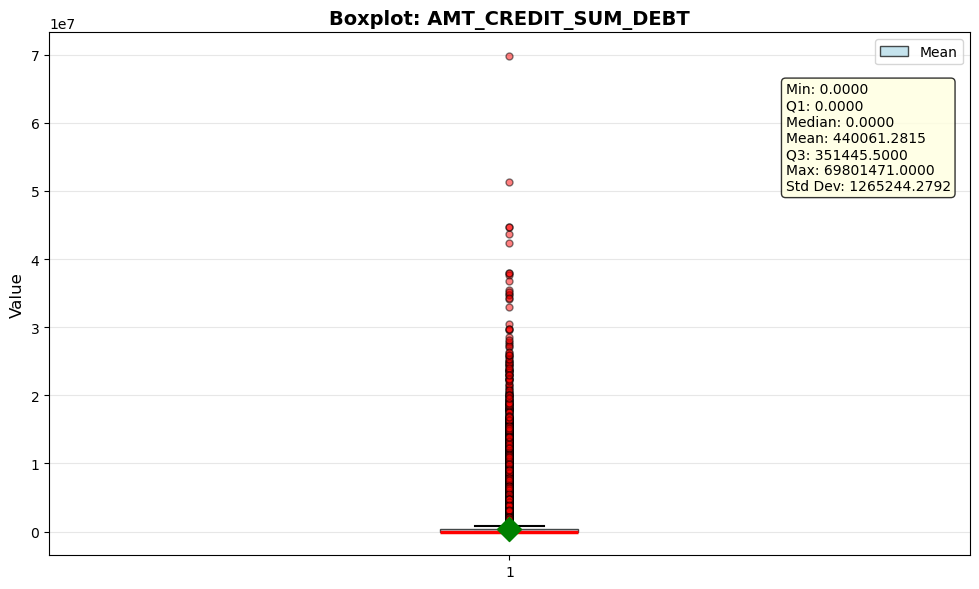

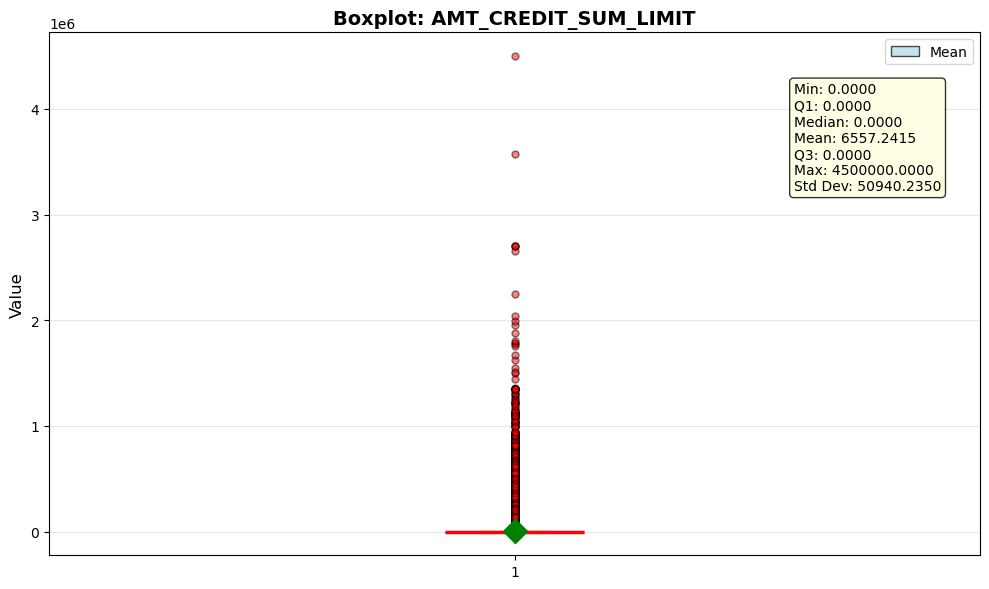

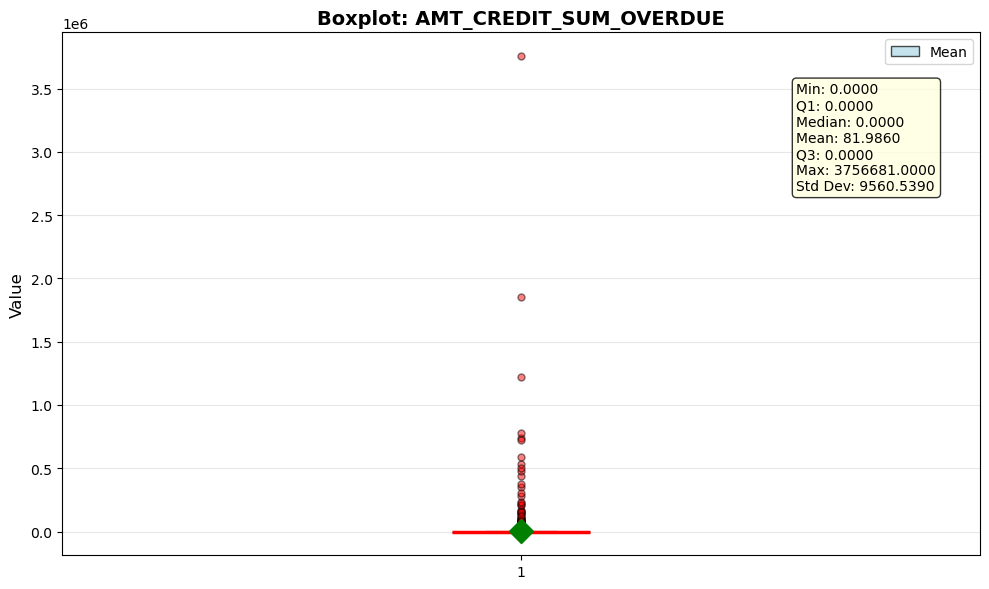

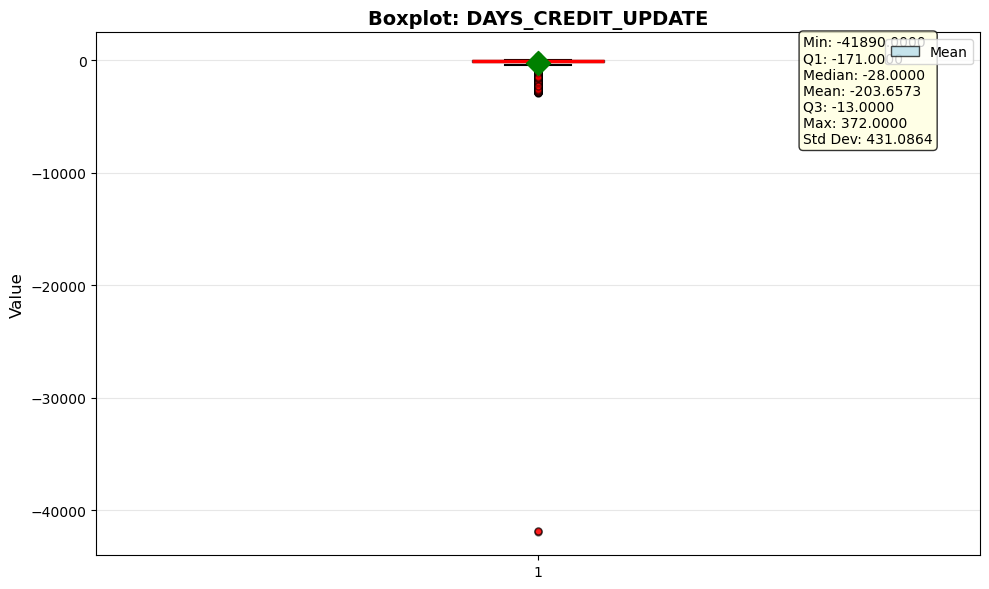

✓ All boxplots created!


In [ ]:
print("="*80)
print("BOXPLOT DISTRIBUTION OF NUMERIC VARIABLES (INDIVIDUAL FIGURES)")
print("="*80)

# Get numeric variables (excluding SK_ID_CURR and TARGET)
numeric_var_merged = df_merged_cleaned.select_dtypes(include=['number']).columns.tolist()
visualization_cols = [col for col in numeric_var_merged if col not in ['SK_ID_CURR', 'TARGET']]

print(f"\nCreating individual boxplots for {len(visualization_cols)} variables...\n")

for col in visualization_cols:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create boxplot
    bp = ax.boxplot(df_merged_cleaned[col].dropna(), vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2.5),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5),
                    flierprops=dict(marker='o', markerfacecolor='red', markersize=5, alpha=0.5))
    
    # Add mean marker
    mean_val = df_merged_cleaned[col].mean()
    ax.scatter([1], [mean_val], color='green', s=150, marker='D', zorder=3, label='Mean')
    
    # Customize plot
    ax.set_title(f'Boxplot: {col}', fontsize=14, fontweight='bold')
    ax.set_ylabel('Value', fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    ax.legend(['Mean'], loc='upper right')
    
    # Add statistics
    stats_text = (f"Min: {df_merged_cleaned[col].min():.4f}\n"
                 f"Q1: {df_merged_cleaned[col].quantile(0.25):.4f}\n"
                 f"Median: {df_merged_cleaned[col].median():.4f}\n"
                 f"Mean: {mean_val:.4f}\n"
                 f"Q3: {df_merged_cleaned[col].quantile(0.75):.4f}\n"
                 f"Max: {df_merged_cleaned[col].max():.4f}\n"
                 f"Std Dev: {df_merged_cleaned[col].std():.4f}")
    
    ax.text(1.3, ax.get_ylim()[1] * 0.9, stats_text, fontsize=10,
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8),
            verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

print("✓ All boxplots created!")

## Grouping and Screening

In [ ]:
merged_cleaned_copy = df_merged_cleaned.copy()
merged_cleaned_copy.isnull().sum()

SK_ID_CURR                           0
TARGET                               0
NAME_CONTRACT_TYPE                   0
FLAG_OWN_CAR                         0
FLAG_OWN_REALTY                      0
CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    256
NAME_TYPE_SUITE                   1096
NAME_INCOME_TYPE                     0
NAME_EDUCATION_TYPE                  0
NAME_FAMILY_STATUS                   0
NAME_HOUSING_TYPE                    0
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
FLAG_MOBIL                           0
FLAG_EMP_PHONE                       0
FLAG_WORK_PHONE                      0
FLAG_CONT_MOBILE                     0
FLAG_PHONE                           0
FLAG_EMAIL                           0
OCCUPATION_TYPE          

## Part 3: Data Preparation

##### Filtering application data rows

In [ ]:
print("="*80)
print("FILTERING APPLICATION DATA FOR LIFELONG LEARNING LOAN SEGMENT")
print("="*80)

# Store original dataset metrics (using appData)
total_original = len(appData)
original_bad_count = appData['TARGET'].sum()
original_bad_rate = appData['TARGET'].mean() * 100

print(f"\nORIGINAL APPLICATION DATASET:")
print(f"  Total records: {total_original:,}")
print(f"  Columns: {len(appData.columns)}")
print(f"  Goods (TARGET=0): {(appData['TARGET']==0).sum():,}")
print(f"  Bads (TARGET=1): {original_bad_count:,}")
print(f"  Bad rate: {original_bad_rate:.2f}%")

print("\n" + "="*80)
print("APPLYING FILTERING CRITERIA TO APPLICATION DATA")
print("="*80)

# Apply all criteria simultaneously to appData
filtered_appData = appData[
    (appData['DAYS_BIRTH'] >= -20075) & 
    (appData['DAYS_BIRTH'] <= -9125) &
    (appData['AMT_INCOME_TOTAL'] <= 96000) &
    (appData['NAME_CONTRACT_TYPE'] == 'Cash loans') &
    (appData['NAME_INCOME_TYPE'].isin(['Working', 'Commercial associate', 'State servant','Unemployed','Maternity leave']))
]

# Calculate filtered dataset metrics
total_filtered = len(filtered_appData)
filtered_bad_count = filtered_appData['TARGET'].sum()
filtered_bad_rate = filtered_appData['TARGET'].mean() * 100

percentage_retained = (total_filtered / total_original) * 100

print("\nFILTERED SEGMENT (Lifelong Learning Loans):")
print(f"  Total records: {total_filtered:,}")
print(f"  Columns: {len(filtered_appData.columns)}")
print(f"  Goods (TARGET=0): {(filtered_appData['TARGET']==0).sum():,}")
print(f"  Bads (TARGET=1): {filtered_bad_count:,}")
print(f"  Bad rate: {filtered_bad_rate:.2f}%")

print("\n" + "="*80)
print("COMPARISON METRICS")
print("="*80)

# Calculate differences
bad_rate_difference = filtered_bad_rate - original_bad_rate
retention_rate = percentage_retained

print(f"\nRETENTION:")
print(f"  Records retained: {total_filtered:,} out of {total_original:,}")
print(f"  Retention rate: {retention_rate:.2f}%")

print(f"\nBAD RATE COMPARISON:")
print(f"  Original application data: {original_bad_rate:.2f}%")
print(f"  Filtered segment: {filtered_bad_rate:.2f}%")
print(f"  Difference: {bad_rate_difference:+.2f} percentage points")

if bad_rate_difference < 0:
    print(f"  → Target segment is LOWER RISK (better than average)")
elif bad_rate_difference > 0:
    print(f"  → Target segment is HIGHER RISK (worse than average)")
else:
    print(f"  → Target segment has SIMILAR RISK to overall portfolio")

print("\n" + "="*80)
print("BREAKDOWN BY INDIVIDUAL CRITERIA")
print("="*80)

# Show impact of each filter
print("\nHow each criterion narrows the application dataset:")

criteria = [
    ('1. Age (25-55 years)', 
     appData[(appData['DAYS_BIRTH'] >= -20075) & (appData['DAYS_BIRTH'] <= -9125)]),
    ('2. Income Type (Working/Commercial/State/etc)', 
     appData[appData['NAME_INCOME_TYPE'].isin(['Working', 'Commercial associate', 'State servant','Unemployed', 'Maternity leave'])]),
    ('3. Contract Type (Cash loans)', 
     appData[appData['NAME_CONTRACT_TYPE'] == 'Cash loans']),
    ('4. Income (≤ $96,000)', 
     appData[appData['AMT_INCOME_TOTAL'] <= 96000])
]

for name, subset in criteria:
    count = len(subset)
    pct = (count / total_original) * 100
    bad_rate = subset['TARGET'].mean() * 100
    print(f"\n{name}")
    print(f"  Records: {count:,} ({pct:.2f}%)")
    print(f"  Bad rate: {bad_rate:.2f}%")

print("\n" + "="*80)
print("FILTERED SEGMENT SUMMARY")
print("="*80)

print(f"""
✓ Filtering Complete!

ORIGINAL APPLICATION DATASET:
  - Records: {total_original:,}
  - Columns: {len(appData.columns)}

FILTERED SEGMENT (Lifelong Learning):
  - Records: {total_filtered:,} ({retention_rate:.2f}% retention)
  - Columns: {len(filtered_appData.columns)} (same as original)
  - Default rate: {filtered_bad_rate:.2f}% ({bad_rate_difference:+.2f} pp vs original)

NEXT STEPS:
  1. Use 'filtered_appData' for Lifelong Learning segment analysis
  2. Perform correlation analysis on filtered segment
  3. Build credit scorecard using filtered application data
  4. Merge with bureau data for enhanced features
""")

print("Variable name: filtered_appData")
print(f"Shape: {filtered_appData.shape}")

FILTERING APPLICATION DATA FOR LIFELONG LEARNING LOAN SEGMENT

ORIGINAL APPLICATION DATASET:
  Total records: 307,511
  Columns: 120
  Goods (TARGET=0): 282,686
  Bads (TARGET=1): 24,825
  Bad rate: 8.07%

APPLYING FILTERING CRITERIA TO APPLICATION DATA

FILTERED SEGMENT (Lifelong Learning Loans):
  Total records: 31,127
  Columns: 120
  Goods (TARGET=0): 28,016
  Bads (TARGET=1): 3,111
  Bad rate: 9.99%

COMPARISON METRICS

RETENTION:
  Records retained: 31,127 out of 307,511
  Retention rate: 10.12%

BAD RATE COMPARISON:
  Original application data: 8.07%
  Filtered segment: 9.99%
  Difference: +1.92 percentage points
  → Target segment is HIGHER RISK (worse than average)

BREAKDOWN BY INDIVIDUAL CRITERIA

How each criterion narrows the application dataset:

1. Age (25-55 years)
  Records: 226,662 (73.71%)
  Bad rate: 8.71%

2. Income Type (Working/Commercial/State/etc)
  Records: 252,121 (81.99%)
  Bad rate: 8.66%

3. Contract Type (Cash loans)
  Records: 278,232 (90.48%)
  Bad rate

In [ ]:
# CHECKING ROW COUNTS AND TARGET ROW COUNT

# count occurrences of '0' and '1'
count_zeros = (filtered_appData['TARGET'] == 0).sum()
count_ones = (filtered_appData['TARGET'] == 1).sum()

# Calculate total rows
total_rows = len(filtered_appData['TARGET'])

# Calculate percentages
percent_zeros = (count_zeros / total_rows) * 100
percent_ones = (count_ones / total_rows) * 100

# Print results
print(f"Total rows with '0': {count_zeros}")
print(f"Total rows with '1': {count_ones}")
print(f"Percentage of '0's: {percent_zeros:.4f}%")
print(f"Percentage of '1's: {percent_ones:.4f}%")


Total rows with '0': 28016
Total rows with '1': 3111
Percentage of '0's: 90.0055%
Percentage of '1's: 9.9945%


Based on the above count, we have met the threshold of having minimally 2k goods and 2k bads alongside having 8% of bads as an ideal amount. 

##### Aggregate Bureau Data to flatten

In [ ]:
# Define the aggregation methods for each column
agg_methods = {
    'CREDIT_ACTIVE': lambda x: 'Active' if 'Active' in x.values else x.mode().iloc[0], 
    'CREDIT_CURRENCY': lambda x: x.mode().iloc[0], 
    'DAYS_CREDIT': 'mean',
    'CREDIT_DAY_OVERDUE': 'mean',
    'DAYS_CREDIT_ENDDATE': 'mean',
    'DAYS_ENDDATE_FACT': 'mean',
    'AMT_CREDIT_MAX_OVERDUE': 'max',
    'CNT_CREDIT_PROLONG': 'mean',
    'AMT_CREDIT_SUM': 'sum',
    'AMT_CREDIT_SUM_DEBT': 'sum', 
    'AMT_CREDIT_SUM_LIMIT': 'mean', 
    'AMT_CREDIT_SUM_OVERDUE': 'sum', 
    'CREDIT_TYPE': lambda x: x.mode().iloc[0], 
    'DAYS_CREDIT_UPDATE': 'mean',
    'AMT_ANNUITY': 'mean'
}

# Group by SK_ID_CURR and apply the aggregation methods
aggregated_bureau_data = bureauData.groupby('SK_ID_CURR').agg(agg_methods).reset_index()

# Display the first few rows of the aggregated data
print(aggregated_bureau_data.head())

# Display the shape of the aggregated data
print(f"Shape of aggregated data: {aggregated_bureau_data.shape}")

aggregated_bureau_data

KeyError: "Column(s) ['CREDIT_CURRENCY'] do not exist"

##### Drop rows with invalid/impossible values

In [ ]:
# Functions to drop rows based on column name and categorical variable criterias

def drop_invalid_values(df, column_name, valid_values):
    initial_count = len(df)
    df_filtered = df[df[column_name].isin(valid_values)]
    dropped_count = initial_count - len(df_filtered)
    
    print(f"Rows dropped from '{column_name}': {dropped_count}")
    return df_filtered

def drop_outside_range(df, column_name, min_value, max_value):
    initial_count = len(df)
    df_filtered = df[(df[column_name] >= min_value) & (df[column_name] <= max_value)]
    dropped_count = initial_count - len(df_filtered)
    
    print(f"Rows dropped from '{column_name}': {dropped_count}")
    return df_filtered

In [ ]:
# REMOVE ROWS WITH INVALID VALUES FROM APPLICATION DATA 

orig_total_rows = filtered_app_data.shape[0]

#Filter based on gender != 'M' or 'F'
filtered_app_data = drop_invalid_values(filtered_app_data, 'CODE_GENDER', ['M', 'F'])

#Filter based on own car status
filtered_app_data = drop_invalid_values(filtered_app_data, 'FLAG_OWN_CAR', ['Y', 'N'])

#Filter based on own realty
filtered_app_data = drop_invalid_values(filtered_app_data, 'FLAG_OWN_REALTY', ['Y', 'N'])

# filter unrealistic number of days (max 100 years)
days_columns_to_filter = [
    "DAYS_BIRTH",
    "DAYS_EMPLOYED", 
    "DAYS_REGISTRATION", 
    "DAYS_ID_PUBLISH"
]

# Apply the filtering function to all columns
for col in days_columns_to_filter:
    filtered_app_data = drop_outside_range(filtered_app_data, col, -36500, 36500)

# filter invalid categorical values (only 1 or 0)
category_columns_to_filter = [
    "FLAG_MOBIL", 
    "FLAG_EMP_PHONE", 
    "FLAG_WORK_PHONE",
    "FLAG_CONT_MOBILE", 
    "FLAG_PHONE", 
    "FLAG_EMAIL", 
    "REG_REGION_NOT_LIVE_REGION", 
    "REG_REGION_NOT_WORK_REGION", 
    "LIVE_REGION_NOT_WORK_REGION", 
    "REG_CITY_NOT_LIVE_CITY", 
    "REG_CITY_NOT_WORK_CITY", 
    "LIVE_CITY_NOT_WORK_CITY", 
    "FLAG_DOCUMENT_2",
    "FLAG_DOCUMENT_3", 
    "FLAG_DOCUMENT_4", 
    "FLAG_DOCUMENT_5", 
    "FLAG_DOCUMENT_6", 
    "FLAG_DOCUMENT_7", 
    "FLAG_DOCUMENT_8", 
    "FLAG_DOCUMENT_9", 
    "FLAG_DOCUMENT_10", 
    "FLAG_DOCUMENT_11", 
    "FLAG_DOCUMENT_12", 
    "FLAG_DOCUMENT_13", 
    "FLAG_DOCUMENT_14", 
    "FLAG_DOCUMENT_15", 
    "FLAG_DOCUMENT_16", 
    "FLAG_DOCUMENT_17", 
    "FLAG_DOCUMENT_18", 
    "FLAG_DOCUMENT_19", 
    "FLAG_DOCUMENT_20", 
    "FLAG_DOCUMENT_21"
]

# Apply the filtering function to all columns
for col in category_columns_to_filter:
    filtered_app_data = drop_invalid_values(filtered_app_data, col, [0, 1])

# filter invalid numeric values (0 at least)
num_columns_to_filter = [
    "AMT_REQ_CREDIT_BUREAU_HOUR", 
    "AMT_REQ_CREDIT_BUREAU_DAY", 
    "AMT_REQ_CREDIT_BUREAU_WEEK",
    "AMT_REQ_CREDIT_BUREAU_MON", 
    "AMT_REQ_CREDIT_BUREAU_QRT", 
    "AMT_REQ_CREDIT_BUREAU_YEAR",

    "OBS_30_CNT_SOCIAL_CIRCLE",
    "DEF_30_CNT_SOCIAL_CIRCLE", 
    "OBS_60_CNT_SOCIAL_CIRCLE", 
    "DEF_60_CNT_SOCIAL_CIRCLE",

    "CNT_CHILDREN",
    "AMT_INCOME_TOTAL",
    "AMT_CREDIT", 
    "AMT_ANNUITY", 
    "AMT_GOODS_PRICE"
]

# Apply the filtering function to all columns
for col in num_columns_to_filter:
    filtered_app_data = drop_outside_range(filtered_app_data, col, 0, float('inf'))


final_total_rows = filtered_app_data.shape[0]

percent_dropped = (orig_total_rows - final_total_rows)/orig_total_rows

print("Start: " + str(orig_total_rows))
print("End: " + str(final_total_rows))
print(str(percent_dropped*100) + "%")



In [ ]:
# REMOVE ROWS WITH INVALID VALUES FROM BUREAU DATA 

orig_total_rows = aggregated_bureau_data.shape[0]

# Unreasonable dates: > 50 years ago
# aggregated_bureau_data = drop_outside_range(aggregated_bureau_data, "DAYS_CREDIT", 0, float('inf'))
aggregated_bureau_data = drop_outside_range(aggregated_bureau_data, "DAYS_CREDIT_ENDDATE", -18250, 18250)
aggregated_bureau_data = drop_outside_range(aggregated_bureau_data, "DAYS_ENDDATE_FACT", -18250, 18250)

# Unrealistic values for Credit amounts > 1million/10million (Or maybe the threshold should be much lesser?)
aggregated_bureau_data = drop_outside_range(aggregated_bureau_data, "AMT_CREDIT_MAX_OVERDUE", 0, 100000000)
aggregated_bureau_data = drop_outside_range(aggregated_bureau_data, "AMT_CREDIT_SUM", 0, 1000000)
aggregated_bureau_data = drop_outside_range(aggregated_bureau_data, "AMT_CREDIT_SUM_DEBT", 0, 1000000)
aggregated_bureau_data = drop_outside_range(aggregated_bureau_data, "AMT_CREDIT_SUM_LIMIT", 0, 1000000)
aggregated_bureau_data = drop_outside_range(aggregated_bureau_data, "AMT_CREDIT_SUM_OVERDUE", 0, 1000000)

final_total_rows = aggregated_bureau_data.shape[0]

percent_dropped = (orig_total_rows - final_total_rows)/orig_total_rows

print("Start: " + str(orig_total_rows))
print("End: " + str(final_total_rows))
print(str(percent_dropped*100) + "%")


##### Merge bureau data with application data - using left join

In [ ]:
# Merge application data and bureau data
combined_data = filtered_app_data.merge(aggregated_bureau_data, on='SK_ID_CURR', how='left')


# handle the column that exist in both application data and bureau data
# Calculate row-wise mean of the AMT_ANNUITY_x and AMT_ANNUITY_y columns
combined_data['AMT_ANNUITY'] = combined_data[['AMT_ANNUITY_x', 'AMT_ANNUITY_y']].mean(axis=1)

# Drop original columns
combined_data.drop(['AMT_ANNUITY_x', 'AMT_ANNUITY_y'], axis=1, inplace=True)

# Display the first few rows of the combined data
print(combined_data.head())

# Display the shape of the combined data
print(f"Shape of combined data: {combined_data.shape}")

# Check for any missing values after merging
print(combined_data.isnull().sum())

# Optionally, you can save the combined data to a CSV file
combined_data.to_csv('combined_app_bureau_data.csv', index=False)

combined_data

In [ ]:
# CHECKING ROW COUNTS AND TARGET ROW COUNT - after merging

# count occurrences of '0' and '1'
count_zeros = (combined_data['TARGET'] == 0).sum()
count_ones = (combined_data['TARGET'] == 1).sum()

# Calculate total rows
total_rows = len(combined_data['TARGET'])

# Calculate percentages
percent_zeros = (count_zeros / total_rows) * 100
percent_ones = (count_ones / total_rows) * 100

# Print results
print(f"Total rows with '0': {count_zeros}")
print(f"Total rows with '1': {count_ones}")
print(f"Percentage of '0's: {percent_zeros:.4f}%")
print(f"Percentage of '1's: {percent_ones:.4f}%")


In [ ]:
# Distribution of TARGET
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x='TARGET', data=filtered_app_data)

plt.title("Good vs Bad Applicants")
plt.xlabel("TARGET (0 = Good, 1 = Bad)")
plt.ylabel("Count")
plt.show()

##### Dropping 1 in a pair columns with high correlation (mitigate multicollinearity)

In [ ]:

# Prevent multicollinearity for numerical data only.
# Find out pairs with high correlation and drop the column with lower correlation to TARGET 

# Display original column names
print("Original column names:")
print(combined_data.columns.tolist())

# Display the number of columns before dropping correlated columns
print(f"\nNumber of columns before dropping correlated columns: {combined_data.shape[1]}")

# Select only numeric columns
numeric_cols = combined_data.select_dtypes(include=['number'])

# Ensure TARGET is in numeric_cols
if 'TARGET' not in numeric_cols.columns:
    raise ValueError("TARGET column not found in numeric columns")

# Calculate the correlation matrix for numeric columns (excluding TARGET)
correlation_matrix = numeric_cols.drop(columns=['TARGET']).corr()

# Calculate correlation with TARGET
correlation_with_target = numeric_cols.corrwith(combined_data['TARGET'])

# Identify highly correlated pairs (correlation > 0.8 and < 1)
high_corr_pairs = correlation_matrix.unstack().sort_values(kind="quicksort", ascending=False)
high_corr_pairs = high_corr_pairs[(high_corr_pairs > 0.8) & (high_corr_pairs < 1)]

# Create a set to store unique pairs
unique_pairs = set()
filtered_pairs = []

for col1, col2 in high_corr_pairs.index:
    # Sort the pair alphabetically to avoid duplicates
    sorted_pair = tuple(sorted((col1, col2)))
    if sorted_pair not in unique_pairs:
        unique_pairs.add(sorted_pair)
        filtered_pairs.append((col1, col2, high_corr_pairs[col1, col2]))

# Display unique pairs
print("\nUnique highly correlated pairs:")
for pair in filtered_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]}")

# Extract columns to drop based on correlation with TARGET
columns_to_drop = set()
already_dropped = set()

print("\nDropping columns based on correlation with TARGET:")
for col1, col2 in unique_pairs:
    if col1 not in already_dropped and col2 not in already_dropped:
        # Drop the column with lower correlation to TARGET
        corr1 = abs(correlation_with_target[col1])
        corr2 = abs(correlation_with_target[col2])
        if corr1 < corr2:
            columns_to_drop.add(col1)
            already_dropped.add(col1)
            print(f"Pair: {col1} (corr: {corr1:.4f}) vs {col2} (corr: {corr2:.4f}) -> Dropping {col1}")
        else:
            columns_to_drop.add(col2)
            already_dropped.add(col2)
            print(f"Pair: {col1} (corr: {corr1:.4f}) vs {col2} (corr: {corr2:.4f}) -> Dropping {col2}")

print("\nColumns to drop due to high correlation:")
print(columns_to_drop)

# Drop the identified columns from combined_data
combined_data_cleaned = combined_data.drop(columns=columns_to_drop)

# Display the number of columns after dropping correlated columns
print(f"\nNumber of columns after dropping correlated columns: {combined_data_cleaned.shape[1]}")

# Display cleaned column names
print("\nCleaned column names:")
print(combined_data_cleaned.columns.tolist())


## PHASE 3: Grouping and Screening

In [ ]:
temp_cleaned = combined_data_cleaned.copy()
temp_cleaned

##### Fine Classing: Get the WOE and IV then keep the top 15 characteristics to conduct coarse classing

In [ ]:
def calculate_woe_iv_for_column(data, column, target, bins=10):
    # Ensure the column is numeric before binning
    if data[column].dtype in ['float64', 'int64']:
        try:
            data[column], bins = pd.qcut(data[column], bins, duplicates='drop', retbins=True)
        except ValueError:
            return None

    # Calculate WOE and IV
    grouped = data.groupby(column)[target].agg(['count', 'sum'])
    grouped['non_event'] = grouped['count'] - grouped['sum']
    grouped['event_rate'] = grouped['sum'] / grouped['sum'].sum()
    grouped['non_event_rate'] = grouped['non_event'] / grouped['non_event'].sum()
    grouped['woe'] = np.log(grouped['event_rate'] / grouped['non_event_rate'])
    grouped['iv'] = (grouped['event_rate'] - grouped['non_event_rate']) * grouped['woe']
    return grouped['iv'].sum()

# Calculate IV values (already excludes TARGET and code_gender)
iv_values = {}
for col in temp_cleaned.columns:
    if col not in ['TARGET']:  # Explicit exclusion
        iv = calculate_woe_iv_for_column(temp_cleaned, col, 'TARGET')
        if iv is not None:
            iv_values[col] = iv

# Select top 15 variables by IV
sorted_iv = sorted(iv_values.items(), key=lambda x: x[1], reverse=True)[:15]
top_15_cols = [col for col, iv in sorted_iv]

# Keep only top predictors + target
temp_cleaned_fineclassing = temp_cleaned[top_15_cols + ['TARGET']]
print(f"Top 15 variables: {top_15_cols}")

In [ ]:
# Define predictive strength categories
def get_predictive_strength(iv):
    if iv < 0.02:
        return "Not Predictive"
    elif iv < 0.1:
        return "Weak Predictive"
    elif iv < 0.3:
        return "Medium Predictive"
    elif iv < 0.5:
        return "Strong Predictive"
    else:
        return "Suspicious Predictive"

# Print IV values and predictive strength for remaining columns
print("IV Values and Predictive Strength of Remaining Columns:")
for col in temp_cleaned_fineclassing.columns:
    if col in iv_values:  # Ensure the column has IV calculated
        iv = iv_values[col]
        strength = get_predictive_strength(iv)
        print(f"{col}: IV = {iv:.4f}, Predictive Strength = {strength}")

Top 15 variables: 

[
    'NAME_INCOME_TYPE', 
    'NAME_EDUCATION_TYPE', 
    'ORGANIZATION_TYPE', 
    'CREDIT_TYPE', 
    'EXT_SOURCE_1', 
    'DAYS_CREDIT', 
    'DAYS_EMPLOYED', 
    'AMT_CREDIT_SUM_DEBT', 
    'OCCUPATION_TYPE', 
    'DAYS_CREDIT_ENDDATE',
    'AMT_CREDIT_MAX_OVERDUE', 
    'CODE_GENDER', 
    'DAYS_BIRTH', 
    'FLOORSMIN_MODE', 
    'DAYS_LAST_PHONE_CHANGE'
]

##### Dropping CREDIT_TYPE and CODE_GENDER
CODE_GENDER shows biasness if placed on a credit scorecard and CREDIT_TYPE is not logical on a credit scorecard

In [ ]:
temp_cleaned_fineclassing.drop('CREDIT_TYPE', axis=1, inplace=True)
temp_cleaned_fineclassing.drop('CODE_GENDER', axis=1, inplace=True)

##### Leftover variables

Top 13 variables: 

[
    'NAME_INCOME_TYPE', 
    'NAME_EDUCATION_TYPE', 
    'ORGANIZATION_TYPE', 
    'EXT_SOURCE_1', 
    'DAYS_CREDIT', 
    'DAYS_EMPLOYED', 
    'AMT_CREDIT_SUM_DEBT', 
    'OCCUPATION_TYPE', 
    'DAYS_CREDIT_ENDDATE',
    'AMT_CREDIT_MAX_OVERDUE', 
    'DAYS_BIRTH', 
    'FLOORSMIN_MODE', 
    'DAYS_LAST_PHONE_CHANGE'
]

In [ ]:
# Define predictive strength categories
def get_predictive_strength(iv):
    if iv < 0.02:
        return "Not Predictive"
    elif iv < 0.1:
        return "Weak Predictive"
    elif iv < 0.3:
        return "Medium Predictive"
    elif iv < 0.5:
        return "Strong Predictive"
    else:
        return "Suspicious Predictive"

# Print IV values and predictive strength for remaining columns
print("IV Values and Predictive Strength of Remaining Columns:")
for col in temp_cleaned_fineclassing.columns:
    if col in iv_values:  # Ensure the column has IV calculated
        iv = iv_values[col]
        strength = get_predictive_strength(iv)
        print(f"{col}: IV = {iv:.4f}, Predictive Strength = {strength}")

##### Coarse classing

In [ ]:
# prep to do coarse classing
temp_data = combined_data_cleaned.copy()

In [ ]:
temp_data

In [ ]:
def woe_iv(data, variable_name):

    working_data = data.copy() 

    # missing values have been assigned NaN when binning with pd.qcut
    # rename this bin as 'Missing' to consider into WOE calculation
    working_data['Bin_Range'] = working_data['Bin_Range'].astype('object')
    working_data['Bin_Range'].fillna('Missing', inplace = True)
    
    variable_data = pd.DataFrame()
    variable_data['Bin_Range'] = working_data.groupby(by='Bin_Range', as_index=False).count()['Bin_Range']

    variable_data['Count'] = working_data.groupby(by='Bin_Range', as_index=False).count()['TARGET']

    variable_data['Events'] =working_data.groupby(by='Bin_Range', as_index=False).sum()['TARGET']

    variable_data['Non_Events'] = variable_data['Count'] - variable_data['Events']

    variable_data['%_of_Events'] = variable_data['Events']/sum(variable_data['Events'])

    variable_data['%_of_Non_Events'] = variable_data['Non_Events']/sum(variable_data['Non_Events'])
    variable_data

    variable_data['WOE'] = np.log(variable_data['%_of_Non_Events'] / variable_data['%_of_Events'])

    variable_data['IV'] = (variable_data['%_of_Non_Events']-variable_data['%_of_Events']) * variable_data['WOE']

    IV = sum(variable_data['IV'])
    return(IV, variable_data)


def woe_iv_plot(data, variable_name):
    IV, variable_data = woe_iv(data, variable_name)
    print('IV for', variable_name, 'with', variable_data.shape[0], 'bins:', round(IV,4))
    ffig, ax1 = plt.subplots(figsize=(20,6))

    # print bin and its respective WOE
    print("\n".join([f"Bin {row['Bin_Range']}: WOE = {row['WOE']:.4f}" for _, row in variable_data.iterrows()]))

    # if 'missing' bin, do not include in plot

    if variable_data['Bin_Range'].isin(['Missing']).sum() > 0:
        sns.lineplot(data = variable_data['WOE'].iloc[0:-1], marker='o', sort = False, ax=ax1)
    else:
        sns.lineplot(data = variable_data['WOE'], marker='o', sort = False, ax=ax1)
    plt.xticks(rotation=45)

    # if 'missing' bin, create the scatter plot to plot the Missing WOE data point
    if variable_data['Bin_Range'].isin(['Missing']).sum() > 0: 
        last_point = len(variable_data['WOE']) - 1
        scatter_plot = sns.scatterplot(x=[last_point], y=[variable_data['WOE'][last_point]], color='b', s=30, ax=ax1)
    
    ax2 = ax1.twinx()
        
    # plot the bin counts
    sns.barplot(x = variable_data['Bin_Range'] , y = variable_data['Count'], alpha=0.5, ax = ax2, color = 'deepskyblue')
    plt.title("WOE plot for " + variable_name)
    plt.show()


In [ ]:
# get the original fine classing bins
variable = 'DAYS_LAST_PHONE_CHANGE'
woe_bin_data = temp_data.loc[:,(variable, 'TARGET')]
woe_bin_data['Bin_Range'] = pd.qcut(temp_data[variable],q=7)
print(f"IV for {variable} = {woe_iv(woe_bin_data, variable)[0]:.3f}")
woe_iv(woe_bin_data, variable)
woe_iv_plot(woe_bin_data, variable)


##### Coarse Classing: Get the bins for the numeric characteristics 


['NAME_INCOME_TYPE'] (categorical)<br>
['NAME_EDUCATION_TYPE']  (categorical)<br>
['ORGANIZATION_TYPE']  (categorical)<br>
['OCCUPATION_TYPE']  (categorical)<br>

['EXT_SOURCE_1'] (numeric)<br>
['DAYS_CREDIT']  (numeric)<br>
['DAYS_EMPLOYED']  (numeric)<br>
['AMT_CREDIT_SUM_DEBT']  (numeric)<br>
['DAYS_CREDIT_ENDDATE']  (numeric)<br>
['AMT_CREDIT_MAX_OVERDUE']  (numeric)<br>
['DAYS_BIRTH']  (numeric)<br>
['FLOORSMIN_MODE']  (numeric)<br>
['DAYS_LAST_PHONE_CHANGE']  (numeric)<br>

Total 9 Numeric, 4 Categorical


##### First attempt

In [ ]:
# coarse classing to manually adjust the bins to improve the IV and make it monotonic for the top 15

# variable = 'EXT_SOURCE_1'
# bin_edges = [idk] #0.3154 - original set
# bin_edges = [0, 0.2, 0.4, 0.65, 0.8, 1] #0.1481 - optimal

# variable = 'DAYS_CREDIT'
# bin_edges = [-2900, -900, -600, -500, 0] #0.0338 - optimal

# variable = 'DAYS_EMPLOYED'
# bin_edges = [-18000, -11500, -5500, -2500, -1500,  0] #0.1232 - optimal

# variable = 'AMT_CREDIT_SUM_DEBT'
# bin_edges = [-0.001, 14000, 26000, 29821] #0.0507 - optimal

# variable = 'DAYS_CREDIT_ENDDATE'
# bin_edges = [-14300.0, -400.0, -200, 17000] #0.0268 - optimal

# variable = 'AMT_CREDIT_MAX_OVERDUE'
# bin_edges = [0, 2400, 5800, 2400000] #0.0276 - optimal

# variable = 'DAYS_BIRTH'
# bin_edges = [-25000, -22000, -19000, -14609, 0] #0.0697 - optimal

# variable = 'FLOORSMIN_MODE'
# bin_edges = [0,  0.375, 0.5, 1] #0.0222 - optimal

# variable = 'DAYS_LAST_PHONE_CHANGE'
# bin_edges = [-4200, -2000, -1200, -850, -700, -300, 0] #0.0507 - optimal

# variable = 'OWN_CAR_AGE'
# bin_edges = [0, 1, 1.5, 2, 6, 8] #0.0138 - optimal

# temp_data['Bin_Range'] = pd.cut(temp_data[variable], bins = bin_edges, include_lowest= True)
# temp_data['Bin_Range'].value_counts().sort_index()
# woe_iv_plot(temp_data, variable)

##### Second attempt

In [ ]:
# coarse classing to manually adjust the bins to improve the IV and make it monotonic for the top 15

variable = 'EXT_SOURCE_1'
bin_edges = [0, 0.4, 0.65, 1] 

# variable = 'DAYS_CREDIT'
# bin_edges = [-1000, -500, 0] 

# variable = 'DAYS_EMPLOYED'
# bin_edges = [-11500, -5500, -2500, -1500]

# variable = 'AMT_CREDIT_SUM_DEBT'
# bin_edges = [0, 10000, 150000, 1000000]

# variable = 'DAYS_CREDIT_ENDDATE'
# bin_edges = [-14300, -500, -200]

# variable = 'AMT_CREDIT_MAX_OVERDUE'
# bin_edges = [0, 50, 3000, 5800, 2400000]

# variable = 'DAYS_BIRTH'
# bin_edges = [-30000, -20000, -18000, -13000, -7000] 

# variable = 'FLOORSMIN_MODE'
# bin_edges = [0, 0.21, 0.375] 

# variable = 'DAYS_LAST_PHONE_CHANGE'
# bin_edges = [-4000, -2000, -1000, -300]


temp_data['Bin_Range'] = pd.cut(temp_data[variable], bins = bin_edges, include_lowest= True)
temp_data['Bin_Range'].value_counts().sort_index()
woe_iv_plot(temp_data, variable)

##### Checking for breakdown to ensure there is sufficient non-events and events as well as meeting 5% of the observations per bin

In [ ]:
bin_counts = temp_data['Bin_Range'].value_counts().sort_index()

# Breakdown of rows with TARGET as 0 and TARGET as 1 for each bin
target_breakdown = temp_data.groupby(['Bin_Range', 'TARGET']).size().unstack(fill_value=0)

# Calculate percentages for TARGET = 0 and TARGET = 1
percentages = target_breakdown.div(target_breakdown.sum(axis=1), axis=0) * 100

# Display results
print("Bin Counts:")
print(bin_counts)
print("\nTarget Breakdown (Counts):")
print(target_breakdown)
print("\nTarget Breakdown (Percentages):")
print(percentages)

##### View all the WOE and count for each numeric characteristics bins

##### First attempt collated

In [ ]:
# # COLLATED
# variable_bins = [
#     # Categorical 
#     # ["NAME_INCOME_TYPE", ['Working', 'State servant', 'Commercial associate', 'Pensioner', 'Unemployed', 'Student', 'Businessman', 'Maternity leave']],
#     # ["NAME_EDUCATION_TYPE", ['Secondary / secondary special', 'Higher education', 'Incomplete higher', 'Lower secondary', 'Academic degree']],
#     # ["ORGANIZATION_TYPE", ['Government', 'Business Entity Type 2', 'Housing', 'Self-employed', 'University', 'Construction', 'Agriculture', 'Restaurant', 'Business Entity Type 3', 'Trade: type 3', 'Other', 'Hotel','Bank', 'Industry: type 9', 'Military', 'School', 'Trade: type 7', 'Security', 'Medicine', 'Services', 'Kindergarten', 'Industry: type 3', 'Postal', 'Electricity', 'Business Entity Type 1', 'Industry: type 11', 'Industry: type 13', 'Transport: type 4', 'Trade: type 2', 'Insurance', 'Transport: type 2', 'Industry: type 7', 'Industry: type 12', 'Industry: type 4', 'Mobile', 'Telecom', 'Trade: type 6', 'Legal Services', 'Culture', 'Police', 'Security Ministries', 'Transport: type 3', 'Advertising', 'Industry: type 5', 'Industry: type 1', 'Emergency', 'Cleaning', 'Industry: type 6', 'Trade: type 1', 'Realtor', 'Industry: type 10', 'Industry: type 2', 'Trade: type 4', 'Transport: type 1', 'Industry: type 8', 'Religion', 'Trade: type 5']],
#     # ["OCCUPATION_TYPE", ['Laborers', 'Sales staff', nan, 'Low-skill Laborers','Accountants', 'Private service staff', 'Core staff','Cooking staff', 'Drivers', 'Cleaning staff', 'Medicine staff', 'High skill tech staff', 'Realty agents', 'Secretaries', 'Managers', 'Security staff', 'HR staff', 'Waiters/barmen staff', 'IT staff']],
#     # ["CREDIT_TYPE", ['Consumer credit', 'Credit card', 'Microloan', 'Car loan', 'Another type of loan']],
    
#     # Numeric 
#     ["EXT_SOURCE_1", [0, 0.2, 0.4, 0.65, 0.8, 1]], 
#     ["OWN_CAR_AGE", [0, 4, 8, 13, 26]], 
#     ["DAYS_CREDIT", [-2900, -900, -600, -500, 0]],
#     ["DAYS_EMPLOYED", [-18000, -11500, -5500, -2500, -1500,  0]],
#     ["AMT_CREDIT_SUM_DEBT", [-0.001, 14000, 26000, 29821]],
#     ["DAYS_CREDIT_ENDDATE", [-14300.0, -400.0, -200, 17000]],
#     ["AMT_CREDIT_MAX_OVERDUE", [0, 2400, 5800, 2400000]],
#     ["DAYS_BIRTH", [-25000, -22000, -19000, -14609, 0]],
#     ["FLOORSMIN_MODE", [0,  0.375, 0.5, 1]],
#     ["DAYS_LAST_PHONE_CHANGE", [-4200, -2000, -1200, -850, -700, -300, 0]],
# ]

##### Second attempt collated

In [ ]:
# # COLLATED
# variable_bins = [
#     # Categorical 
#     # ["NAME_INCOME_TYPE", ['Working', 'State servant', 'Commercial associate', 'Pensioner', 'Unemployed', 'Student', 'Businessman', 'Maternity leave']],
#     # ["NAME_EDUCATION_TYPE", ['Secondary / secondary special', 'Higher education', 'Incomplete higher', 'Lower secondary', 'Academic degree']],
#     # ["ORGANIZATION_TYPE", ['Government', 'Business Entity Type 2', 'Housing', 'Self-employed', 'University', 'Construction', 'Agriculture', 'Restaurant', 'Business Entity Type 3', 'Trade: type 3', 'Other', 'Hotel','Bank', 'Industry: type 9', 'Military', 'School', 'Trade: type 7', 'Security', 'Medicine', 'Services', 'Kindergarten', 'Industry: type 3', 'Postal', 'Electricity', 'Business Entity Type 1', 'Industry: type 11', 'Industry: type 13', 'Transport: type 4', 'Trade: type 2', 'Insurance', 'Transport: type 2', 'Industry: type 7', 'Industry: type 12', 'Industry: type 4', 'Mobile', 'Telecom', 'Trade: type 6', 'Legal Services', 'Culture', 'Police', 'Security Ministries', 'Transport: type 3', 'Advertising', 'Industry: type 5', 'Industry: type 1', 'Emergency', 'Cleaning', 'Industry: type 6', 'Trade: type 1', 'Realtor', 'Industry: type 10', 'Industry: type 2', 'Trade: type 4', 'Transport: type 1', 'Industry: type 8', 'Religion', 'Trade: type 5']],
#     # ["OCCUPATION_TYPE", ['Laborers', 'Sales staff', nan, 'Low-skill Laborers','Accountants', 'Private service staff', 'Core staff','Cooking staff', 'Drivers', 'Cleaning staff', 'Medicine staff', 'High skill tech staff', 'Realty agents', 'Secretaries', 'Managers', 'Security staff', 'HR staff', 'Waiters/barmen staff', 'IT staff']],
    
#     # Numeric 
#     ["EXT_SOURCE_1", [0, 0.4, 0.65, 1]], 
#     ["DAYS_CREDIT", [-1000, -500, 0]],
#     ["DAYS_EMPLOYED", [-11500, -5500, -2500, -1500]],
#     ["AMT_CREDIT_SUM_DEBT", [0, 10000, 150000, 1000000]],
#     ["DAYS_CREDIT_ENDDATE", [-14300, -700, -200]],
#     ["AMT_CREDIT_MAX_OVERDUE", [0, 50, 3000, 5800, 2400000]],
#     ["DAYS_BIRTH", [-30000, -20000, -18000, -13000, -9000, 0]],
#     ["FLOORSMIN_MODE", [0, 0.3, 0.375]],
#     ["DAYS_LAST_PHONE_CHANGE", [-5000, -1700, -1100, -600, 0]],

# ]

##### Third attempt collated

In [ ]:
# COLLATED
variable_bins = [
    # Categorical 
    # ["NAME_INCOME_TYPE", ['Working', 'State servant', 'Commercial associate', 'Pensioner', 'Unemployed', 'Student', 'Businessman', 'Maternity leave']],
    # ["NAME_EDUCATION_TYPE", ['Secondary / secondary special', 'Higher education', 'Incomplete higher', 'Lower secondary', 'Academic degree']],
    # ["ORGANIZATION_TYPE", ['Government', 'Business Entity Type 2', 'Housing', 'Self-employed', 'University', 'Construction', 'Agriculture', 'Restaurant', 'Business Entity Type 3', 'Trade: type 3', 'Other', 'Hotel','Bank', 'Industry: type 9', 'Military', 'School', 'Trade: type 7', 'Security', 'Medicine', 'Services', 'Kindergarten', 'Industry: type 3', 'Postal', 'Electricity', 'Business Entity Type 1', 'Industry: type 11', 'Industry: type 13', 'Transport: type 4', 'Trade: type 2', 'Insurance', 'Transport: type 2', 'Industry: type 7', 'Industry: type 12', 'Industry: type 4', 'Mobile', 'Telecom', 'Trade: type 6', 'Legal Services', 'Culture', 'Police', 'Security Ministries', 'Transport: type 3', 'Advertising', 'Industry: type 5', 'Industry: type 1', 'Emergency', 'Cleaning', 'Industry: type 6', 'Trade: type 1', 'Realtor', 'Industry: type 10', 'Industry: type 2', 'Trade: type 4', 'Transport: type 1', 'Industry: type 8', 'Religion', 'Trade: type 5']],
    # ["OCCUPATION_TYPE", ['Laborers', 'Sales staff', nan, 'Low-skill Laborers','Accountants', 'Private service staff', 'Core staff','Cooking staff', 'Drivers', 'Cleaning staff', 'Medicine staff', 'High skill tech staff', 'Realty agents', 'Secretaries', 'Managers', 'Security staff', 'HR staff', 'Waiters/barmen staff', 'IT staff']],
    
    # Numeric 
    ["EXT_SOURCE_1", [0, 0.4, 0.65, 1]], 
    ["DAYS_CREDIT", [-1000, -500, 0]],
    ["DAYS_EMPLOYED", [-11500, -5500, -2500, -1500]],
    ["AMT_CREDIT_SUM_DEBT", [0, 10000, 150000, 1000000]],
    ["AMT_CREDIT_MAX_OVERDUE", [0, 50, 3000, 5800, 2400000]],
    ["DAYS_BIRTH", [-30000, -20000, -18000, -13000, -8000]],
    ["DAYS_CREDIT_ENDDATE", [-14300, -500, -200]],
    ["FLOORSMIN_MODE", [0, 0.3, 0.375] ],
    ["DAYS_LAST_PHONE_CHANGE", [-3000, -2000, -1000, -300]],

]

In [ ]:
for item in variable_bins:
    variable = item[0]
    bin_edges = item[1]
    temp_data['Bin_Range'] = pd.cut(temp_data[variable], bins = bin_edges, include_lowest= True)
    temp_data['Bin_Range'].value_counts().sort_index()
    woe_iv_plot(temp_data, variable)

## PHASE 4: Create Scorecard

##### First attempt list

In [ ]:
# temp_cleaned = combined_data_cleaned.copy()
# top_all = ['TARGET', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'ORGANIZATION_TYPE', 'OCCUPATION_TYPE', 'CREDIT_TYPE', 'EXT_SOURCE_1', 'DAYS_CREDIT', 'AMT_CREDIT_SUM_DEBT', 'DAYS_CREDIT_ENDDATE', 'AMT_CREDIT_MAX_OVERDUE','DAYS_BIRTH', 'FLOORSMIN_MODE', 'DAYS_LAST_PHONE_CHANGE']
# top_numeric = ['EXT_SOURCE_1', 'DAYS_CREDIT', 'AMT_CREDIT_SUM_DEBT', 'DAYS_CREDIT_ENDDATE', 'AMT_CREDIT_MAX_OVERDUE','DAYS_BIRTH', 'FLOORSMIN_MODE', 'DAYS_LAST_PHONE_CHANGE']
# top_categorical = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'ORGANIZATION_TYPE', 'OCCUPATION_TYPE', 'CREDIT_TYPE']

# temp_cleaned = temp_cleaned[top_all]

##### Second attempt list

In [ ]:
temp_cleaned = combined_data_cleaned.copy()
top_all = ['TARGET', 'DAYS_EMPLOYED', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'ORGANIZATION_TYPE', 'OCCUPATION_TYPE', 'EXT_SOURCE_1', 'DAYS_CREDIT', 'AMT_CREDIT_SUM_DEBT', 'DAYS_CREDIT_ENDDATE', 'AMT_CREDIT_MAX_OVERDUE','DAYS_BIRTH', 'FLOORSMIN_MODE', 'DAYS_LAST_PHONE_CHANGE']
top_numeric = ['EXT_SOURCE_1', 'DAYS_EMPLOYED', 'DAYS_CREDIT', 'AMT_CREDIT_SUM_DEBT', 'DAYS_CREDIT_ENDDATE', 'AMT_CREDIT_MAX_OVERDUE','DAYS_BIRTH', 'FLOORSMIN_MODE', 'DAYS_LAST_PHONE_CHANGE']
top_categorical = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'ORGANIZATION_TYPE', 'OCCUPATION_TYPE']

temp_cleaned = temp_cleaned[top_all]

In [ ]:
# split data into 70% train and 30% test
train, test = sc.split_df(temp_cleaned, y = 'TARGET', ratio = .7).values()
print(train.shape)
print(test.shape)

In [ ]:
# Create a dictionary from your variable_bins list for the breaks_list parameter
breaks_list = {item[0]: item[1] for item in variable_bins}

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bins = sc.woebin(train, y='TARGET', breaks_list=breaks_list)

# Display results as before
for variable, bindetails in bins.items():
    if variable in top_all:
        print(variable, " : ")
        display(bindetails)
        print("--"*50)

##### WOE Encoding

In [ ]:
# prepare a dataset with the WOE values for Logistic Regression training
# woebin_ply() converts original values of input data into woe
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    train_woe = sc.woebin_ply(train, bins)
    test_woe = sc.woebin_ply(test, bins)

# Fill all NaN with 0 
train_woe = train_woe.fillna(0)

train_woe


##### Get intercept and coefficient

In [ ]:
# create the X, y parts of data for train and test
y_train = train_woe.loc[:, 'TARGET']
X_train = train_woe.loc[:, train_woe.columns != 'TARGET']
y_test = test_woe.loc[:, 'TARGET']
X_test = test_woe.loc[:, train_woe.columns != 'TARGET']

# create a logistic regression model object
lr = linear_model.LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)
pd.Series(np.concatenate([lr.intercept_, lr.coef_[0]]),
          index = np.concatenate([['intercept'], lr.feature_names_in_]) )

##### Generate scorecard

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # Attempt 1:
    # card = sc.scorecard(bins, lr, X_train.columns, points0 = 600, odds0 = 1/20, pdo = 20, basepoints_eq0 = True)

    # Attempt 2:
    # card = sc.scorecard(bins, lr, X_train.columns, points0 = 600, odds0 = 1/20, pdo = 50, basepoints_eq0 = True)

    # Attempt 3:
    card = sc.scorecard(bins, lr, X_train.columns, points0 = 500, odds0 = 1/50, pdo = 20, basepoints_eq0 = True)

pprint.pprint(card)


##### Logistic regression model

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    train_score = sc.scorecard_ply(train, card)
    test_score = sc.scorecard_ply(test, card)

# First attempt
# cutoff = 350

# Second and third attempt
cutoff = 400

approval_count = test_score[test_score["score"]>cutoff].count()['score']
approval_rate = approval_count/test_score.shape[0]
print(f'Cutoff score of {cutoff:.0f}: {approval_count:,.0f} applications approved ({approval_rate:.1%})')

odds_at_cutoff = 1.5625
default_prob = 1/(1+odds_at_cutoff)
defaults = default_prob*approval_count
print(f'Cutoff score of {cutoff:.0f}: {defaults:.0f} defaults expected')

# create sets of predicted bad to compare with actual bad
predicted_bad_train = (train_score < cutoff)
predicted_bad_train_list = predicted_bad_train.astype(int).values.flatten().tolist()
predicted_bad_test = (test_score < cutoff)
predicted_bad_test_list = predicted_bad_test.astype(int).values.flatten().tolist()

print('*** Training Data Performance ***')
print('Confusion matrix:')
print(metrics.confusion_matrix(y_train, predicted_bad_train_list))
print('PCC measures:')
print(metrics.classification_report(y_train, predicted_bad_train_list))

print('*** Test Data Performance ***')
print('Confusion matrix:')
print(metrics.confusion_matrix(y_test, predicted_bad_test_list))
print('PCC measures:')
print(metrics.classification_report(y_test, predicted_bad_test_list))

## PHASE 5: Analysis and Tuning

In [ ]:
# combine scores for train and test data to assess distribution for entire population
combined_score = pd.concat([test_score, test_score], ignore_index=True)

# plot distribution of scores on copmbined data
combined_score.hist(figsize = (7, 4), bins = 60)
plt.tight_layout()

In [ ]:
approval_count = test_score[test_score["score"]>cutoff].count()['score']
approval_rate = approval_count/test_score.shape[0]
print(f'Cutoff score of {cutoff:.0f}: {approval_count:,.0f} applications approved ({approval_rate:.1%})')

##### Profit maximisation

In [ ]:
def calculate_earnings(default_rate, loan_amount, total_loans, interest_rate=0.08, recovery_rate=0.5, loan_duration_years=5):
    # Non-defaulted loans 3-8% 1-7year
    non_defaulted_loans = total_loans * (1 - default_rate)
    interest_income = non_defaulted_loans * loan_amount * interest_rate * loan_duration_years

    # Defaulted loans 50% recovery
    defaulted_loans = total_loans * default_rate
    default_loss = defaulted_loans * loan_amount * (1 - recovery_rate)

    # Total earnings 
    total_earnings = interest_income - default_loss
    percent= (total_earnings / (total_loans * loan_amount)) * 100
    # Print results
    print(f"Interest from Non-Defaulters: ${interest_income:,.2f}")
    print(f"Loss from Defaulters: ${default_loss:,.2f}")
    print(f"Total Earnings: ${total_earnings:,.2f}")
    print(f"Percentage of Total Earnings: {percent:.2f}%")

    return total_earnings


loan_amount = 40000  

#400
default_rate = 674/1726  
total_loans = 1726

earnings = calculate_earnings(default_rate, loan_amount, total_loans)